In [246]:
# critical
import argparse
import os
import random
import time
import math

# machine learning
from sklearn.decomposition import PCA

# deep learning
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torchvision.utils as vutils

# data
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# signal processing
from scipy import signal
from scipy.stats import entropy

In [247]:
# set random seed for reproducibility
manualSeed = 99
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)

np.random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  99


In [248]:
device = torch.device("mps")

# number of channels the signal has
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# number of classes in the conditional dcgan
num_classes = 3

# number of signals per iteration
batch_size = 32

# Number of training epochs
# num_epochs = int(32 * (6000/1684))
num_epochs = 32

# Learning rate for optimizers
lr_g = 0.00002
lr_d = 0.00002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# type of gan
gans_type = "dcgans"

### Dataloader

In [249]:
class GWDataset(Dataset):
    def __init__(self, signals_csv, parameters_csv):
        y = pd.read_csv(parameters_csv)
        self.data = pd.read_csv(signals_csv).astype('float32')
        # remove unusual parameters
        keep_signals_idx = np.array(y[y['beta1_IC_b'] > 0].index)
        y = y.iloc[keep_signals_idx,:]

        # process beta_ic_b parameter
        ranges = [0, 0.06, 0.17, 1]
        labels = [0, 1, 2]
        num_classes = len(labels)
        y = y['beta1_IC_b']
        y = pd.cut(y, bins=ranges, labels=labels).astype('int')
        y = y.values
        y = np.eye(num_classes)[y]
        y = np.reshape(y, (y.shape[0], y.shape[1], 1)).astype('float32')

        self.parameters = y
        self.original_parameters = self.parameters
        self.augmented_parameters = np.empty(shape = (0, self.parameters.shape[1])).astype('float32')

        # drop corresponding signals which have erroneous parameter values
        self.data = self.data.iloc[:,keep_signals_idx]
        self.data = self.data.values
        self.original_data = self.data
        self.augmented_data = np.empty(shape = (256, 0)).astype('float32')

        ### signal manipulation section ###
        total_noise_mean = 0
        total_noise_std = 0
        
        temp_data = np.empty(shape = (256, 0)).astype('float32')

        for i in range(0, self.data.shape[1]):
            signal = self.data[:, i]
            signal = signal.reshape(1, -1)

            background_noise_segment = signal[:, 0:int(len(signal[0]) - 256)]
            cut_signal = signal[:, int(len(signal[0]) - 256):len(signal[0])]
            # middle_timestamps = len(signal[0]) // 2
            # signal = signal[:, middle_timestamps - 128: middle_timestamps + 128]

            temp_data = np.insert(temp_data, temp_data.shape[1], cut_signal, axis=1)            

            background_noise_mean = background_noise_segment.mean()
            background_noise_std = background_noise_segment.std()

            total_noise_mean = total_noise_mean + background_noise_mean
            total_noise_std = total_noise_std + background_noise_std

        self.background_noise_mean = total_noise_mean / self.data.shape[1]
        self.background_noise_std = total_noise_std / self.data.shape[1]

        self.data = temp_data
        ### end signal manipulation section ###

    ### augmentation methods ###
    def jittering_augmentation(self, signal):
        # todo: add noise only after time of core bounce
        # noise_start_time = 203
        noise = np.random.normal(0, 1, signal.shape[1])
        jittered_signal = signal + noise
    
        return jittered_signal
    
    def shift_augmentation(self, signal):
        shift = np.random.normal(0, 50, 1)
        shifted_signal = np.roll(signal, int(shift))
        
        return shifted_signal

    def scale_augmentation(self, signal):
        scale_factor = np.random.normal(1, 0.5, 1)
        scale_factor = np.maximum(scale_factor, 0)
        scaled_signal = scale_factor * signal
        return scaled_signal

    def mixture_augmentation(self, signal_1, signal_2):
        distance_multiplier = np.random.normal(0.5, 0.2, 1)
        # clip signal to range [0,1] as this is the multiplier by the normalised difference in signals
        distance_multiplier = np.clip(distance_multiplier, 0, 1)
        mixture_signal = signal_1 + distance_multiplier * (signal_2 - signal_1)

        return mixture_signal

    def window_warping_augmentation(self, signal):
        # take window size of 10% of the signal with a warping factor of 2 or 0.5 (from literature)
        warping_factor =  np.random.choice([0.5, 2])
        # warping_factor = 0.5

        window_size = math.floor(signal.shape[1] / 10)
        scaled_window_size = warping_factor * window_size

        # don't warp anything a little bit before the core-bounce - preserves core-bounce position
        window_min_idx = 53

        # find random reference position for start of window warping
        window_start_idx = np.random.randint(window_min_idx, signal.shape[1] - scaled_window_size*2)
        window_end_idx = window_start_idx + window_size

        # select between warping by factor 1/2 or 2
        if (warping_factor == 2):
            # extract values before, at and after the window
            # clip end of signal to make up for extra size due to window warping
            signal_before_window = signal[0][:window_start_idx]
            signal_window = signal[0][window_start_idx:window_end_idx]
            signal_after_window = signal[0][window_end_idx:int(signal.shape[1]-(window_size))]

            # time points
            t = np.arange(len(signal_window))
            warped_t = np.arange(0, len(signal_window), 0.5)

            # interpolation for window warping
            signal_window_warped = np.interp(warped_t, t, signal_window)

            # combine signals
            warped_signal = np.concatenate((signal_before_window, signal_window_warped, signal_after_window), axis=0)
        elif (warping_factor == 0.5):
            # extract values before, at and after the window
            # clip end of signal to make up for extra size due to window warping
            signal_before_window = signal[0][:window_start_idx]
            signal_window = signal[0][window_start_idx:window_end_idx]
            signal_after_window = signal[0][window_end_idx:]
            # add values to end of signal to make up for downsampled window
            signal_after_window = np.pad(signal_after_window, (0, int(window_size - scaled_window_size)), mode='edge')

            signal_window_warped = signal_window[::int(1/warping_factor)]

            warped_signal = np.concatenate((signal_before_window, signal_window_warped, signal_after_window), axis=0)
        else:
            warped_signal = signal

        return warped_signal

    ### critical functions ###
    def calc_stats(self):
        self.mean = self.data.mean()
        print('Signal Dataset mean: ',  self.mean)
        self.std = np.std(self.data, axis=None)
        print('Signal Dataset std: ',  self.std)
        self.scaling_factor = 5
        print('Signal Dataset scaling factor (to match noise in generator): ',  self.scaling_factor)

    def get_common(self):
        self.common_ylim_signal = (self.data[:,:].min(), self.data[:,:].max())
        return self.common_ylim_signal
    
    def standardize(self, signal):
        standardized_signal = (signal - self.mean) / self.std
        standardized_signal = standardized_signal / self.scaling_factor
        return standardized_signal

    def augmentation(self, desired_augmented_data_count):
        while self.data.shape[1] < desired_augmented_data_count:
            idx_1 = np.random.randint(0, self.data.shape[1])
            signal_1 = self.data[:, idx_1]
            signal_1 = signal_1.reshape(1, -1)

            ### mixture augmentation only ###
            # find the class of signal_1 (assuming class is a column in self.parameters)
            class_of_signal_1 = self.parameters[idx_1, -1]
            # sample only from the same class for signal_2 and make sure it's not the same as signal_1
            candidate_indices = [x for x in range(0, 1684) if x != idx_1 and self.parameters[x, -1] == class_of_signal_1]
            idx_2 = np.random.choice(candidate_indices)
            signal_2 = self.data[:, idx_2]
            signal_2 = signal_2.reshape(1, -1)

            # call selected augmentation function here
            # augmented_signal = self.window_warping_augmentation(signal_1)
            augmented_signal = self.mixture_augmentation(signal_1, signal_2)

            self.augmented_data = np.insert(self.augmented_data, self.augmented_data.shape[1], augmented_signal, axis=1)
            self.data = np.insert(self.data, self.data.shape[1], augmented_signal, axis=1)

            # just copy parameters for now
            augmented_parameter = self.parameters[idx_1, :]

            self.augmented_parameters = np.insert(self.augmented_parameters, self.augmented_parameters.shape[0], augmented_parameter, axis=0)
            self.parameters = np.insert(self.parameters, self.parameters.shape[0], augmented_parameter, axis=0)

        print("Signal Dataset Size after Data Augmentation: ", self.data.shape)
        print("Parameter Dataset Size after Data Augmentation: ", self.parameters.shape)

    ### overloads ###
    def __len__(self):
        return self.data.shape[1]

    def __getitem__(self, idx):
        signal = self.data[:, idx]
        signal = signal.reshape(1, -1)

        parameter = self.parameters[idx,:]

        signal_standardized = self.standardize(signal)

        return signal_standardized, parameter

In [250]:
def plot_waveforms_standardised(real_signals_batch, real_parameter_batch):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    axes = axes.flatten()

    # Plot each signal on a separate subplot
    for i, ax in enumerate(axes):
        x = np.arange(real_signals_batch.size(dim=2))
        y = real_signals_batch[i, :, :].flatten()
        ax.plot(x, y, color='blue')

        ax.axvline(x=53, color='black', linestyle='--', alpha=0.5)
        ax.grid(True)
        ax.set_ylim((-4, 2))
        
        # Add axis titles
        ax.set_ylabel('distance * strain (cm^2)')
        ax.set_xlabel('n (timestamps)')

        parameters = real_parameter_batch[i, :].numpy()[0]

        # parameters_with_names = f'{parameter_names[0]}: {parameters[0]:.6f}\n{parameter_names[1]}: {parameters[1]:.2f}, {parameter_names[2]}: {parameters[2]:.2f}'
        # ax.set_xlabel(f'Parameters:\n{parameters_with_names}')

    for i in range(407, 8 * 4):
        fig.delaxes(axes[i])

    plt.tight_layout()
    # plt.savefig('../plots/signal-manipulation/gw_signals_standardised_cut.png')
    plt.show()

def plot_waveforms(real_signals_batch, real_parameter_batch):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    axes = axes.flatten()

    # Plot each signal on a separate subplot
    for i, ax in enumerate(axes):
        x = np.arange(real_signals_batch.size(dim=2))
        y = real_signals_batch[i, :, :].flatten()
        y = y * dataset.scaling_factor
        y = y * dataset.std + dataset.mean
        ax.plot(x, y, color='blue')

        ax.axvline(x=53, color='black', linestyle='--', alpha=0.5)
        ax.grid(True)
        ax.set_ylim(ylim_signal)
        
        # Add axis titles
        ax.set_ylabel('distance * strain (cm^2)')
        ax.set_xlabel('n (timestamps)')

        # Get parameter values as a NumPy array
        parameters = real_parameter_batch[i, :].numpy()[0]

        # Combine parameter names and values, format as a string
        # parameters_with_names = f'{parameter_names[0]}: {parameters[0]:.6f}\n{parameter_names[1]}: {parameters[1]:.2f}, {parameter_names[2]}: {parameters[2]:.2f}'
        # ax.set_xlabel(f'Parameters:\n{parameters_with_names}')

    for i in range(407, 8 * 4):
        fig.delaxes(axes[i])

    plt.tight_layout()
    # plt.savefig('../plots/signal-manipulation/gw_signals_cut.png')
    plt.show()

Signal Dataset Size after Data Augmentation:  (256, 6000)
Parameter Dataset Size after Data Augmentation:  (6000, 3, 1)
Signal Dataset mean:  -0.5237062
Signal Dataset std:  34.986824
Signal Dataset scaling factor (to match noise in generator):  5
Signal Batch Size:  torch.Size([32, 1, 256])
Parameter Batch Size:  torch.Size([32, 3, 1])


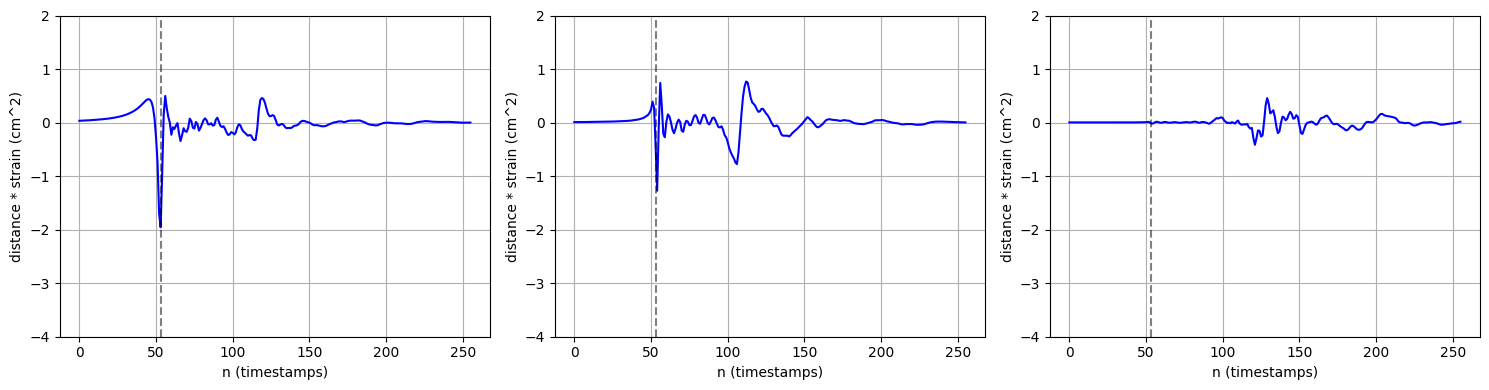

In [251]:
dataset = GWDataset("../data/gw-raw-data/richers_1764.csv", "../data/gw-raw-data/richers_1764_parameters.csv")

ylim_signal = dataset.get_common()
dataset.augmentation(6000)
dataset.calc_stats()
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

real_signals_batch, real_parameter_batch  = next(iter(dataloader))

print("Signal Batch Size: ", real_signals_batch.shape)
print("Parameter Batch Size: ", real_parameter_batch.shape)

ylim_signal_standardised = dataset.get_common()
parameter_names = ['beta1_IC_b', 'A(km)', 'omega_0(rad|s)']

plot_waveforms_standardised(real_signals_batch, real_parameter_batch)
# plot_waveforms_standardised(real_signals_batch, real_parameter_batch)

In [252]:
dataset.__len__()

6000

### Weight Initialisation (Random Noise)

In [253]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Generator

In [254]:
if gans_type == 'dcgans':
    class Generator(nn.Module):
        def __init__(self):
            super().__init__()
            self.main = nn.Sequential(
                nn.ConvTranspose1d(nz, ngf * 32, kernel_size=4, stride=1, padding=0, bias=False),
                nn.BatchNorm1d(ngf * 32),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 32, ngf * 16, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 16),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 16, ngf * 8, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 8),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 4),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 2),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf, nc, kernel_size=4, stride=2, padding=1, bias=False),
            )

        def forward(self, z):
            z = self.main(z)
            return z
        
if gans_type == 'gans':
    class Generator(nn.Module):
        def __init__(self):
            super(Generator, self).__init__()
            self.main = nn.Sequential(
                nn.Linear(nz, ngf),
                nn.BatchNorm1d(ngf),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Linear(ngf, ngf * 2),
                nn.BatchNorm1d(ngf * 2),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Linear(ngf * 2, ngf * 4),
                nn.BatchNorm1d(ngf * 4),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Linear(ngf * 4, ngf * 8),
                nn.BatchNorm1d(ngf * 8),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Linear(ngf * 8, 512),
            )

        def forward(self, z):
            z = z.view(z.size(0), -1)  # Flatten the tensor
            z = self.main(z)
            z = z.view(z.size(0), 1, 512)
            return z

In [255]:
netG = Generator().to(device)

netG.apply(weights_init)

print(netG)

model = Generator()
summary(model, input_size=(nz, nc))

Generator(
  (main): Sequential(
    (0): ConvTranspose1d(100, 2048, kernel_size=(4,), stride=(1,), bias=False)
    (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=True)
    (3): ConvTranspose1d(2048, 1024, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=True)
    (6): ConvTranspose1d(1024, 512, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=True)
    (9): ConvTranspose1d(512, 256, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=True)
    (12): ConvTranspose1d(256, 128, kernel_size=(4,), stride=(2,), padding=(1,), bias

### Discriminator

In [256]:
if (gans_type == "dcgans"):
    class Discriminator(nn.Module):
        def __init__(self):
            super(Discriminator, self).__init__()
            self.main = nn.Sequential(
                nn.Conv1d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout1d(0.2),

                nn.Conv1d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout1d(0.2),

                nn.Conv1d(ndf * 2, ndf * 4, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout1d(0.2),

                nn.Conv1d(ndf * 4, ndf * 8, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 8),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout1d(0.2),

                ### Can increase model complexity here ###
                # nn.Conv1d(ndf * 8, ndf * 16, kernel_size=4,
                #         stride=2, padding=1, bias=False),
                # nn.BatchNorm1d(ndf * 16),
                # nn.LeakyReLU(0.2, inplace=True),
                # nn.Dropout1d(0.2),

                # nn.Conv1d(ndf * 16, ndf * 32, kernel_size=4,
                #         stride=2, padding=1, bias=False),
                # nn.BatchNorm1d(ndf * 32),
                # nn.LeakyReLU(0.2, inplace=True),
                # nn.Dropout1d(0.2),

                # nn.Conv1d(ndf * 32, nc, kernel_size=4,
                #         stride=2, padding=0, bias=False),
                # nn.BatchNorm1d(ndf * 64),
                # nn.LeakyReLU(0.2, inplace=True),
                # nn.Dropout1d(0.2),
                
                # nn.Conv1d(ndf * 64, nc, kernel_size=4,
                #         stride=2, padding=0, bias=False)
            )

            self.fc = nn.Sequential(
                nn.LazyLinear(1),
                nn.Sigmoid()
            )

        def forward(self, x):
            x = self.main(x)
            x = x.view(x.shape[0], -1)  # Flatten the tensor
            x = self.fc(x)
            return x

elif (gans_type == "gans"):
    class Discriminator(nn.Module):
        def __init__(self):
            super(Discriminator, self).__init__()
            self.main = nn.Sequential(
                nn.Linear(512, 256),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Linear(256, 128),
                # nn.BatchNorm1d(128),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Linear(128, 64),
                # nn.BatchNorm1d(64),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Linear(64, 32),
                # nn.BatchNorm1d(32),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Linear(32, 16),
                # nn.BatchNorm1d(16),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Linear(16, 1),
                nn.Sigmoid(),
            )

        def forward(self, x):
            x = x.view(x.size(0), -1)  # Flatten the tensor
            x = self.main(x)
            return x

In [257]:
netD = Discriminator().to(device)

netD.apply(weights_init)

print(netD)

model = Discriminator()
summary(model, input_size=(nc, 256))

Discriminator(
  (main): Sequential(
    (0): Conv1d(1, 64, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout1d(p=0.2, inplace=False)
    (3): Conv1d(64, 128, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Dropout1d(p=0.2, inplace=False)
    (7): Conv1d(128, 256, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (8): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Dropout1d(p=0.2, inplace=False)
    (11): Conv1d(256, 512, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (12): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14): Dropout1d(p=0.2,

/Users/tarineccleston/Documents/software-ds/gw-generative-models/.venv/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### Loss functions and Optimisers

In [258]:
criterion = nn.BCELoss()

optimizerD = optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))

# learning-rate decay scheduler
schedulerD = lr_scheduler.LinearLR(optimizerD, start_factor=1.0, end_factor=0.5, total_iters=32)
schedulerG = lr_scheduler.LinearLR(optimizerG, start_factor=1.0, end_factor=0.5, total_iters=32)

# establish convention for real and fake labels during training
real_label = 1.0
fake_label = 0.0

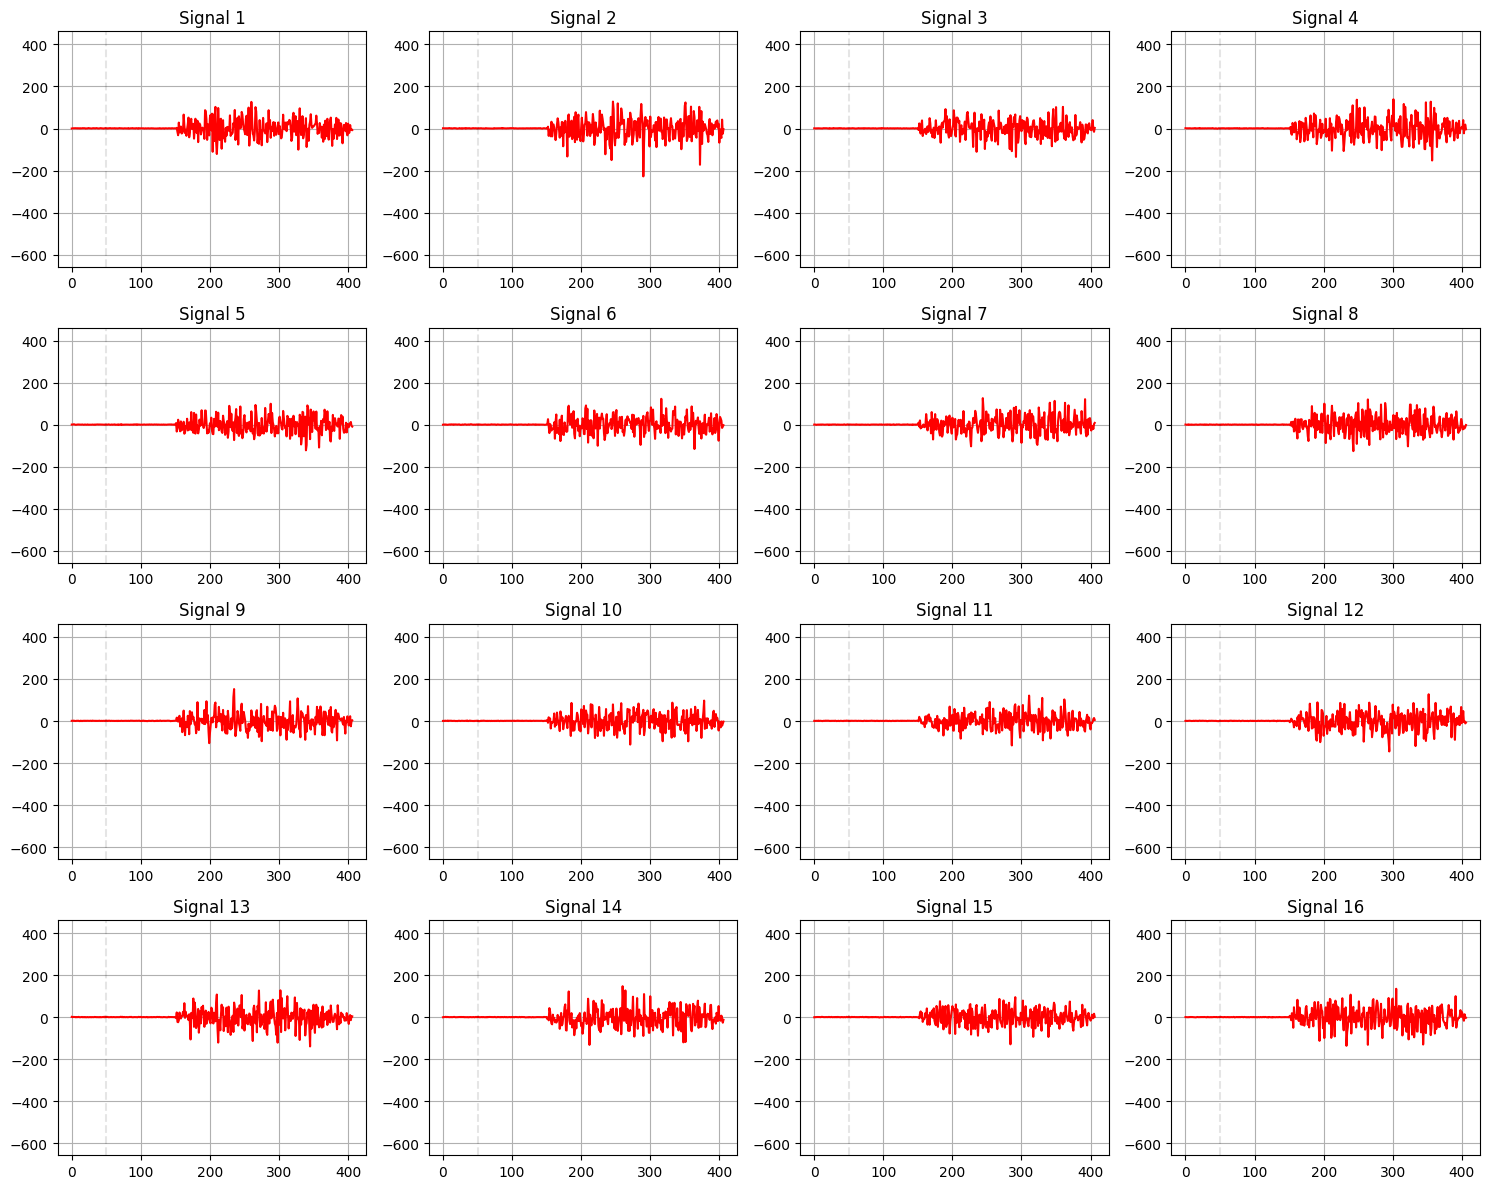

In [259]:
# create batch of latent vectors that we will use to visualize the progression of the generator
fixed_noise = torch.randn(batch_size, nz, 1, device=device)

# plot generated signals before training
with torch.no_grad():
    fake_signals = netG(fixed_noise).detach().cpu()
    fig, axes = plt.subplots(4, 4, figsize=(15, 12))

    axes = axes.flatten()

    # plot each signal on a separate subplot
    for i, ax in enumerate(axes):
        x = np.arange(407)
        y = fake_signals[i, :, :].flatten()
        y = y * dataset.scaling_factor
        y = y * dataset.std + dataset.mean
        background_noise_generated = np.random.normal(dataset.background_noise_mean, dataset.background_noise_std, int(407-256))
        y = np.concatenate((background_noise_generated, y))
        ax.plot(x, y, color = 'red')

        ax.axvline(x=50, color='black', linestyle='--', alpha=0.1)
        ax.set_title(f'Signal {i+1}')
        ax.grid(True)
        ax.set_ylim(ylim_signal)

    for i in range(512, 8*4):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.savefig('../data/gw-dcgans-images/gw-dcgans_epoch_0.png')
    plt.show()

### Training

Starting Training Loop...
[0/32][0/188]	Loss_D: 1.7023	Loss_G: 0.8066	D(x): 0.3648	D(G(z)): 0.4540 / 0.4620
[0/32][50/188]	Loss_D: 0.7803	Loss_G: 1.0746	D(x): 0.8350	D(G(z)): 0.3728 / 0.3554
[0/32][100/188]	Loss_D: 0.6035	Loss_G: 1.6640	D(x): 0.8914	D(G(z)): 0.2328 / 0.2138
[0/32][150/188]	Loss_D: 0.5769	Loss_G: 1.7256	D(x): 0.8921	D(G(z)): 0.2206 / 0.2079
Epoch 0: SGD Discriminator lr 0.0000200 -> 0.0000197
Epoch 0: SGD Generator lr 0.0000200 -> 0.0000197


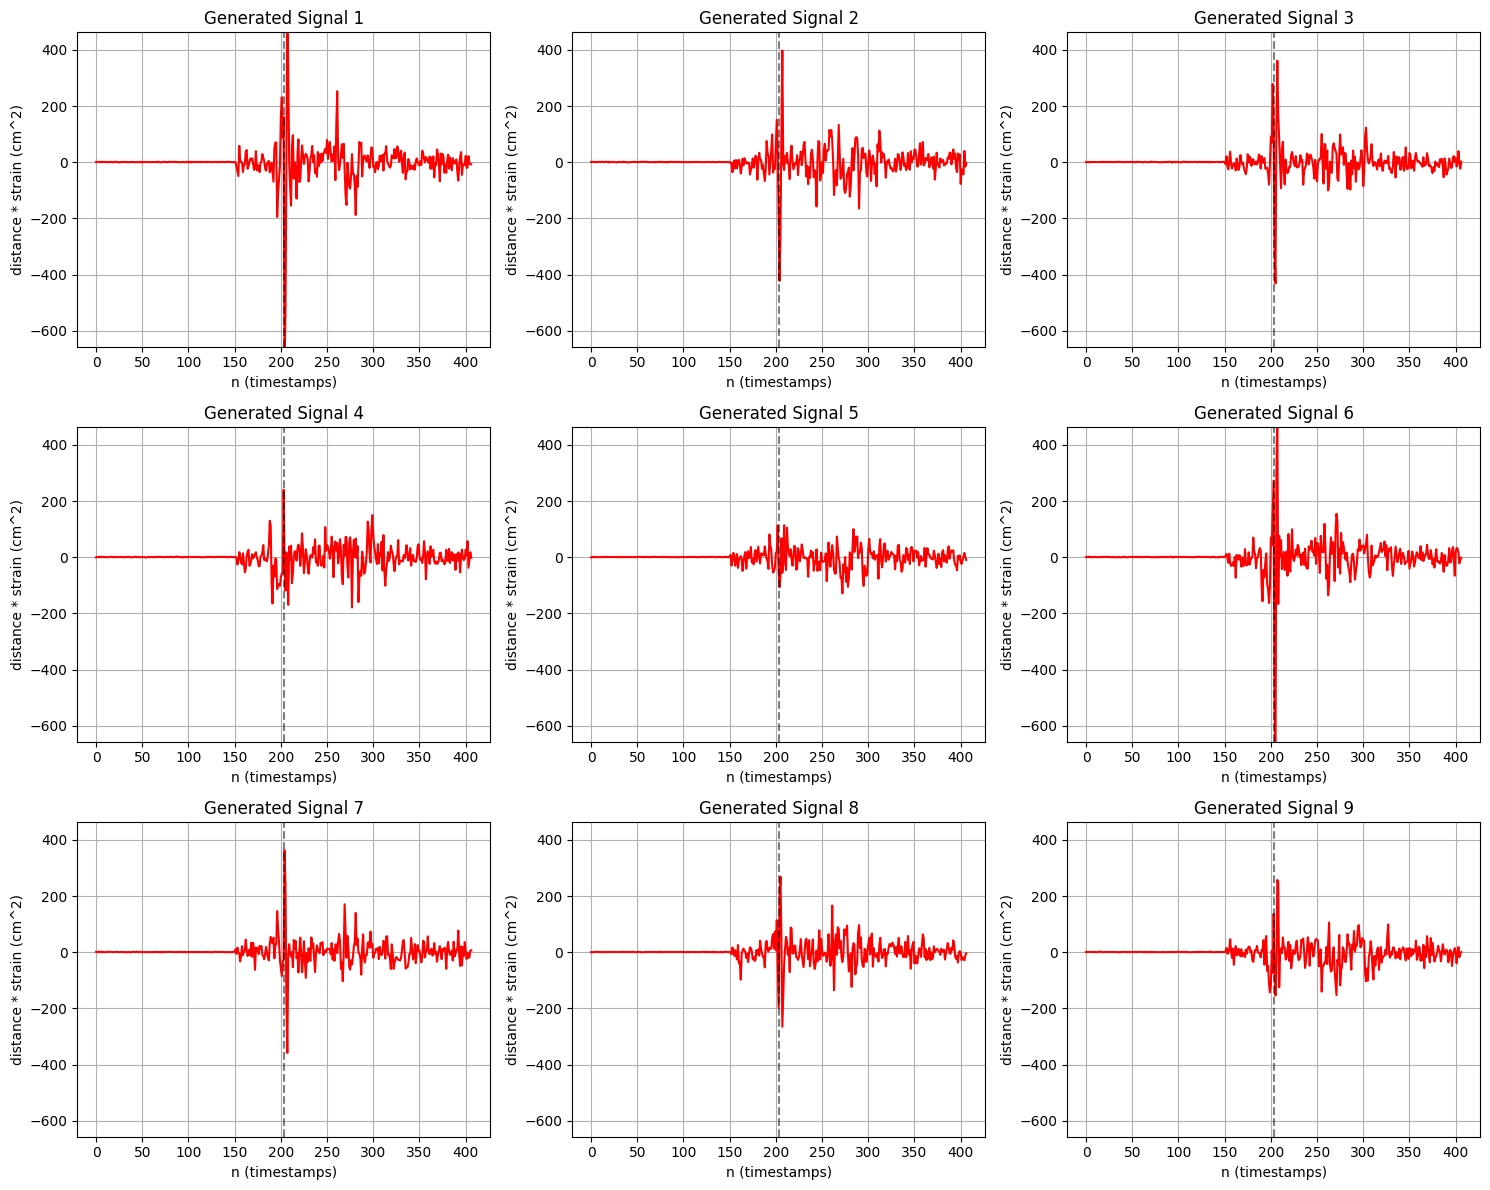

[1/32][0/188]	Loss_D: 0.5251	Loss_G: 1.8706	D(x): 0.9053	D(G(z)): 0.1967 / 0.1902
[1/32][50/188]	Loss_D: 0.6214	Loss_G: 1.5457	D(x): 0.9020	D(G(z)): 0.3110 / 0.2497
[1/32][100/188]	Loss_D: 0.5946	Loss_G: 1.3536	D(x): 0.9276	D(G(z)): 0.3164 / 0.3082
[1/32][150/188]	Loss_D: 0.5375	Loss_G: 1.6345	D(x): 0.9120	D(G(z)): 0.2009 / 0.2286
Epoch 1: SGD Discriminator lr 0.0000197 -> 0.0000194
Epoch 1: SGD Generator lr 0.0000197 -> 0.0000194


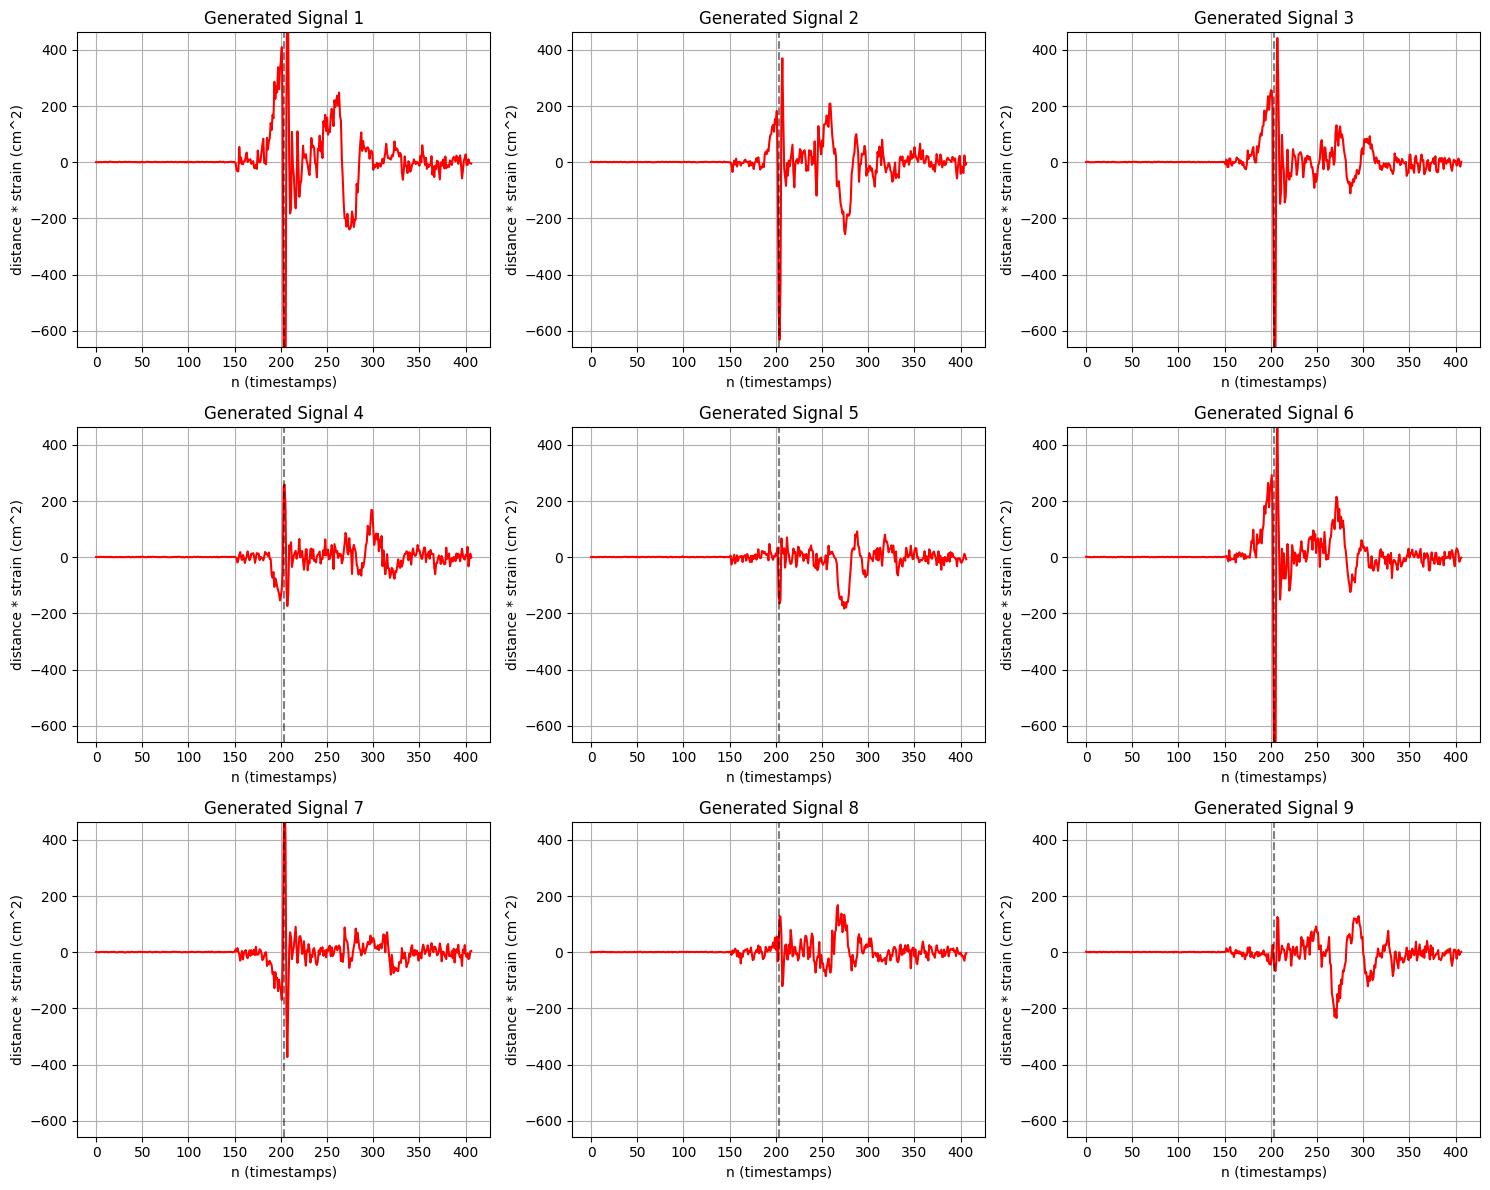

[2/32][0/188]	Loss_D: 0.5642	Loss_G: 1.4065	D(x): 0.9448	D(G(z)): 0.2647 / 0.2849
[2/32][50/188]	Loss_D: 0.5420	Loss_G: 1.7877	D(x): 0.9326	D(G(z)): 0.2248 / 0.2096
[2/32][100/188]	Loss_D: 0.5173	Loss_G: 2.5692	D(x): 0.9534	D(G(z)): 0.0864 / 0.0903
[2/32][150/188]	Loss_D: 0.4599	Loss_G: 1.8466	D(x): 0.9499	D(G(z)): 0.1796 / 0.1842
Epoch 2: SGD Discriminator lr 0.0000194 -> 0.0000191
Epoch 2: SGD Generator lr 0.0000194 -> 0.0000191


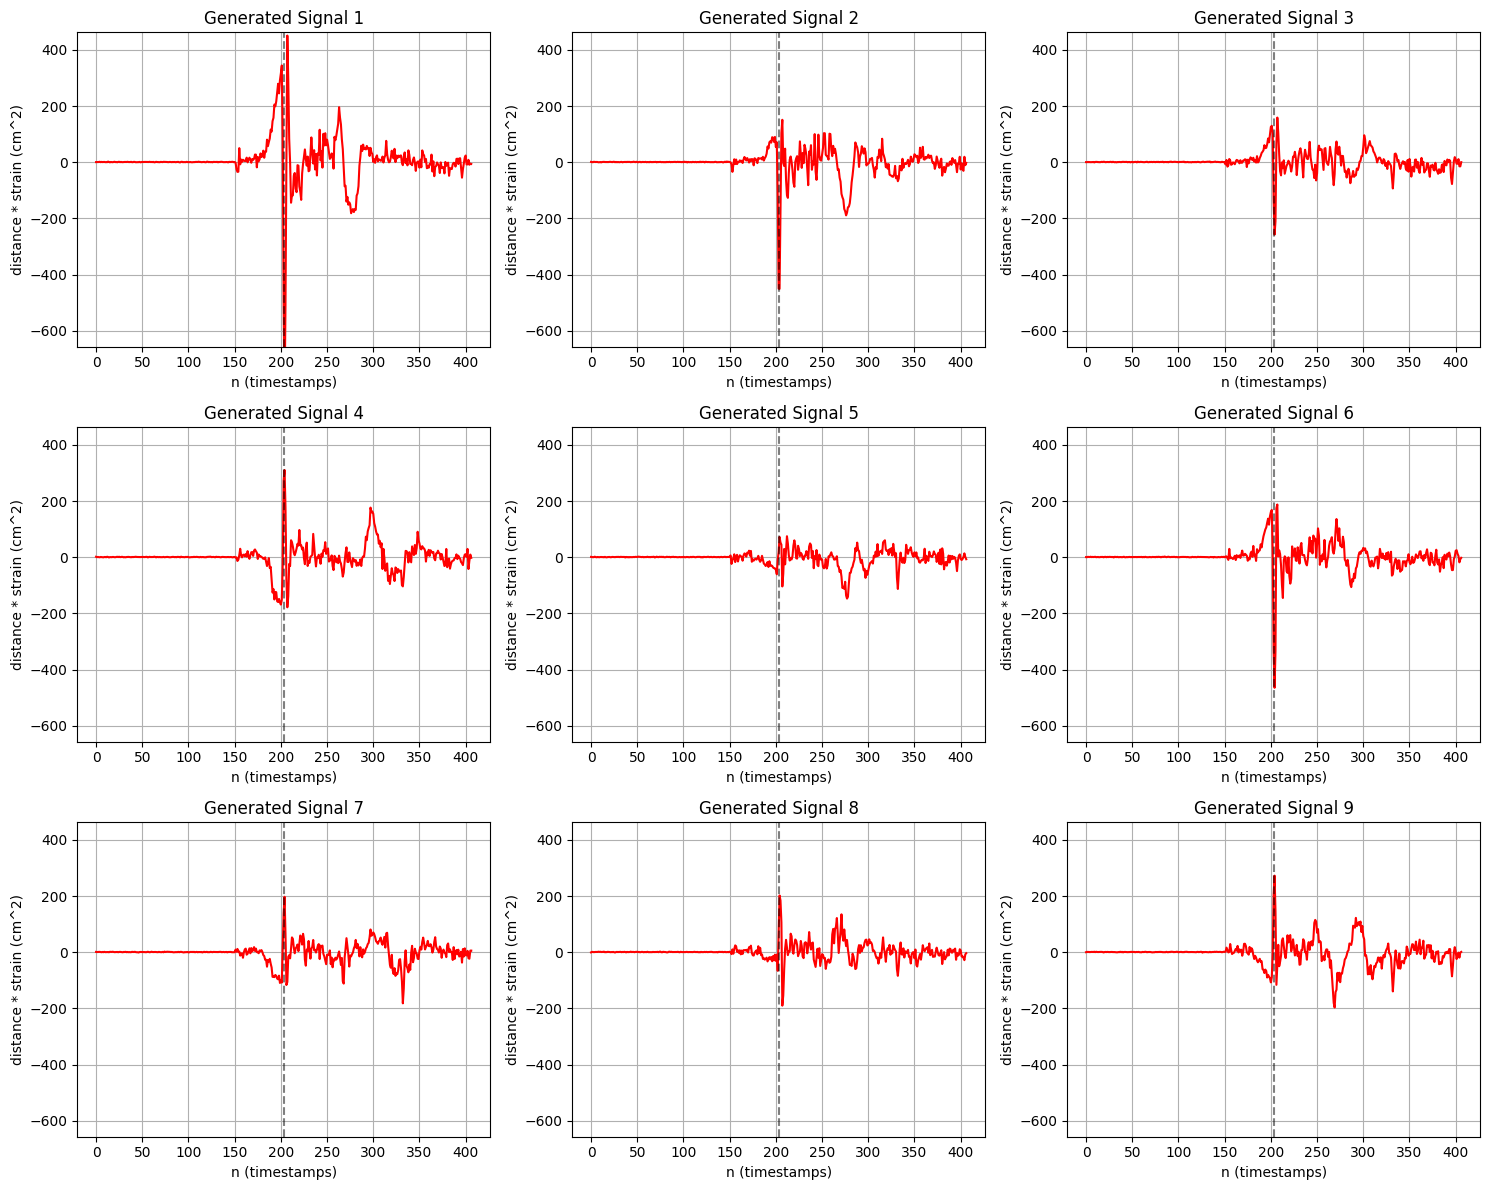

[3/32][0/188]	Loss_D: 0.5241	Loss_G: 2.6367	D(x): 0.9103	D(G(z)): 0.0969 / 0.0882
[3/32][50/188]	Loss_D: 0.5930	Loss_G: 1.5696	D(x): 0.9124	D(G(z)): 0.2880 / 0.2780
[3/32][100/188]	Loss_D: 0.5627	Loss_G: 1.9100	D(x): 0.9409	D(G(z)): 0.1868 / 0.2061
[3/32][150/188]	Loss_D: 0.4943	Loss_G: 2.1094	D(x): 0.9278	D(G(z)): 0.1222 / 0.1594
Epoch 3: SGD Discriminator lr 0.0000191 -> 0.0000188
Epoch 3: SGD Generator lr 0.0000191 -> 0.0000188


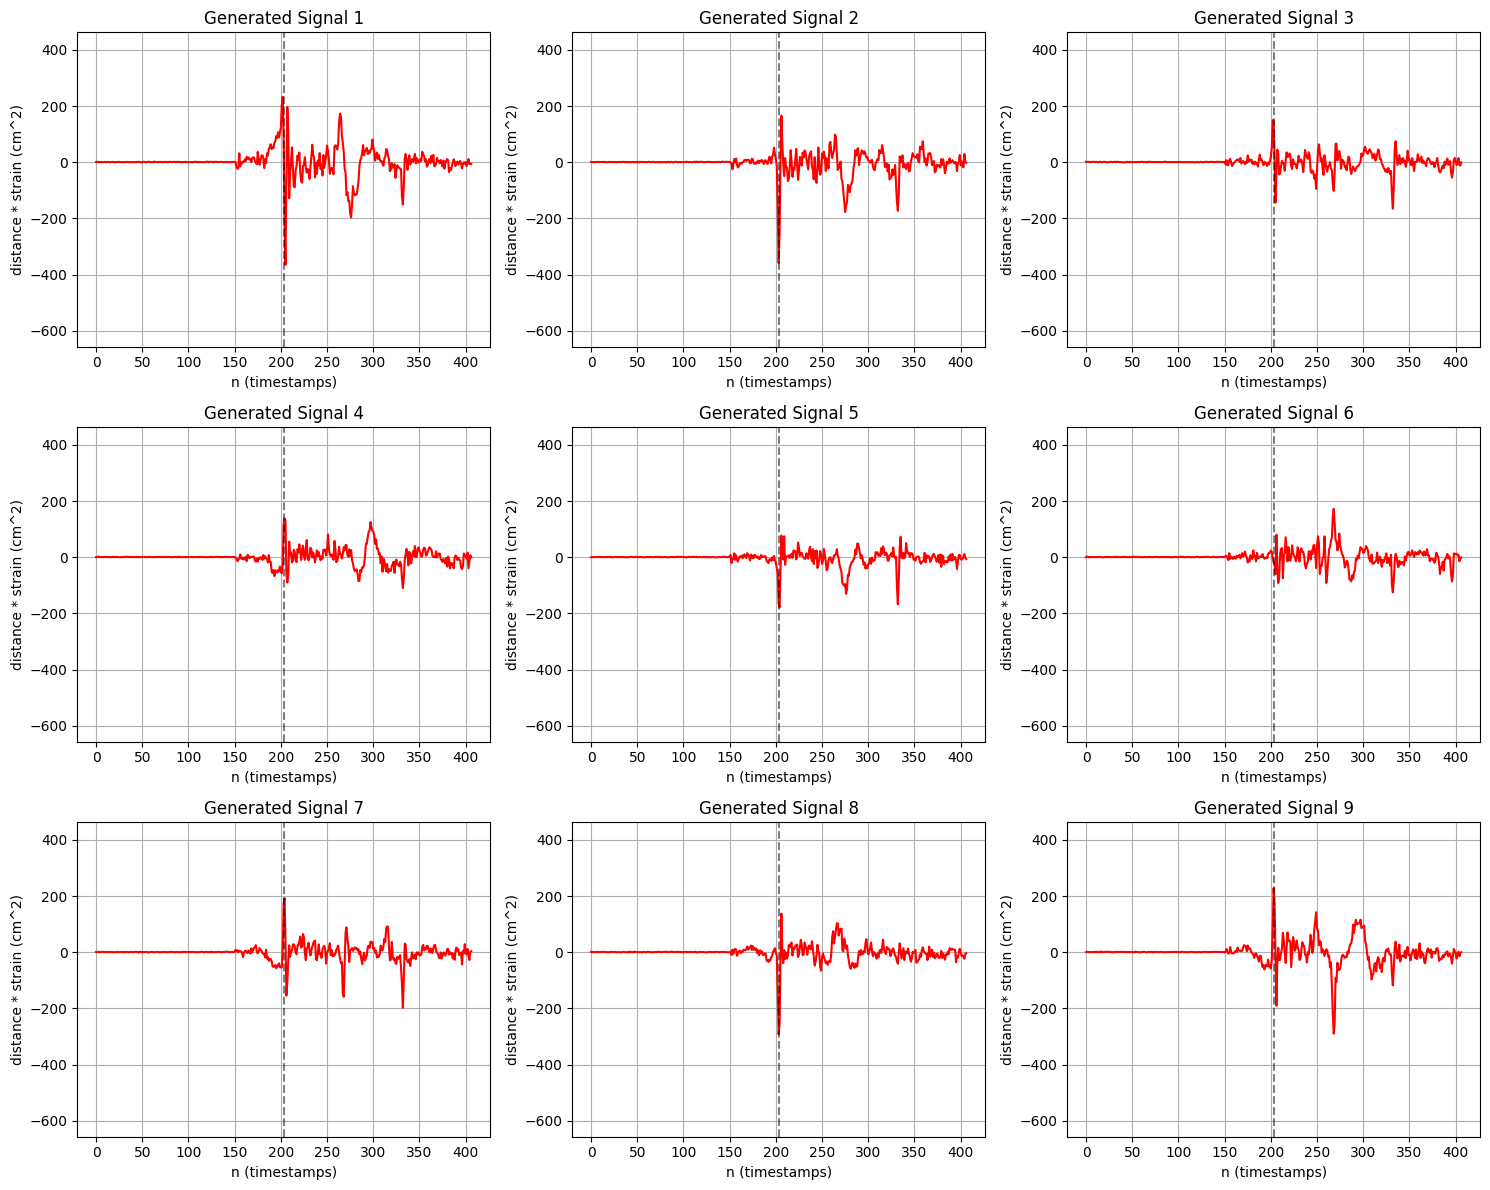

[4/32][0/188]	Loss_D: 0.5488	Loss_G: 1.6189	D(x): 0.9366	D(G(z)): 0.2318 / 0.2478
[4/32][50/188]	Loss_D: 0.5335	Loss_G: 2.5429	D(x): 0.9400	D(G(z)): 0.1259 / 0.1019
[4/32][100/188]	Loss_D: 0.4640	Loss_G: 3.0534	D(x): 0.9444	D(G(z)): 0.0528 / 0.0536
[4/32][150/188]	Loss_D: 0.4296	Loss_G: 2.3019	D(x): 0.9512	D(G(z)): 0.1155 / 0.1188
Epoch 4: SGD Discriminator lr 0.0000188 -> 0.0000184
Epoch 4: SGD Generator lr 0.0000188 -> 0.0000184


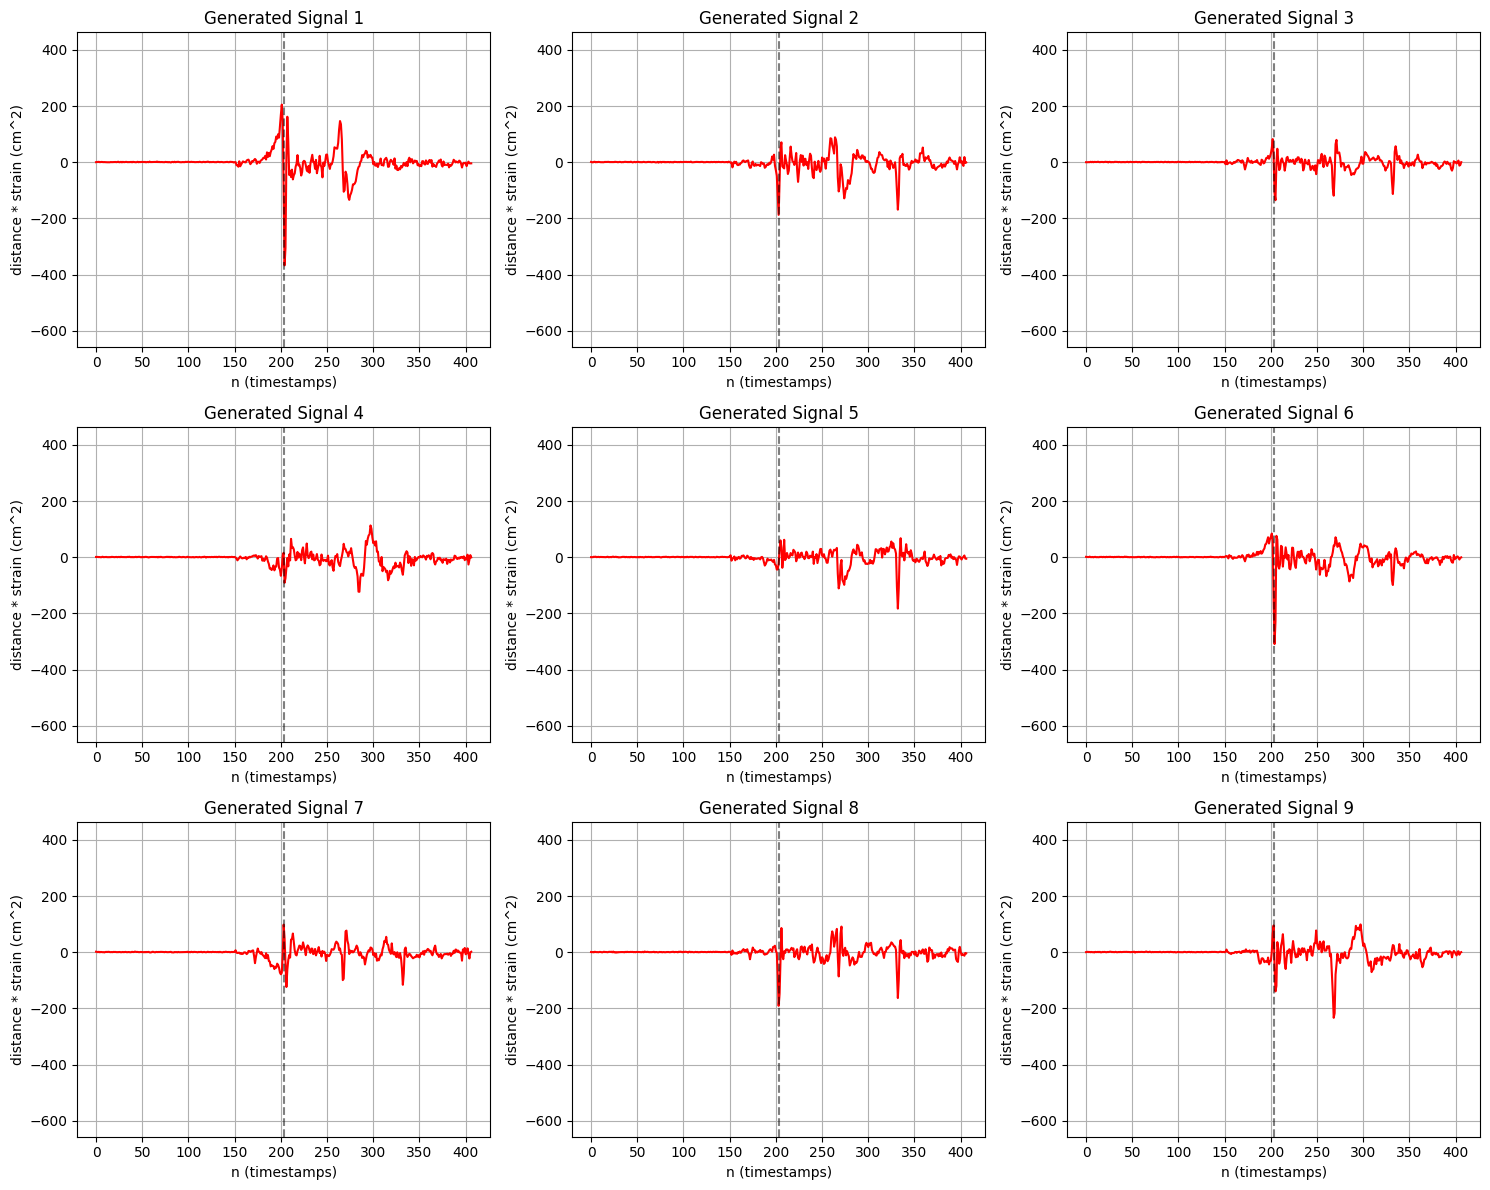

[5/32][0/188]	Loss_D: 0.6501	Loss_G: 1.3751	D(x): 0.9506	D(G(z)): 0.3662 / 0.3244
[5/32][50/188]	Loss_D: 0.6484	Loss_G: 1.6030	D(x): 0.9301	D(G(z)): 0.3143 / 0.2723
[5/32][100/188]	Loss_D: 0.6054	Loss_G: 1.8890	D(x): 0.9401	D(G(z)): 0.2155 / 0.2211
[5/32][150/188]	Loss_D: 0.5681	Loss_G: 1.9938	D(x): 0.8933	D(G(z)): 0.1690 / 0.1816
Epoch 5: SGD Discriminator lr 0.0000184 -> 0.0000181
Epoch 5: SGD Generator lr 0.0000184 -> 0.0000181


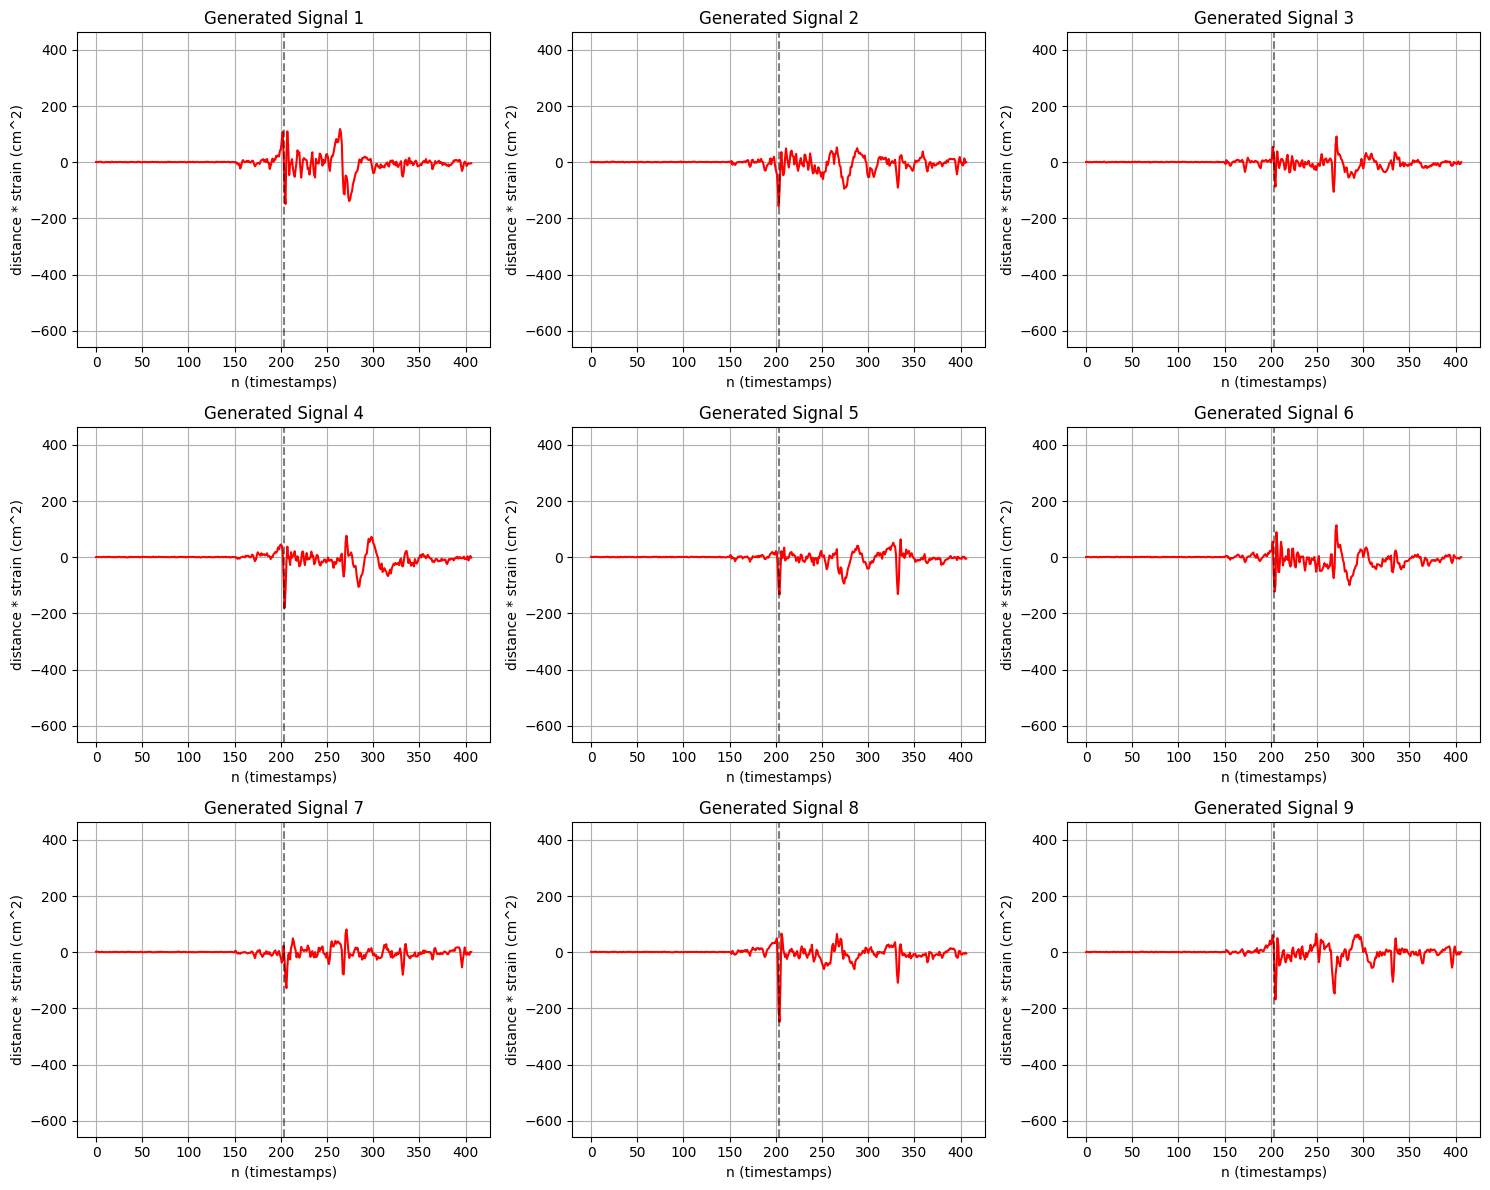

[6/32][0/188]	Loss_D: 0.5681	Loss_G: 2.0182	D(x): 0.9357	D(G(z)): 0.1674 / 0.1896
[6/32][50/188]	Loss_D: 0.6000	Loss_G: 2.1763	D(x): 0.9313	D(G(z)): 0.2376 / 0.1713
[6/32][100/188]	Loss_D: 0.6290	Loss_G: 2.1237	D(x): 0.9469	D(G(z)): 0.2042 / 0.2065
[6/32][150/188]	Loss_D: 0.5710	Loss_G: 2.3645	D(x): 0.9504	D(G(z)): 0.1799 / 0.1652
Epoch 6: SGD Discriminator lr 0.0000181 -> 0.0000178
Epoch 6: SGD Generator lr 0.0000181 -> 0.0000178


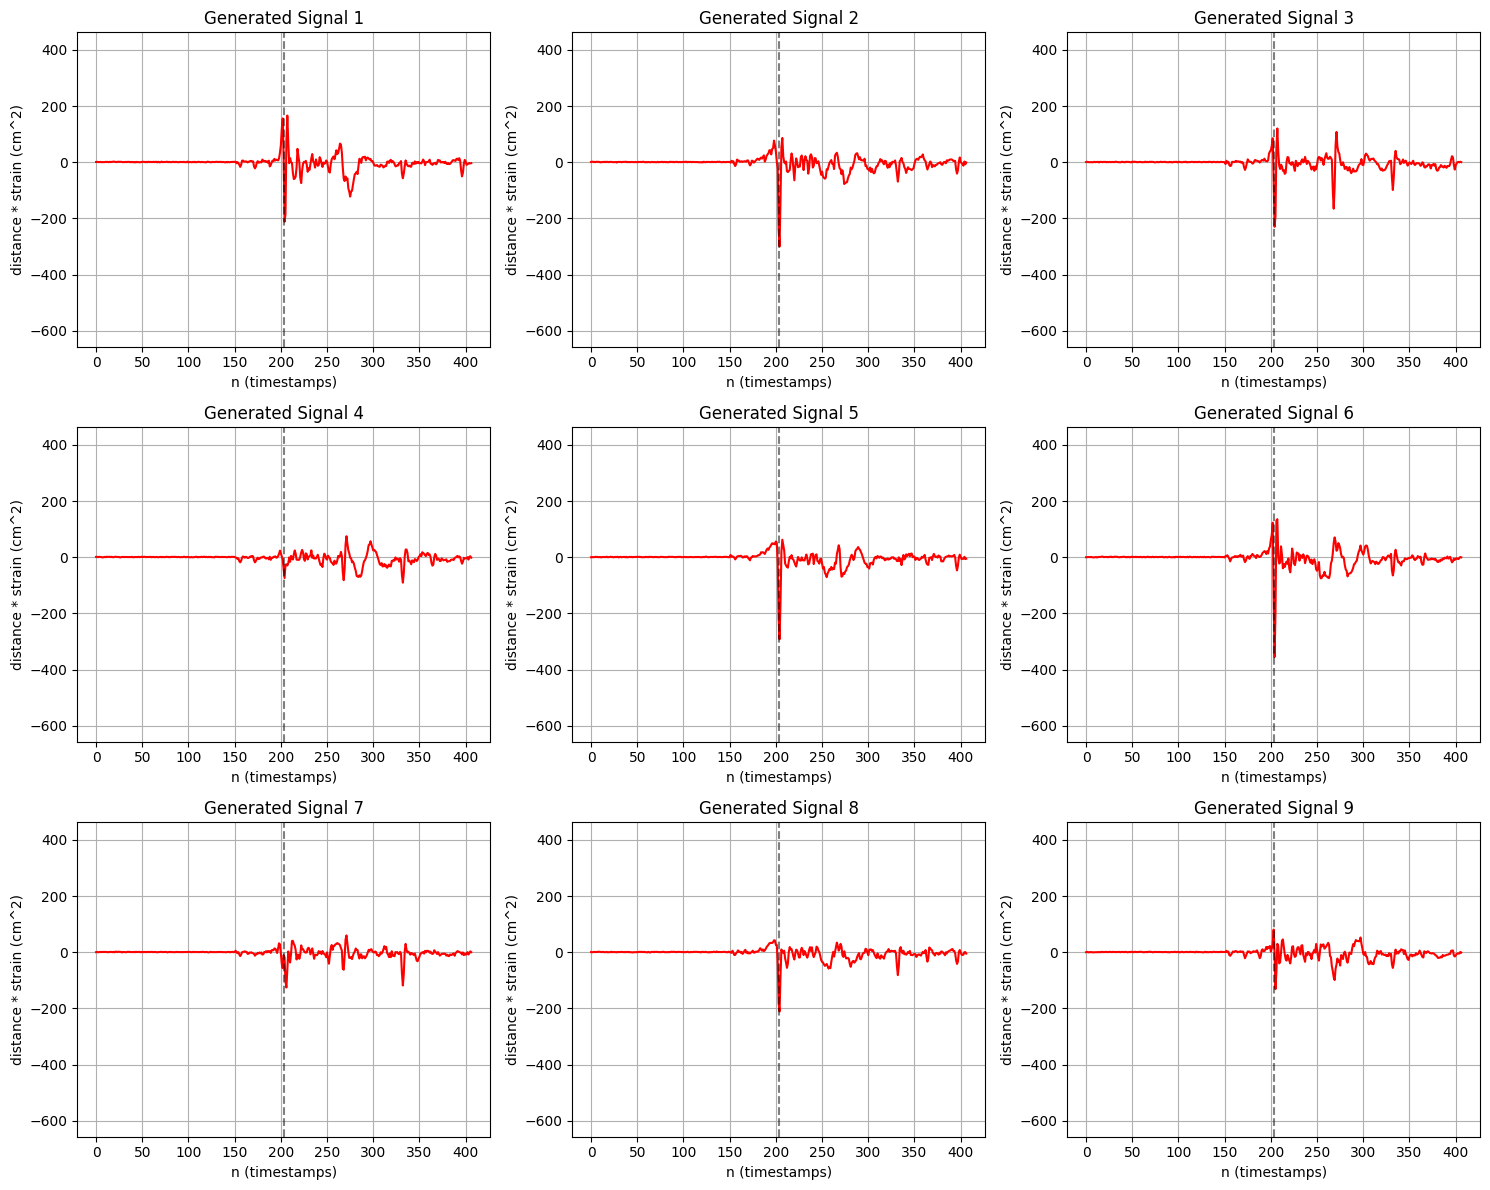

[7/32][0/188]	Loss_D: 0.4994	Loss_G: 2.0564	D(x): 0.9286	D(G(z)): 0.1527 / 0.1822
[7/32][50/188]	Loss_D: 0.6012	Loss_G: 1.5373	D(x): 0.9187	D(G(z)): 0.2944 / 0.2666
[7/32][100/188]	Loss_D: 0.5582	Loss_G: 1.8814	D(x): 0.9119	D(G(z)): 0.2152 / 0.1985
[7/32][150/188]	Loss_D: 0.5670	Loss_G: 2.2617	D(x): 0.8867	D(G(z)): 0.1490 / 0.1436
Epoch 7: SGD Discriminator lr 0.0000178 -> 0.0000175
Epoch 7: SGD Generator lr 0.0000178 -> 0.0000175


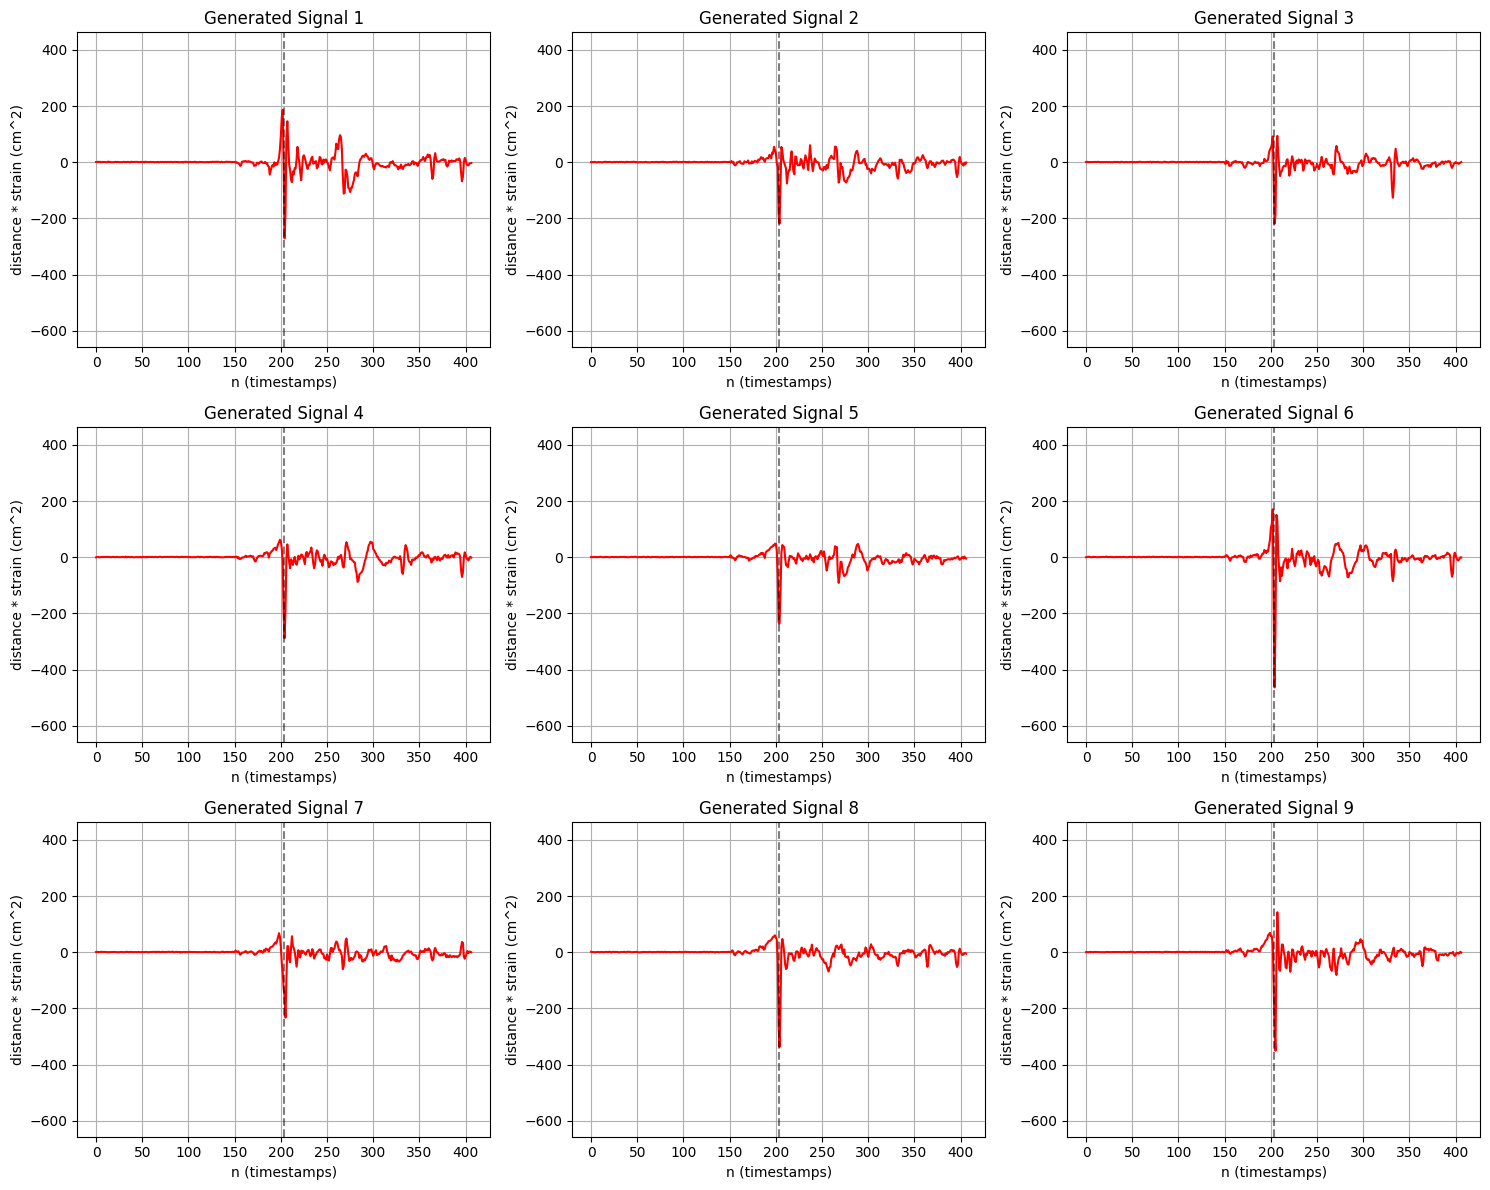

[8/32][0/188]	Loss_D: 0.5077	Loss_G: 1.8436	D(x): 0.9243	D(G(z)): 0.1928 / 0.2138
[8/32][50/188]	Loss_D: 0.5693	Loss_G: 2.0251	D(x): 0.9141	D(G(z)): 0.2123 / 0.1714
[8/32][100/188]	Loss_D: 0.5999	Loss_G: 1.7244	D(x): 0.9087	D(G(z)): 0.2358 / 0.2522
[8/32][150/188]	Loss_D: 0.5157	Loss_G: 2.4590	D(x): 0.9215	D(G(z)): 0.1171 / 0.1111
Epoch 8: SGD Discriminator lr 0.0000175 -> 0.0000172
Epoch 8: SGD Generator lr 0.0000175 -> 0.0000172


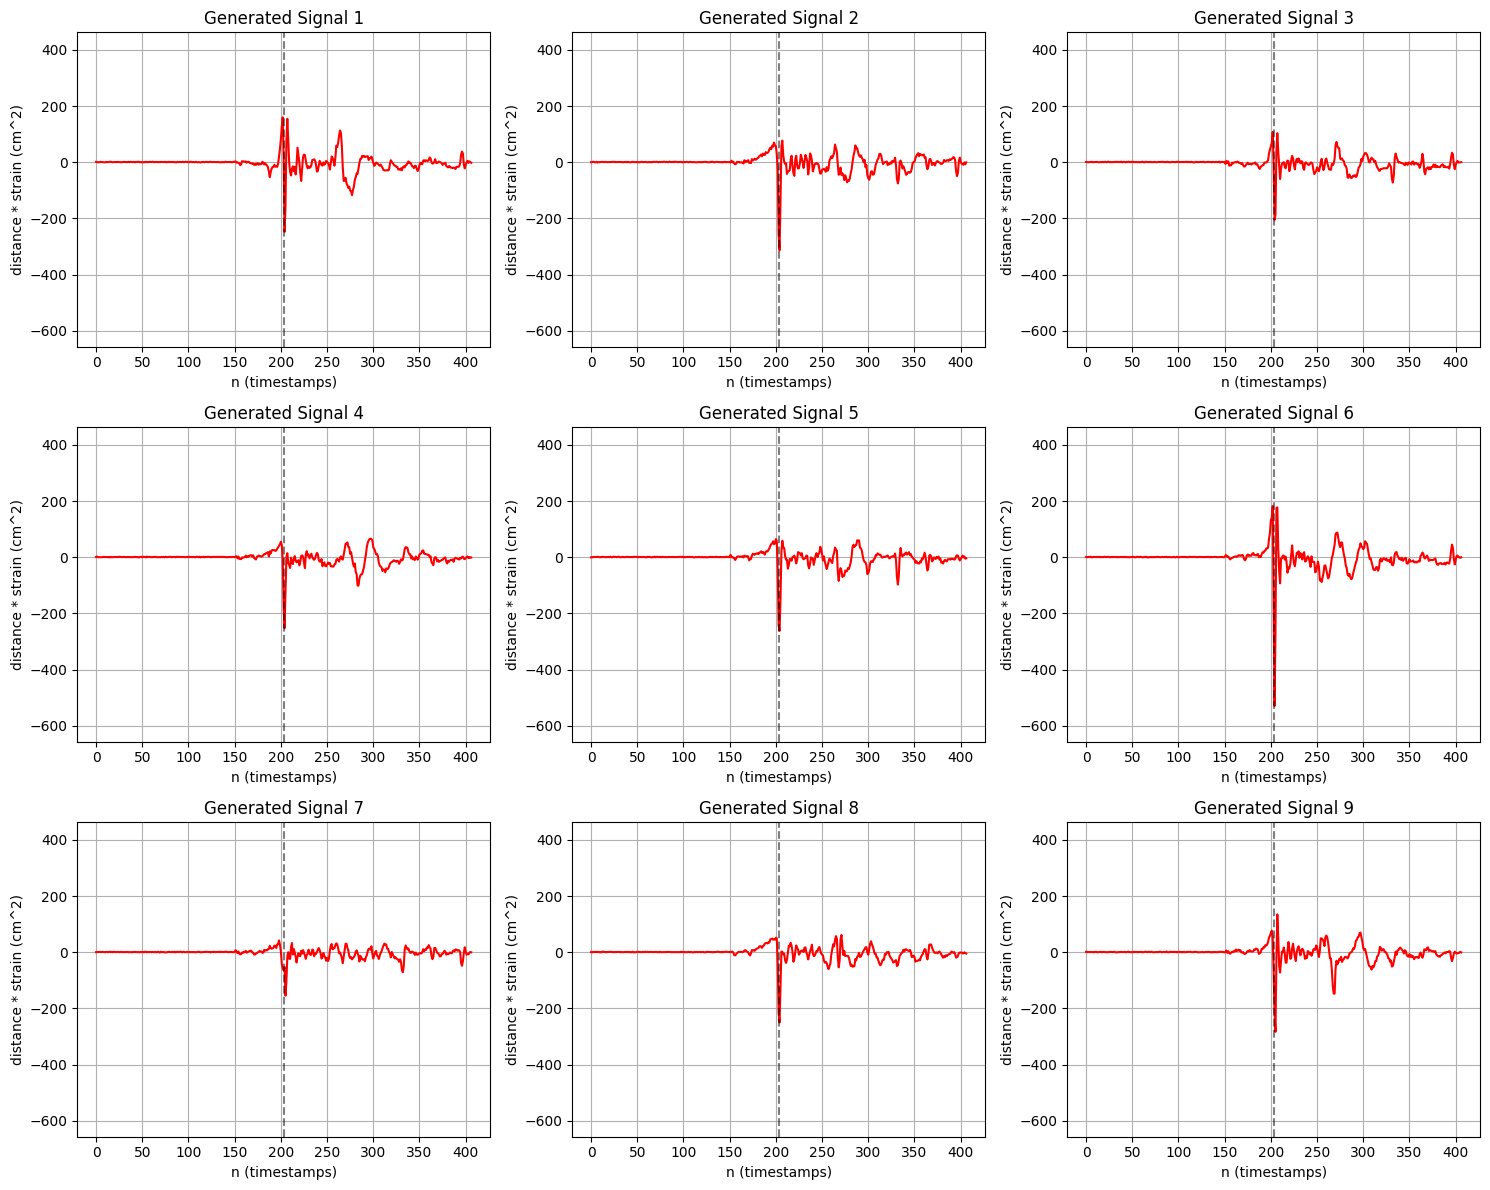

[9/32][0/188]	Loss_D: 0.5186	Loss_G: 2.1454	D(x): 0.9154	D(G(z)): 0.1366 / 0.1559
[9/32][50/188]	Loss_D: 0.4746	Loss_G: 2.3066	D(x): 0.9441	D(G(z)): 0.1062 / 0.1451
[9/32][100/188]	Loss_D: 0.5479	Loss_G: 1.8711	D(x): 0.9381	D(G(z)): 0.1903 / 0.1954
[9/32][150/188]	Loss_D: 0.5504	Loss_G: 1.8506	D(x): 0.9175	D(G(z)): 0.2459 / 0.2126
Epoch 9: SGD Discriminator lr 0.0000172 -> 0.0000169
Epoch 9: SGD Generator lr 0.0000172 -> 0.0000169


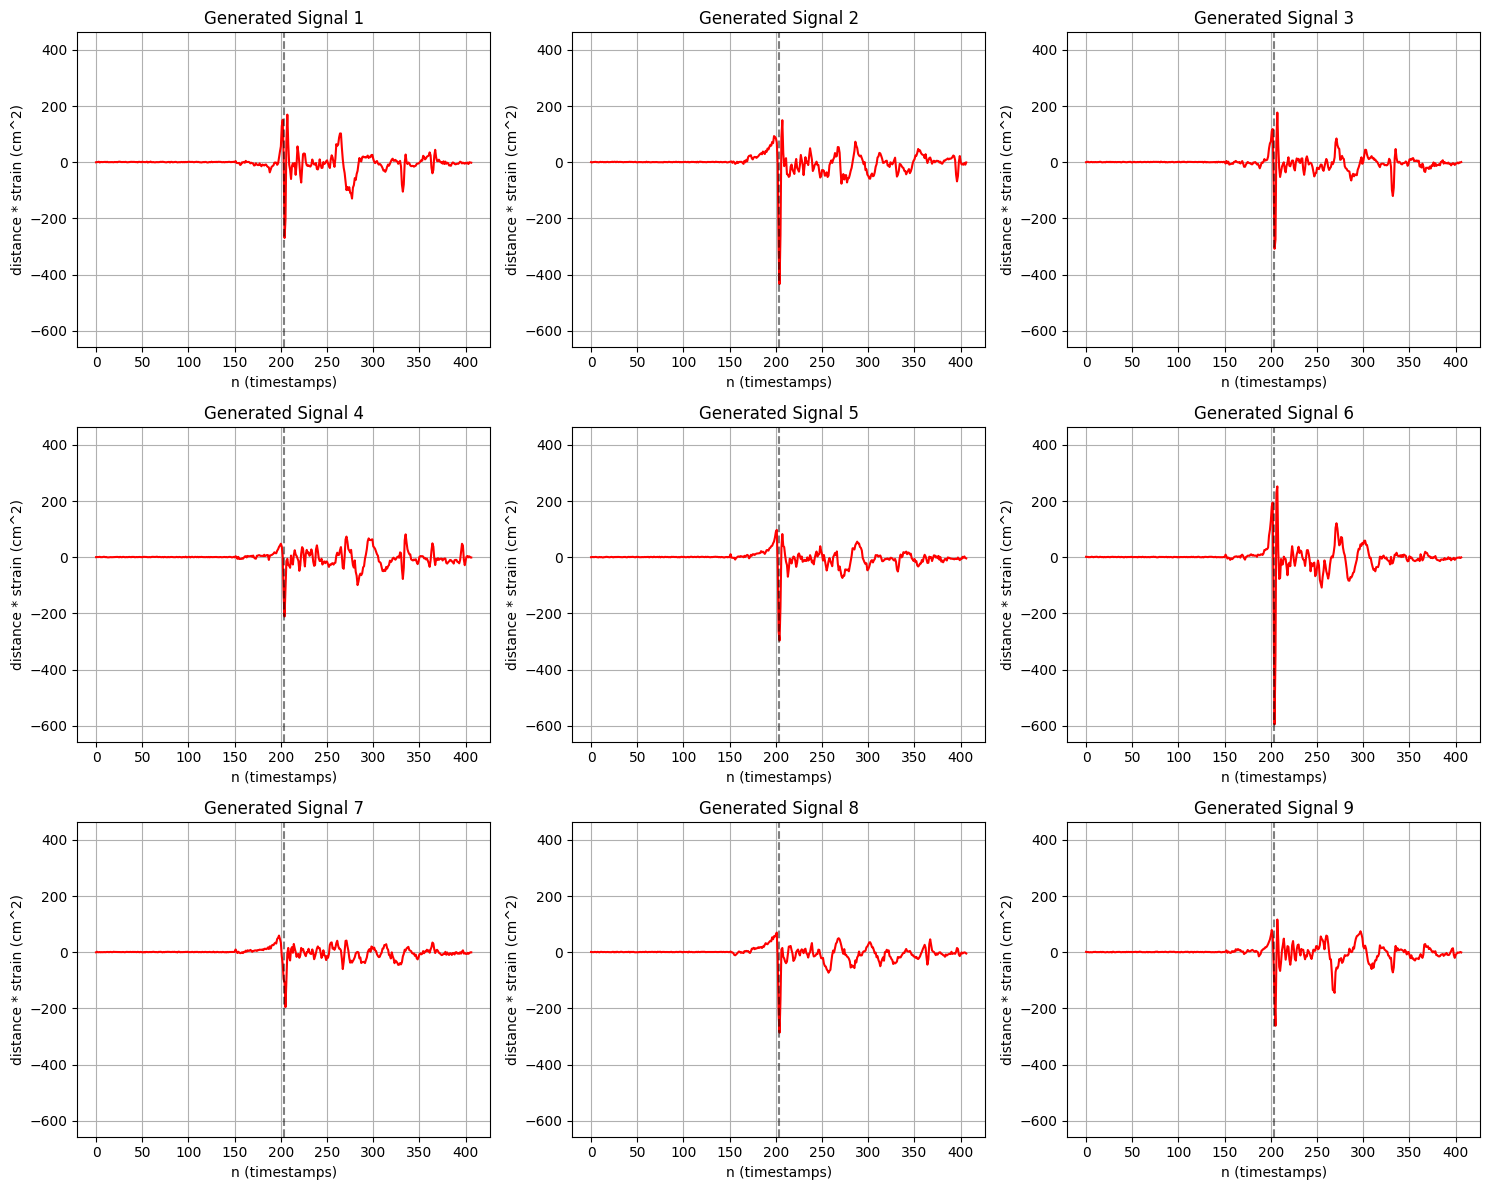

[10/32][0/188]	Loss_D: 0.5461	Loss_G: 1.6553	D(x): 0.9227	D(G(z)): 0.2441 / 0.2479
[10/32][50/188]	Loss_D: 0.5376	Loss_G: 2.1901	D(x): 0.9191	D(G(z)): 0.1782 / 0.1629
[10/32][100/188]	Loss_D: 0.5446	Loss_G: 3.0755	D(x): 0.9088	D(G(z)): 0.0681 / 0.0641
[10/32][150/188]	Loss_D: 0.5866	Loss_G: 1.8795	D(x): 0.9297	D(G(z)): 0.2210 / 0.1966
Epoch 10: SGD Discriminator lr 0.0000169 -> 0.0000166
Epoch 10: SGD Generator lr 0.0000169 -> 0.0000166


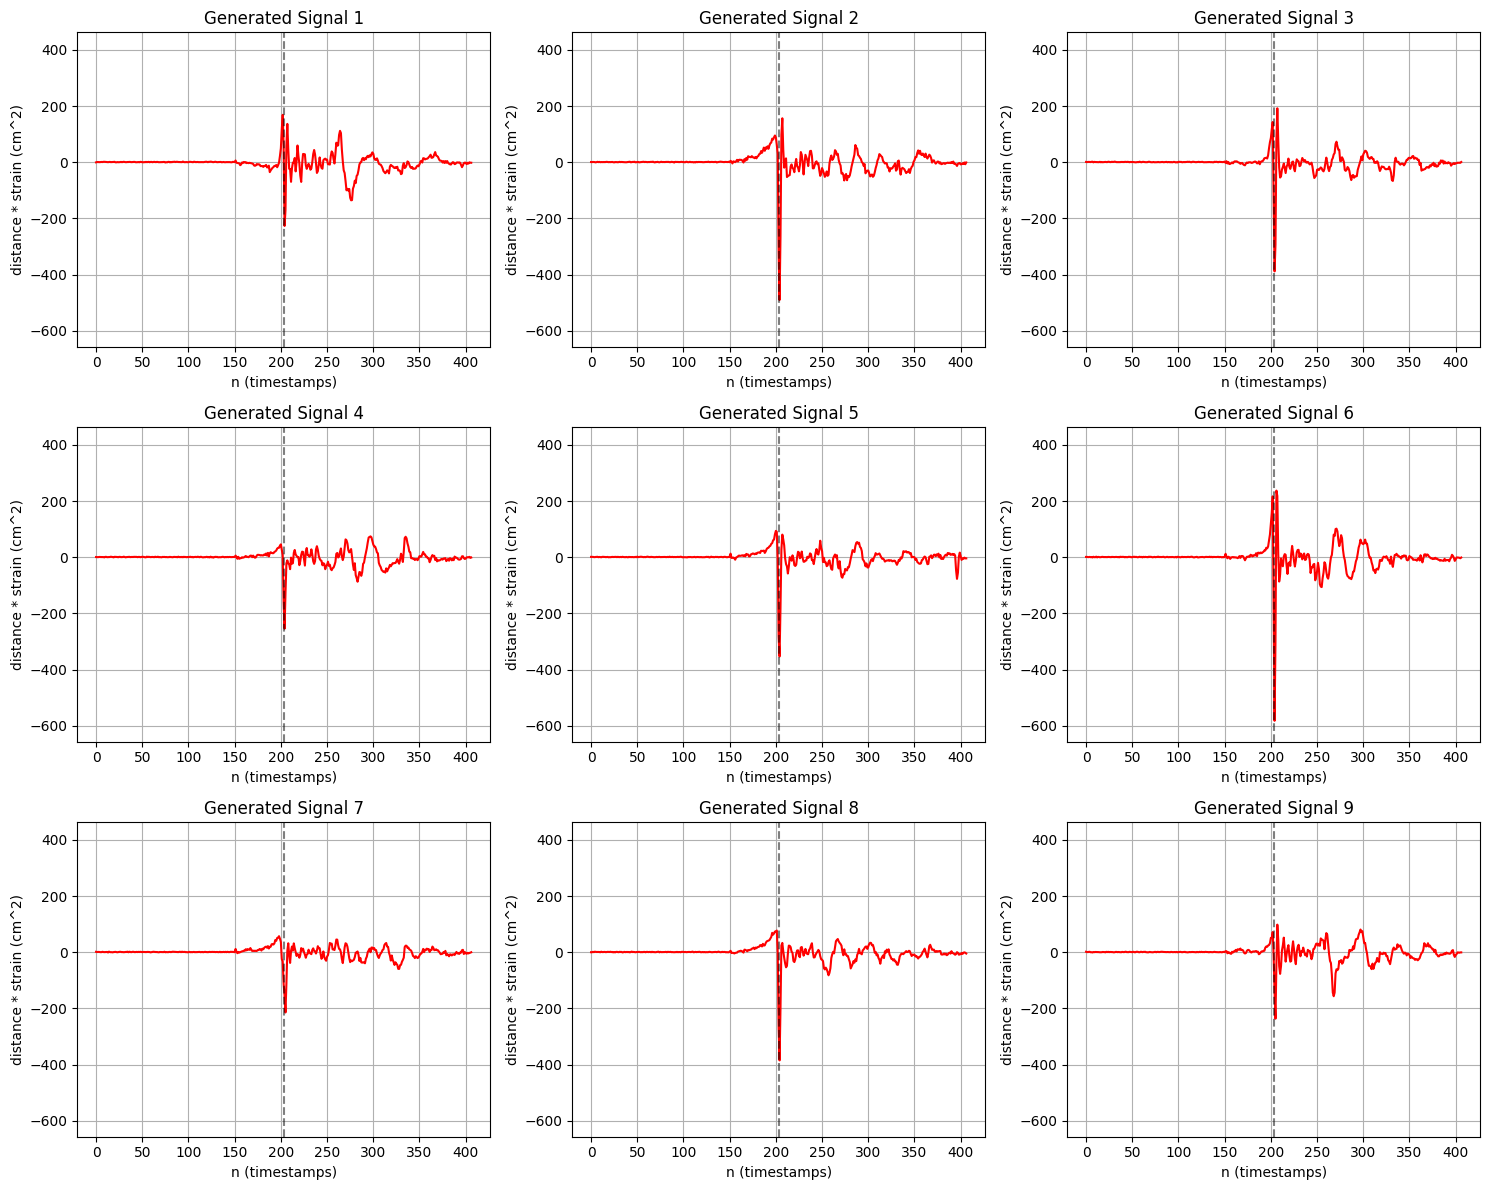

[11/32][0/188]	Loss_D: 0.5606	Loss_G: 2.1925	D(x): 0.8941	D(G(z)): 0.1640 / 0.1441
[11/32][50/188]	Loss_D: 0.4789	Loss_G: 1.8984	D(x): 0.9364	D(G(z)): 0.1533 / 0.1884
[11/32][100/188]	Loss_D: 0.5526	Loss_G: 2.0607	D(x): 0.9493	D(G(z)): 0.2094 / 0.1597
[11/32][150/188]	Loss_D: 0.4661	Loss_G: 1.9871	D(x): 0.9404	D(G(z)): 0.1583 / 0.1749
Epoch 11: SGD Discriminator lr 0.0000166 -> 0.0000162
Epoch 11: SGD Generator lr 0.0000166 -> 0.0000162


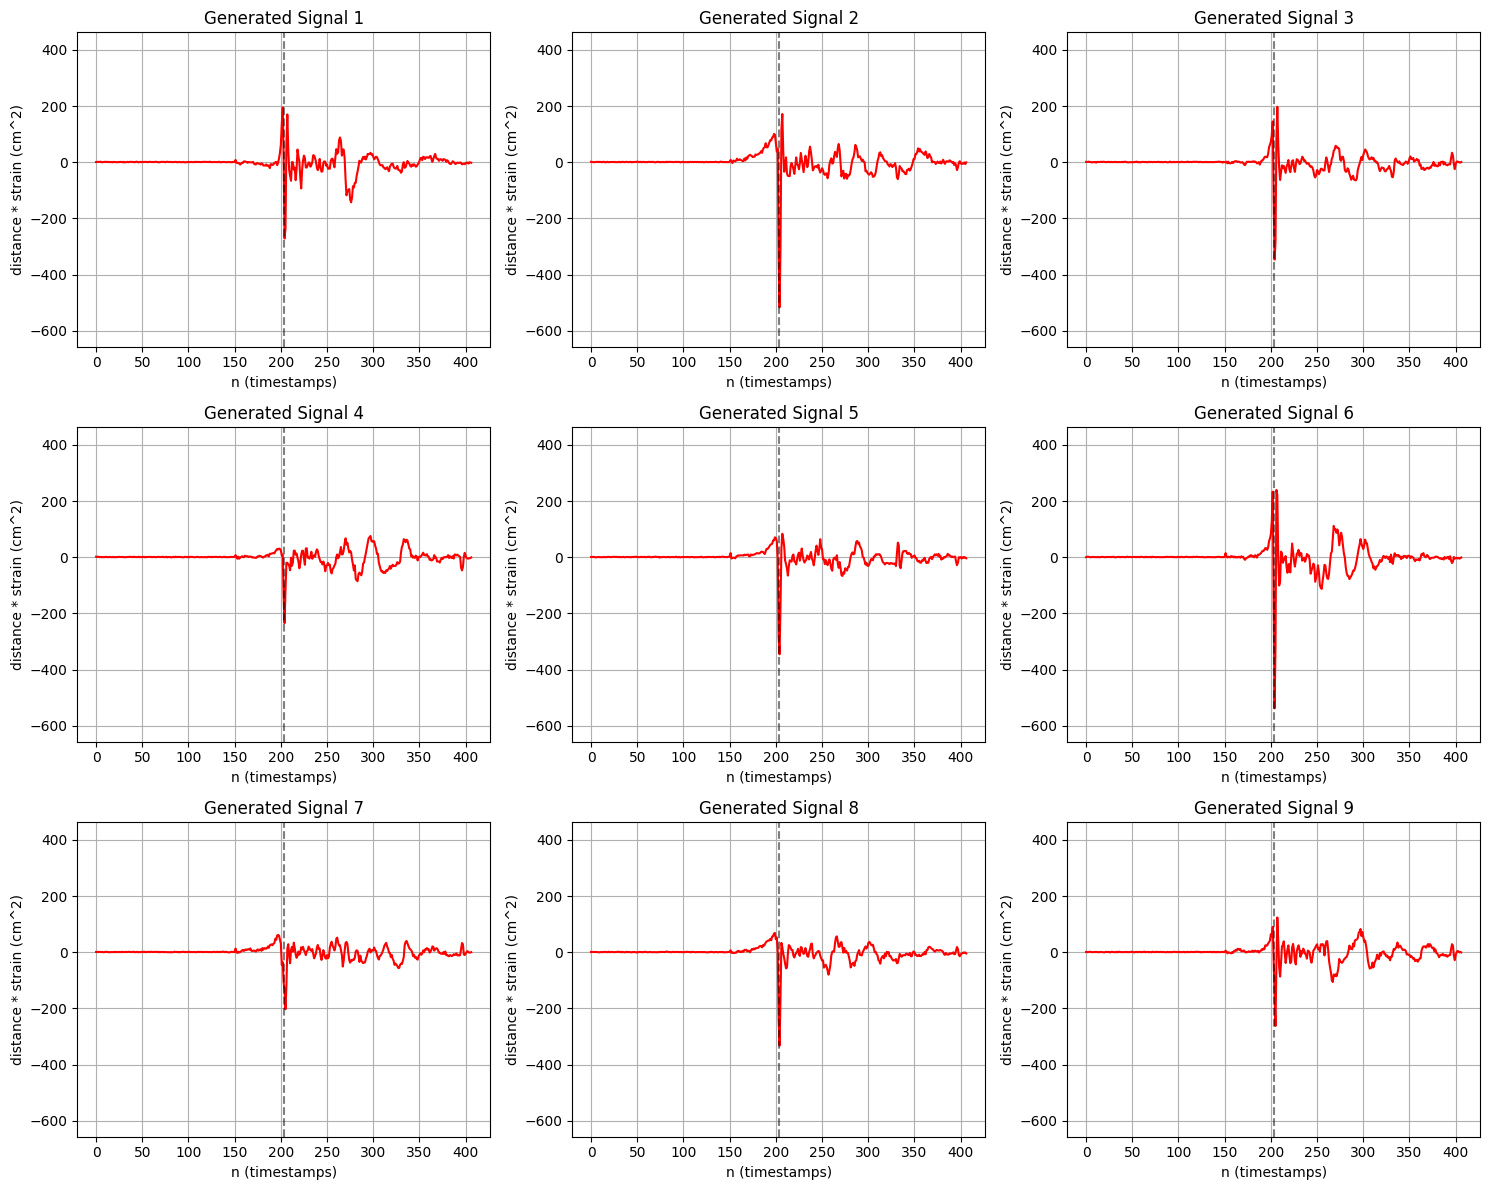

[12/32][0/188]	Loss_D: 0.5835	Loss_G: 2.3610	D(x): 0.9095	D(G(z)): 0.1186 / 0.1486
[12/32][50/188]	Loss_D: 0.5222	Loss_G: 1.7259	D(x): 0.9302	D(G(z)): 0.2010 / 0.2344
[12/32][100/188]	Loss_D: 0.5324	Loss_G: 1.8175	D(x): 0.9428	D(G(z)): 0.2039 / 0.2263
[12/32][150/188]	Loss_D: 0.4908	Loss_G: 1.7834	D(x): 0.9511	D(G(z)): 0.1948 / 0.2238
Epoch 12: SGD Discriminator lr 0.0000162 -> 0.0000159
Epoch 12: SGD Generator lr 0.0000162 -> 0.0000159


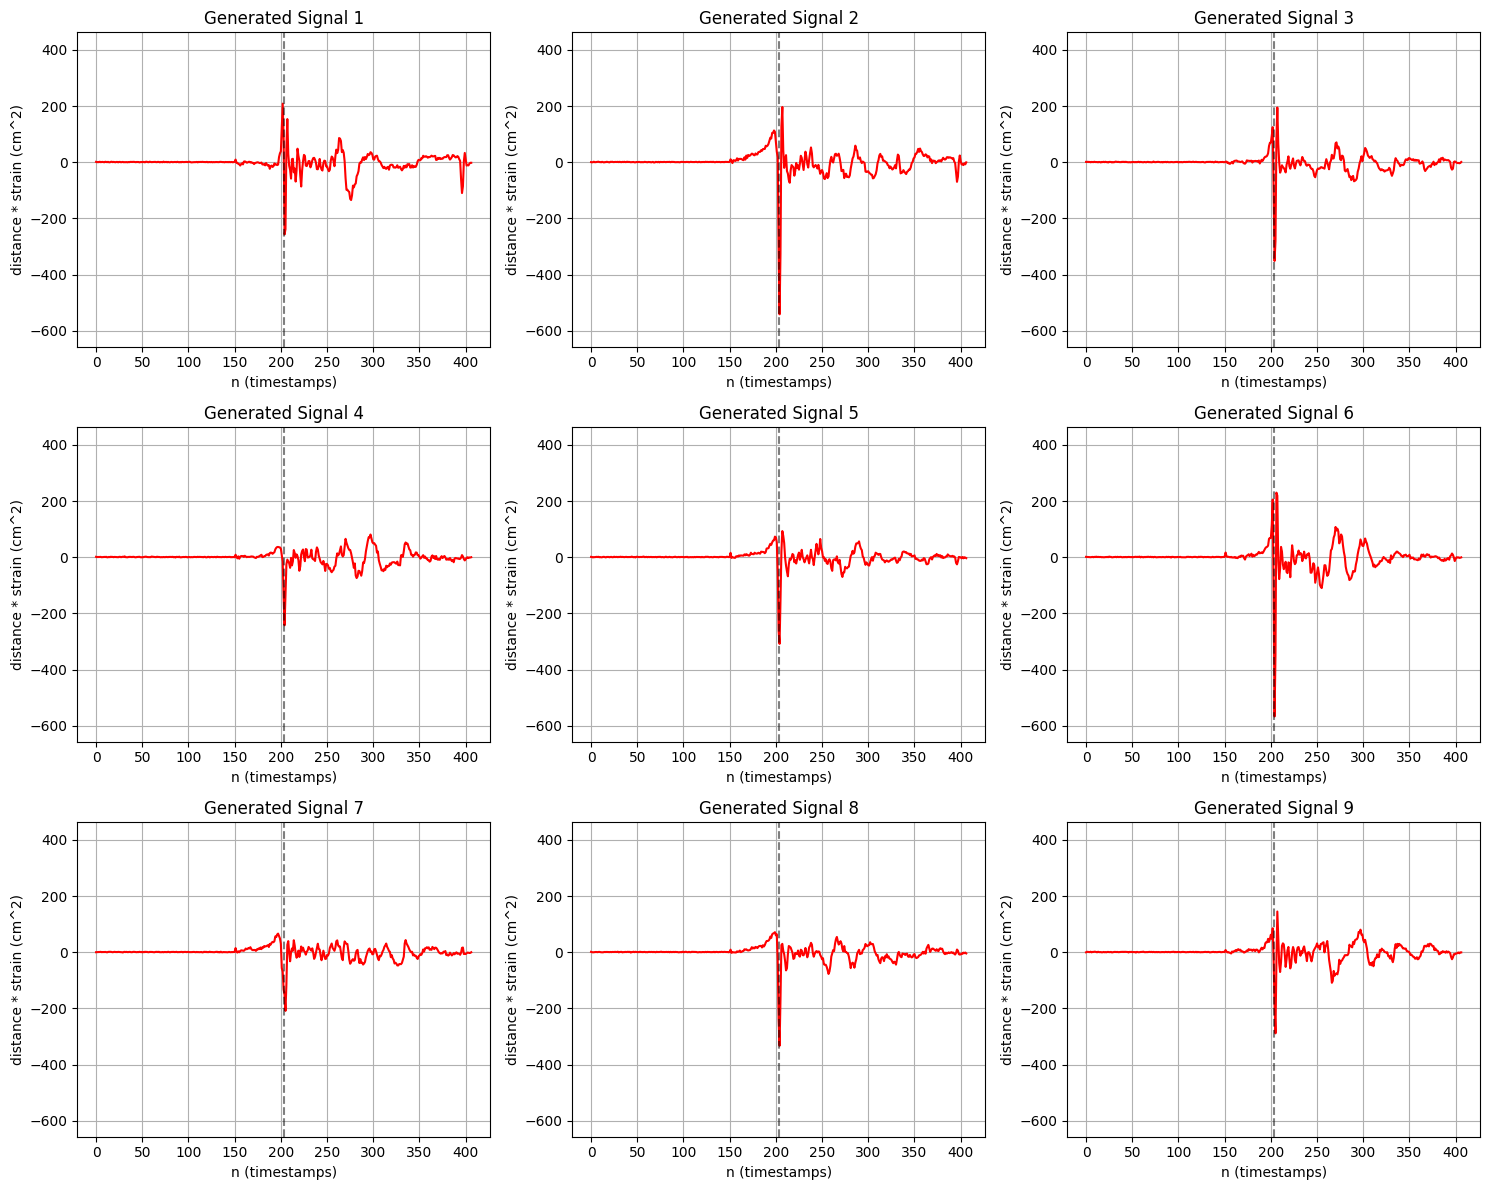

[13/32][0/188]	Loss_D: 0.5008	Loss_G: 1.8729	D(x): 0.9532	D(G(z)): 0.1725 / 0.2028
[13/32][50/188]	Loss_D: 0.5677	Loss_G: 1.7499	D(x): 0.9164	D(G(z)): 0.2683 / 0.2305
[13/32][100/188]	Loss_D: 0.4828	Loss_G: 1.9226	D(x): 0.9599	D(G(z)): 0.1972 / 0.1986
[13/32][150/188]	Loss_D: 0.5591	Loss_G: 2.2309	D(x): 0.9479	D(G(z)): 0.1238 / 0.1457
Epoch 13: SGD Discriminator lr 0.0000159 -> 0.0000156
Epoch 13: SGD Generator lr 0.0000159 -> 0.0000156


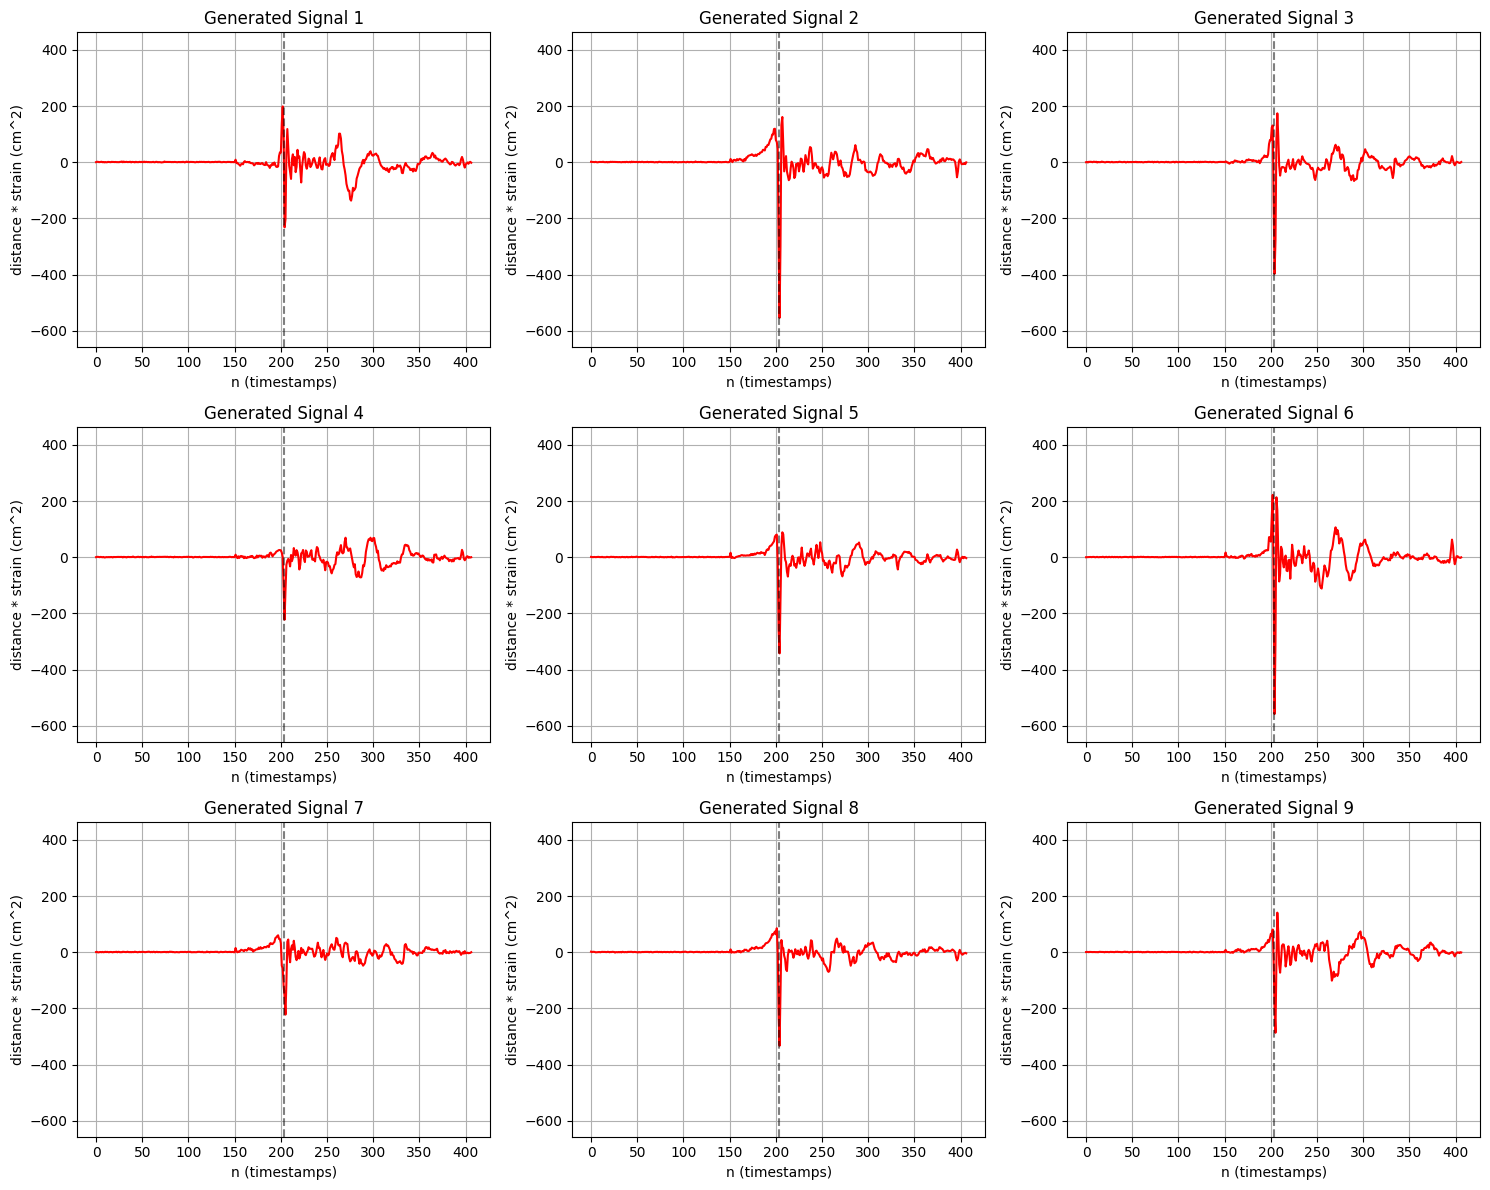

[14/32][0/188]	Loss_D: 0.6086	Loss_G: 1.7214	D(x): 0.9444	D(G(z)): 0.2920 / 0.2455
[14/32][50/188]	Loss_D: 0.4993	Loss_G: 2.0482	D(x): 0.9655	D(G(z)): 0.1974 / 0.2040
[14/32][100/188]	Loss_D: 0.4847	Loss_G: 2.2479	D(x): 0.9560	D(G(z)): 0.1492 / 0.1510
[14/32][150/188]	Loss_D: 0.5257	Loss_G: 2.1085	D(x): 0.9591	D(G(z)): 0.2176 / 0.1840
Epoch 14: SGD Discriminator lr 0.0000156 -> 0.0000153
Epoch 14: SGD Generator lr 0.0000156 -> 0.0000153


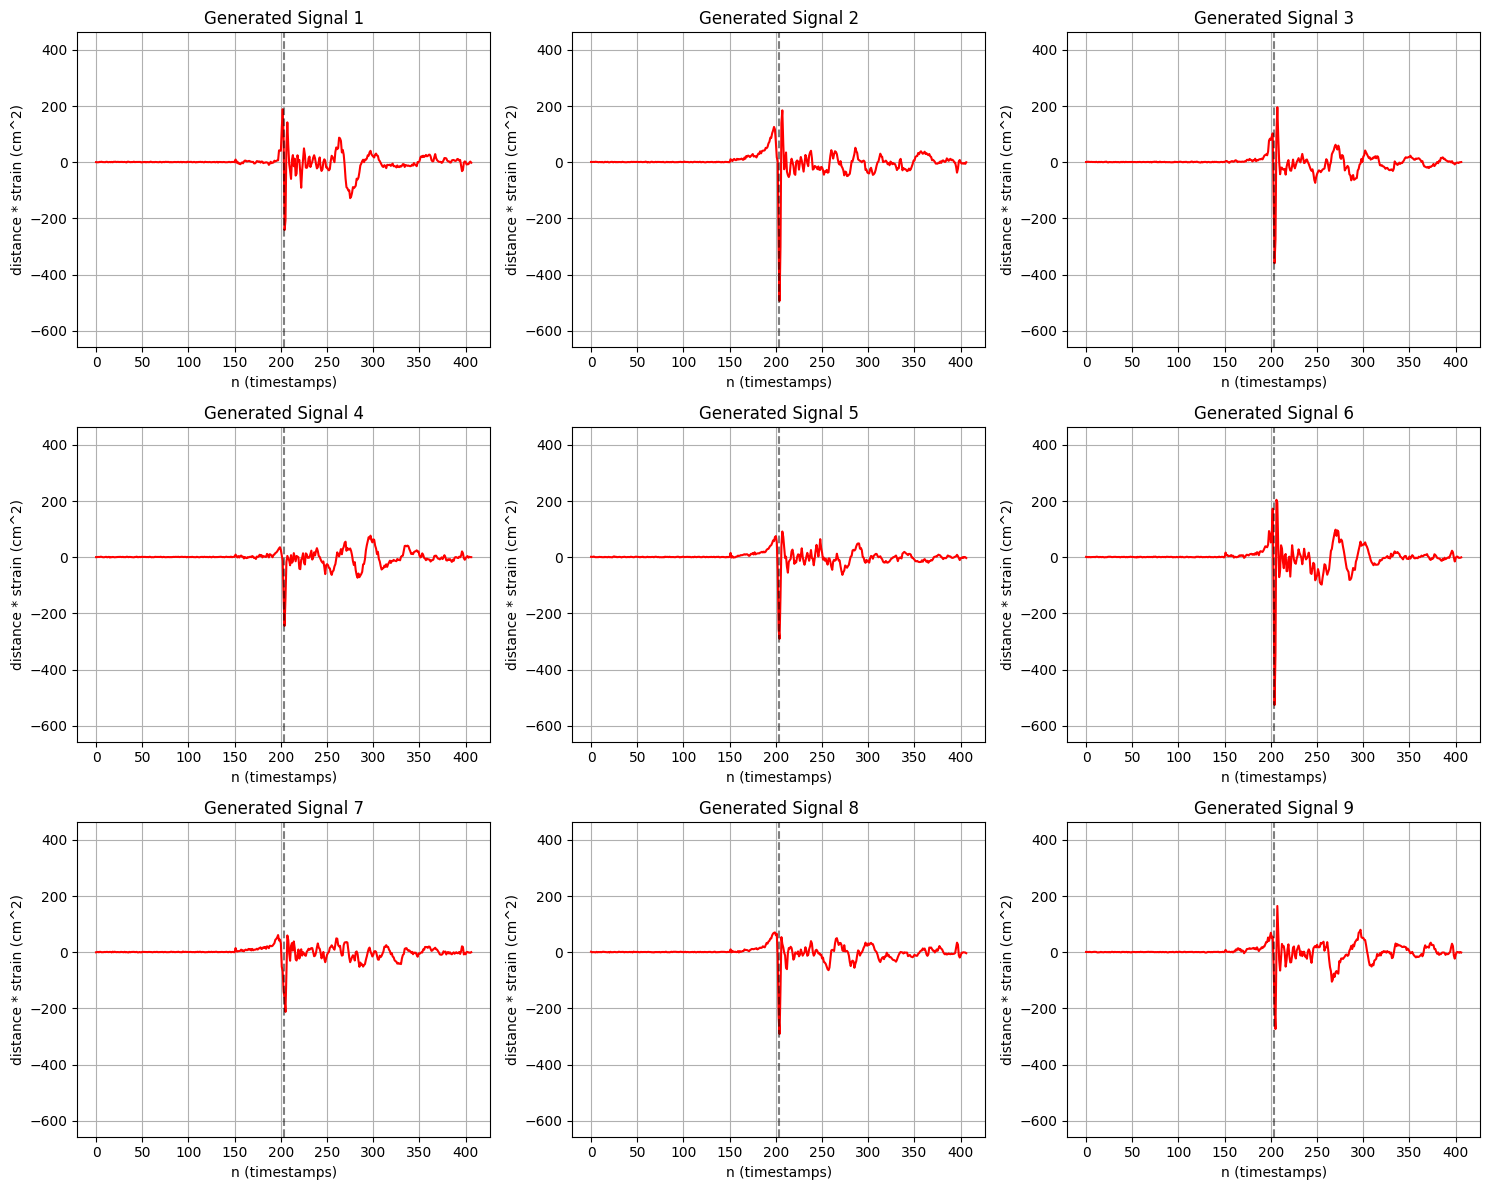

[15/32][0/188]	Loss_D: 0.4665	Loss_G: 1.8587	D(x): 0.9515	D(G(z)): 0.1991 / 0.1991
[15/32][50/188]	Loss_D: 0.5010	Loss_G: 2.2479	D(x): 0.9430	D(G(z)): 0.1561 / 0.1764
[15/32][100/188]	Loss_D: 0.5931	Loss_G: 1.6020	D(x): 0.9559	D(G(z)): 0.3024 / 0.2455
[15/32][150/188]	Loss_D: 0.4462	Loss_G: 2.3910	D(x): 0.9514	D(G(z)): 0.1224 / 0.1295
Epoch 15: SGD Discriminator lr 0.0000153 -> 0.0000150
Epoch 15: SGD Generator lr 0.0000153 -> 0.0000150


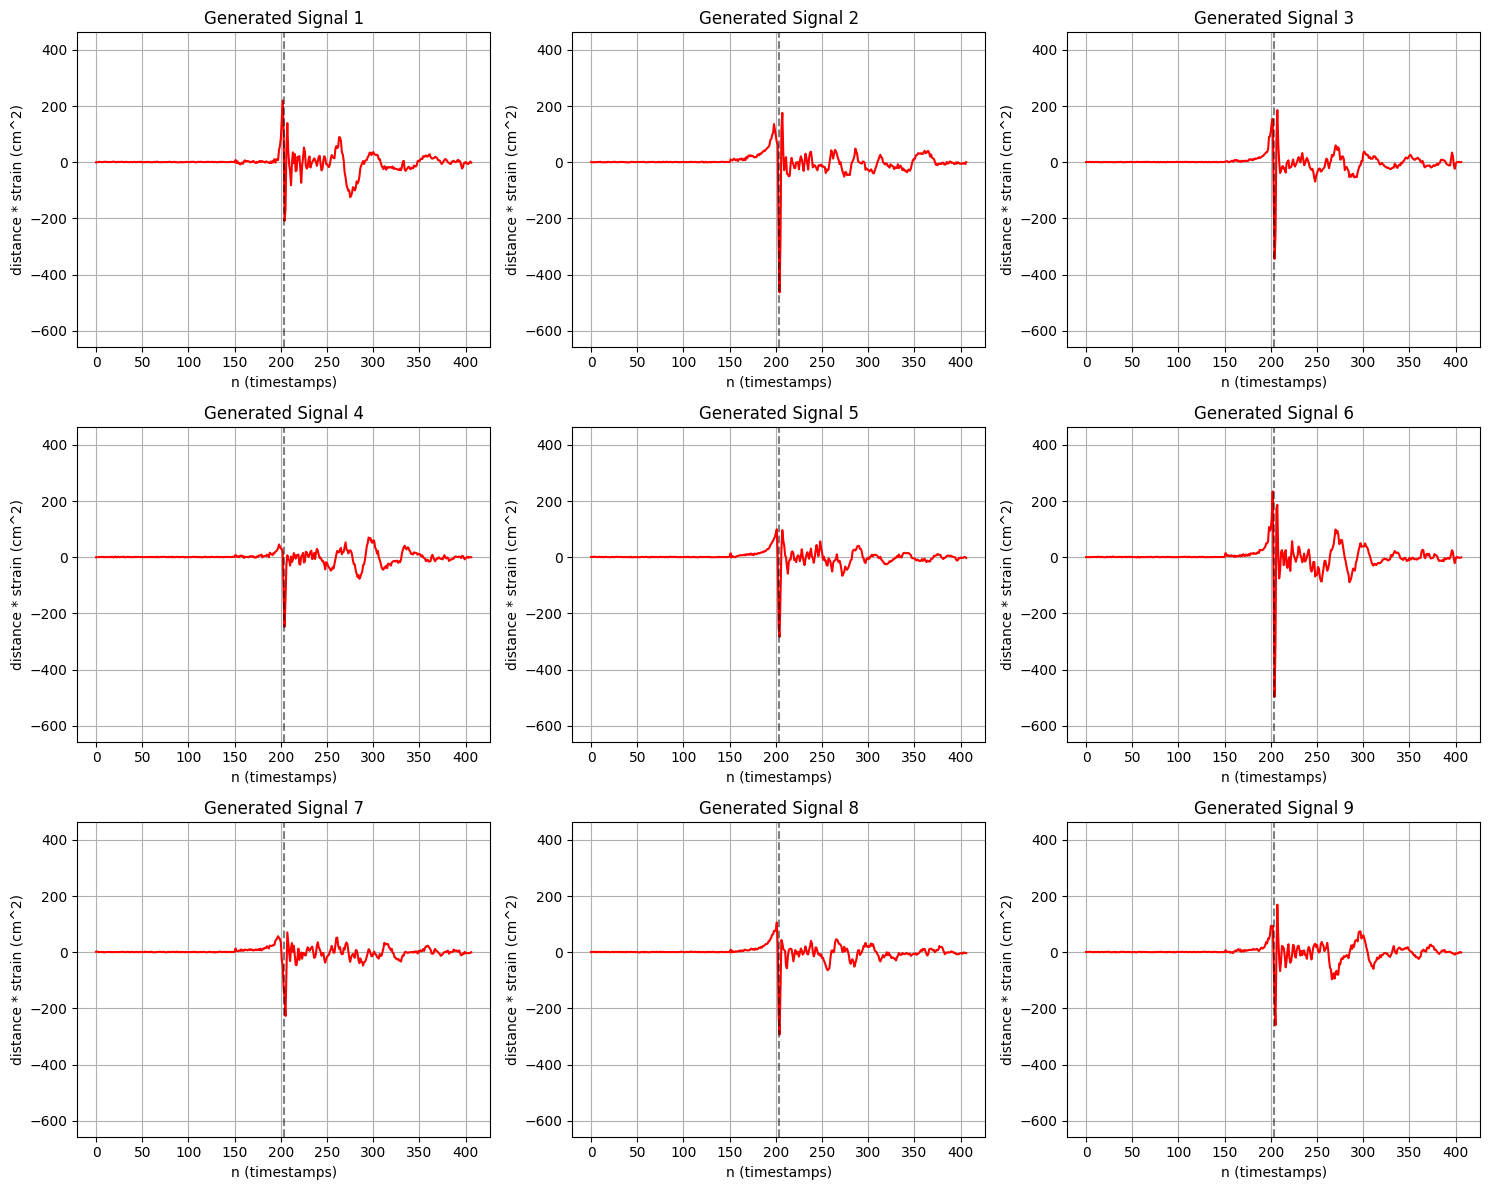

[16/32][0/188]	Loss_D: 0.4912	Loss_G: 1.7589	D(x): 0.9522	D(G(z)): 0.1809 / 0.2361
[16/32][50/188]	Loss_D: 0.5194	Loss_G: 2.5422	D(x): 0.9316	D(G(z)): 0.1304 / 0.1175
[16/32][100/188]	Loss_D: 0.5461	Loss_G: 1.7240	D(x): 0.9119	D(G(z)): 0.2038 / 0.2316
[16/32][150/188]	Loss_D: 0.5422	Loss_G: 1.9000	D(x): 0.9661	D(G(z)): 0.2669 / 0.2075
Epoch 16: SGD Discriminator lr 0.0000150 -> 0.0000147
Epoch 16: SGD Generator lr 0.0000150 -> 0.0000147


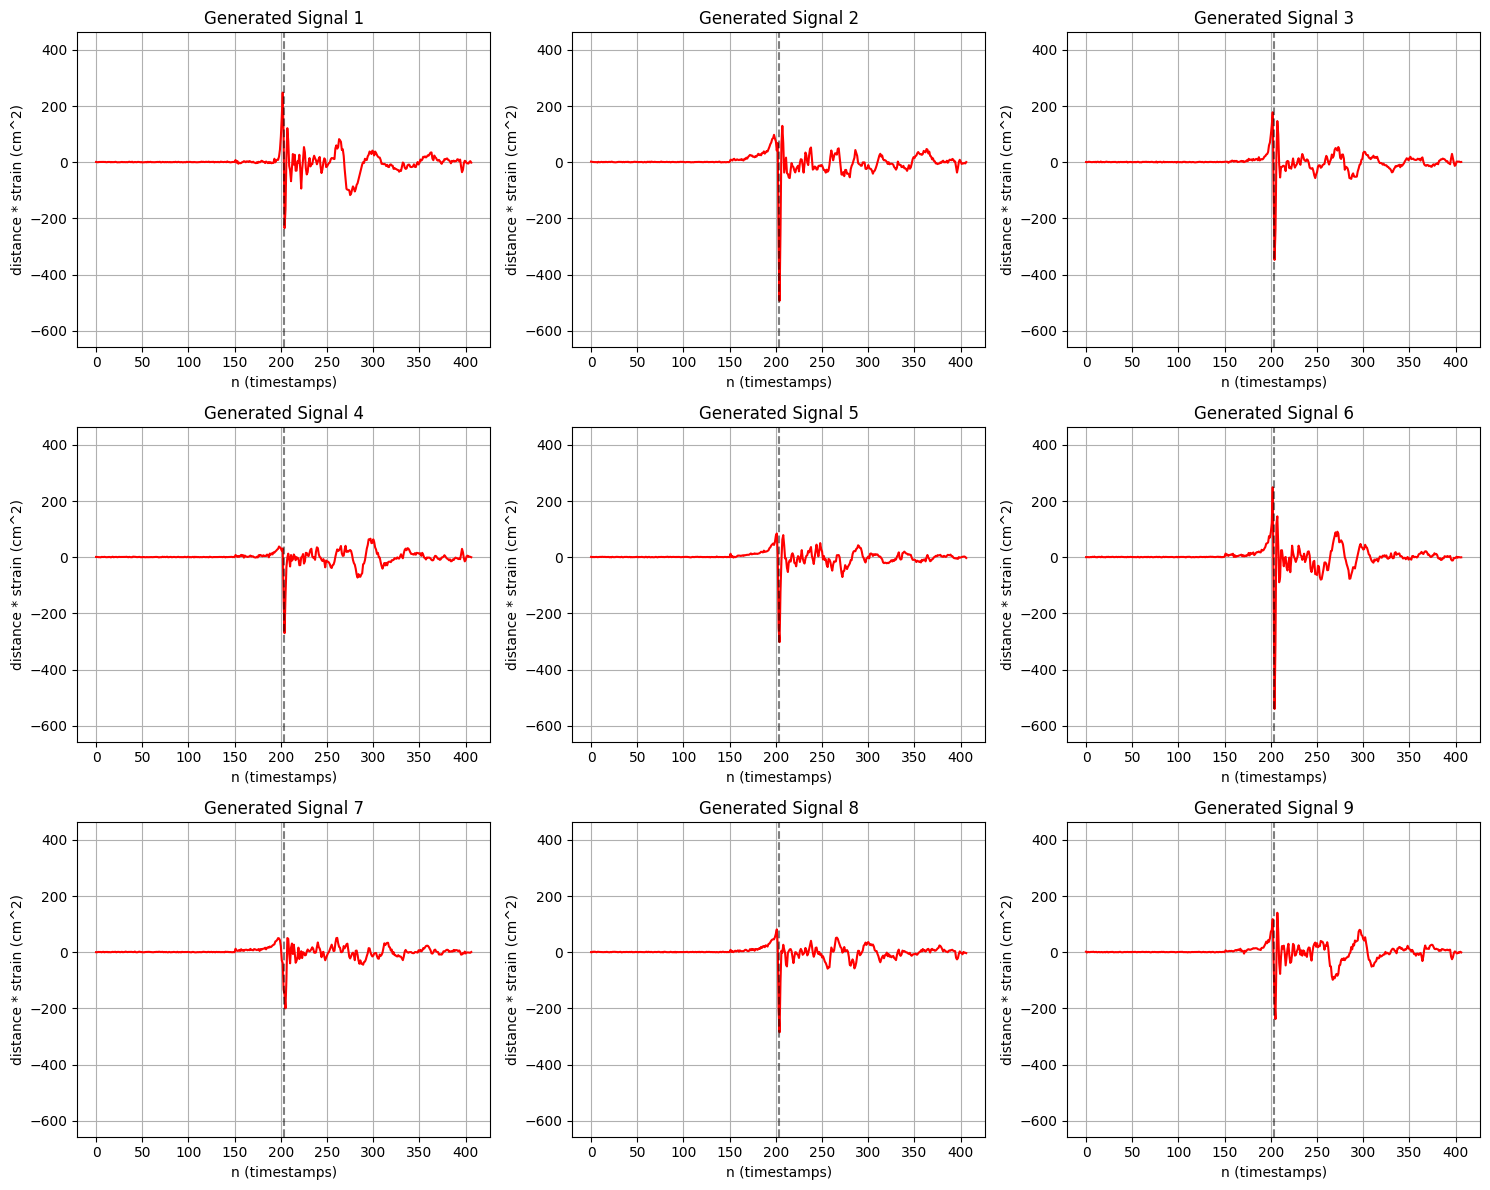

[17/32][0/188]	Loss_D: 0.6446	Loss_G: 1.3883	D(x): 0.9321	D(G(z)): 0.3042 / 0.3172
[17/32][50/188]	Loss_D: 0.5104	Loss_G: 2.0814	D(x): 0.9557	D(G(z)): 0.1722 / 0.1759
[17/32][100/188]	Loss_D: 0.5097	Loss_G: 2.0710	D(x): 0.9369	D(G(z)): 0.2033 / 0.1657
[17/32][150/188]	Loss_D: 0.4890	Loss_G: 2.1650	D(x): 0.9305	D(G(z)): 0.1604 / 0.1414
Epoch 17: SGD Discriminator lr 0.0000147 -> 0.0000144
Epoch 17: SGD Generator lr 0.0000147 -> 0.0000144


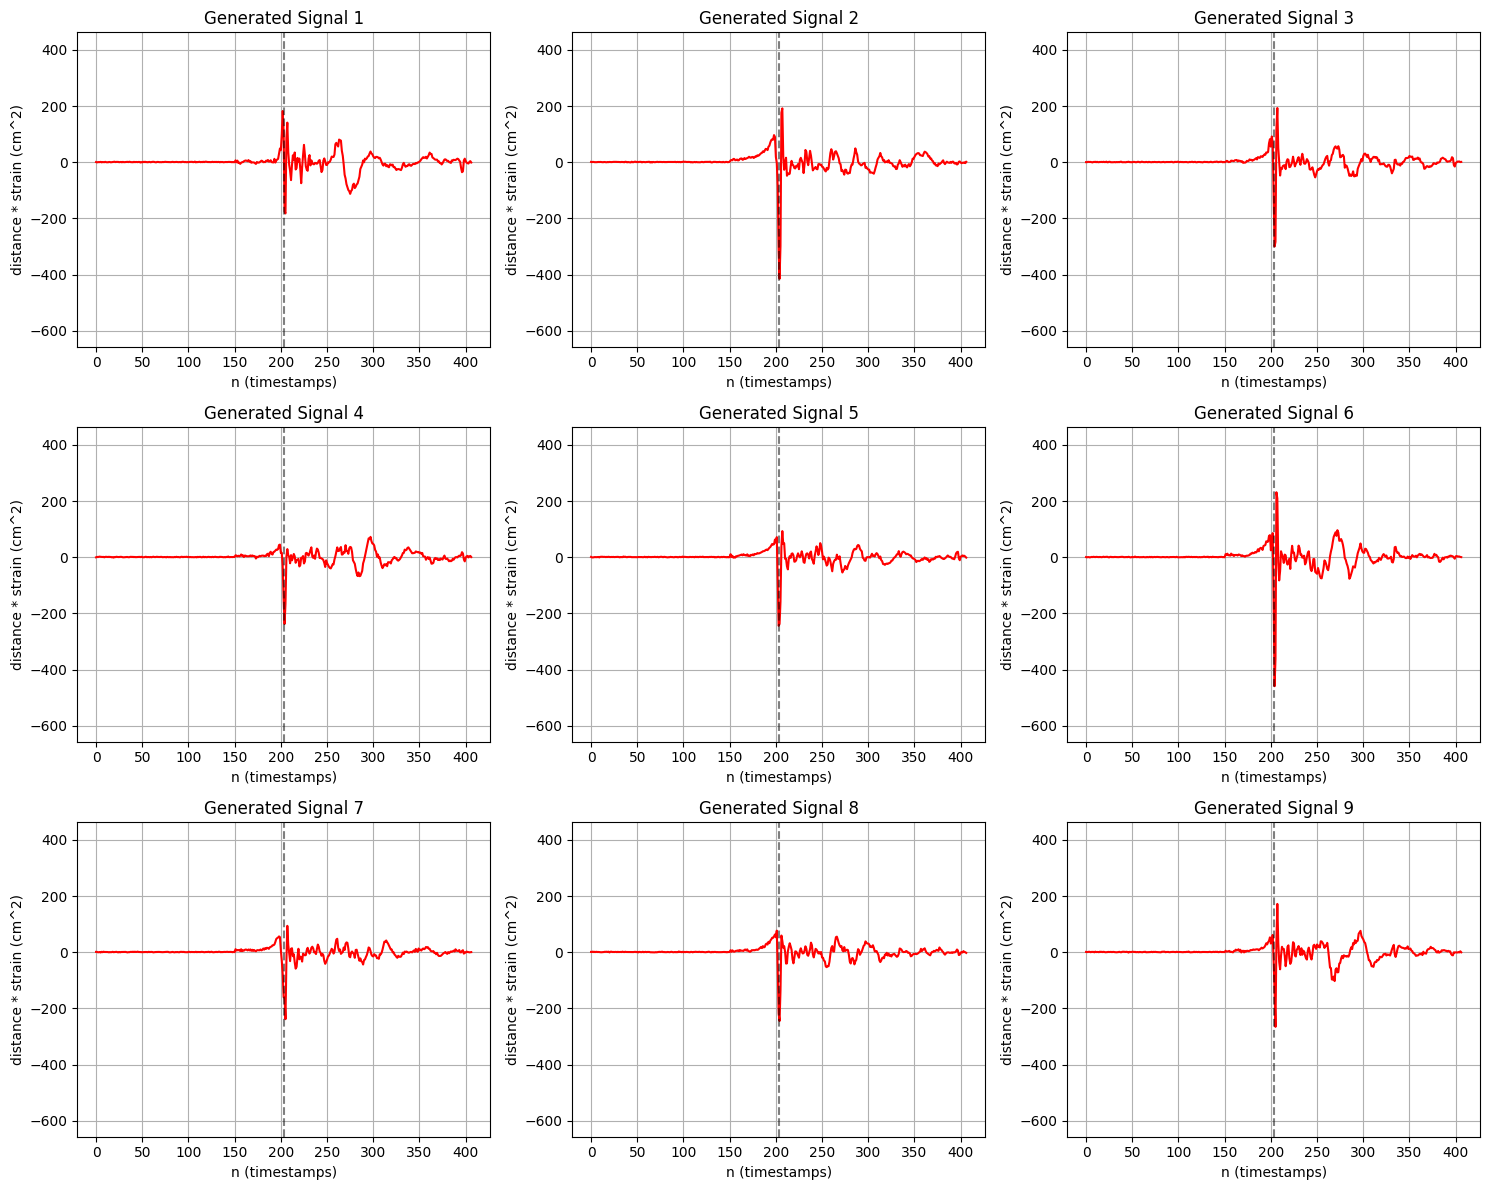

[18/32][0/188]	Loss_D: 0.4791	Loss_G: 2.4181	D(x): 0.9604	D(G(z)): 0.1414 / 0.1313
[18/32][50/188]	Loss_D: 0.4533	Loss_G: 1.8760	D(x): 0.9708	D(G(z)): 0.1841 / 0.2065
[18/32][100/188]	Loss_D: 0.4823	Loss_G: 2.2584	D(x): 0.9556	D(G(z)): 0.1694 / 0.1322
[18/32][150/188]	Loss_D: 0.5502	Loss_G: 2.0374	D(x): 0.9354	D(G(z)): 0.1627 / 0.1785
Epoch 18: SGD Discriminator lr 0.0000144 -> 0.0000141
Epoch 18: SGD Generator lr 0.0000144 -> 0.0000141


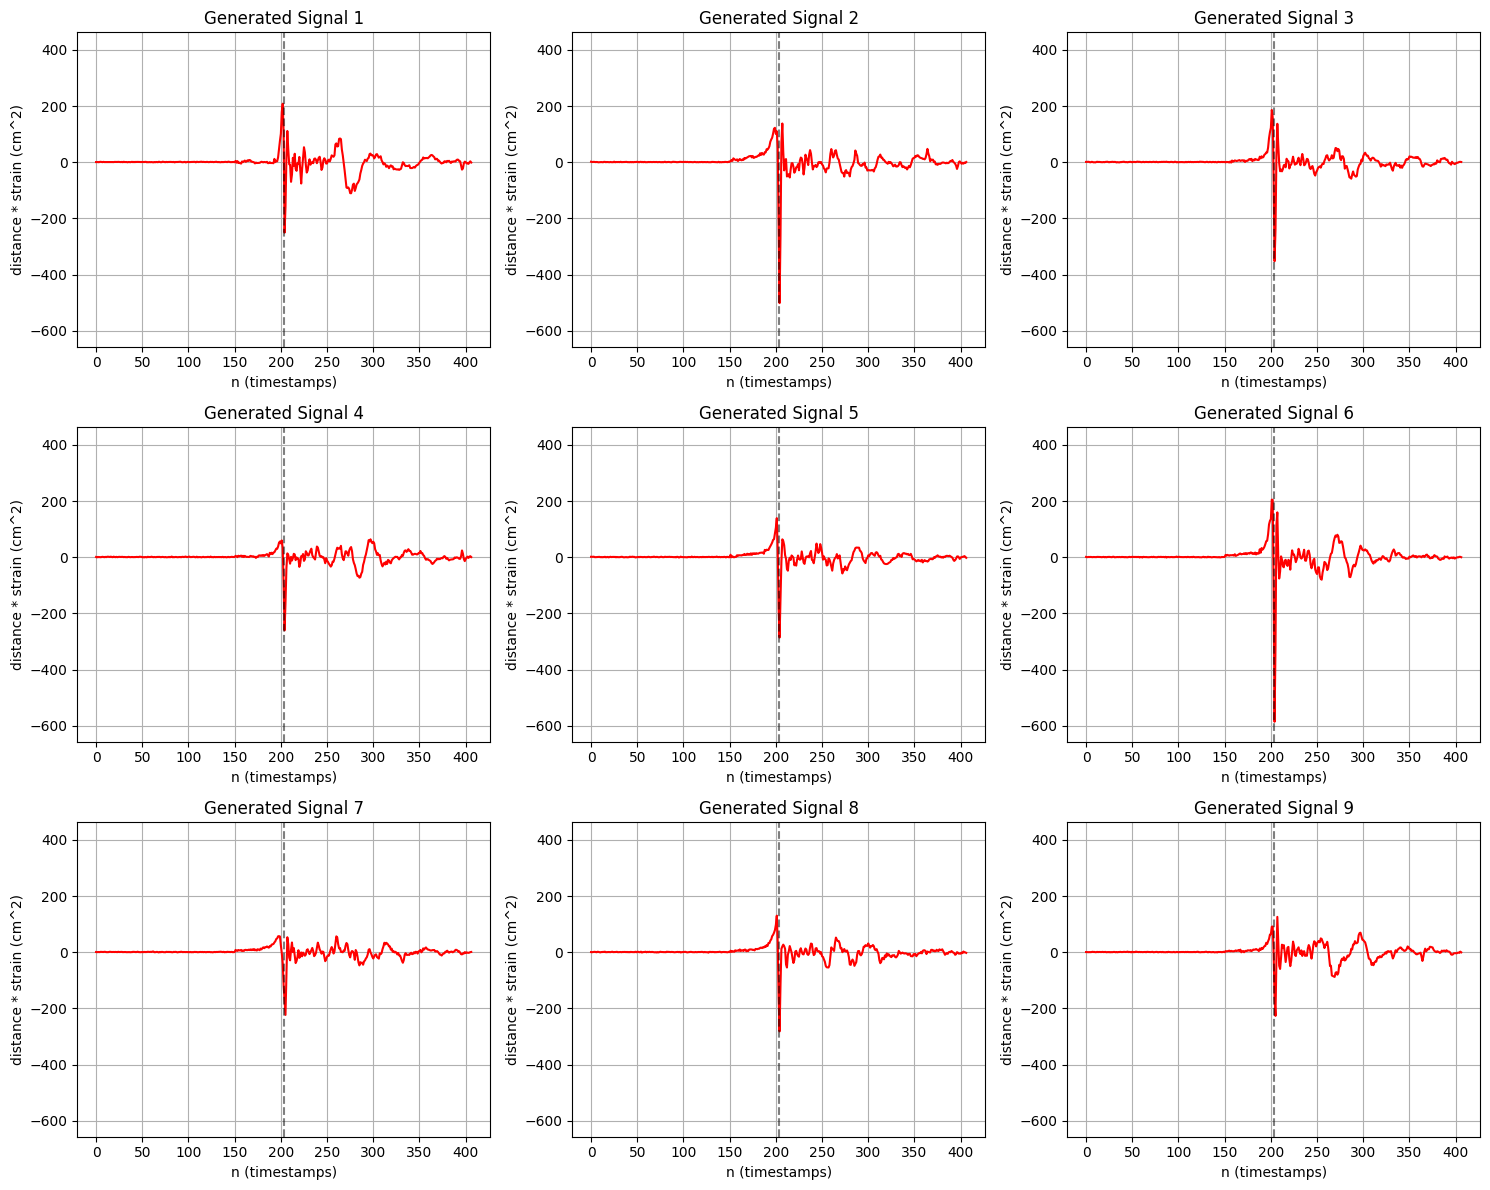

[19/32][0/188]	Loss_D: 0.4257	Loss_G: 1.9331	D(x): 0.9606	D(G(z)): 0.1439 / 0.1934
[19/32][50/188]	Loss_D: 0.4780	Loss_G: 2.4886	D(x): 0.9427	D(G(z)): 0.0840 / 0.1225
[19/32][100/188]	Loss_D: 0.4860	Loss_G: 1.7763	D(x): 0.9639	D(G(z)): 0.1432 / 0.2170
[19/32][150/188]	Loss_D: 0.4584	Loss_G: 2.1196	D(x): 0.9521	D(G(z)): 0.1509 / 0.1668
Epoch 19: SGD Discriminator lr 0.0000141 -> 0.0000137
Epoch 19: SGD Generator lr 0.0000141 -> 0.0000137


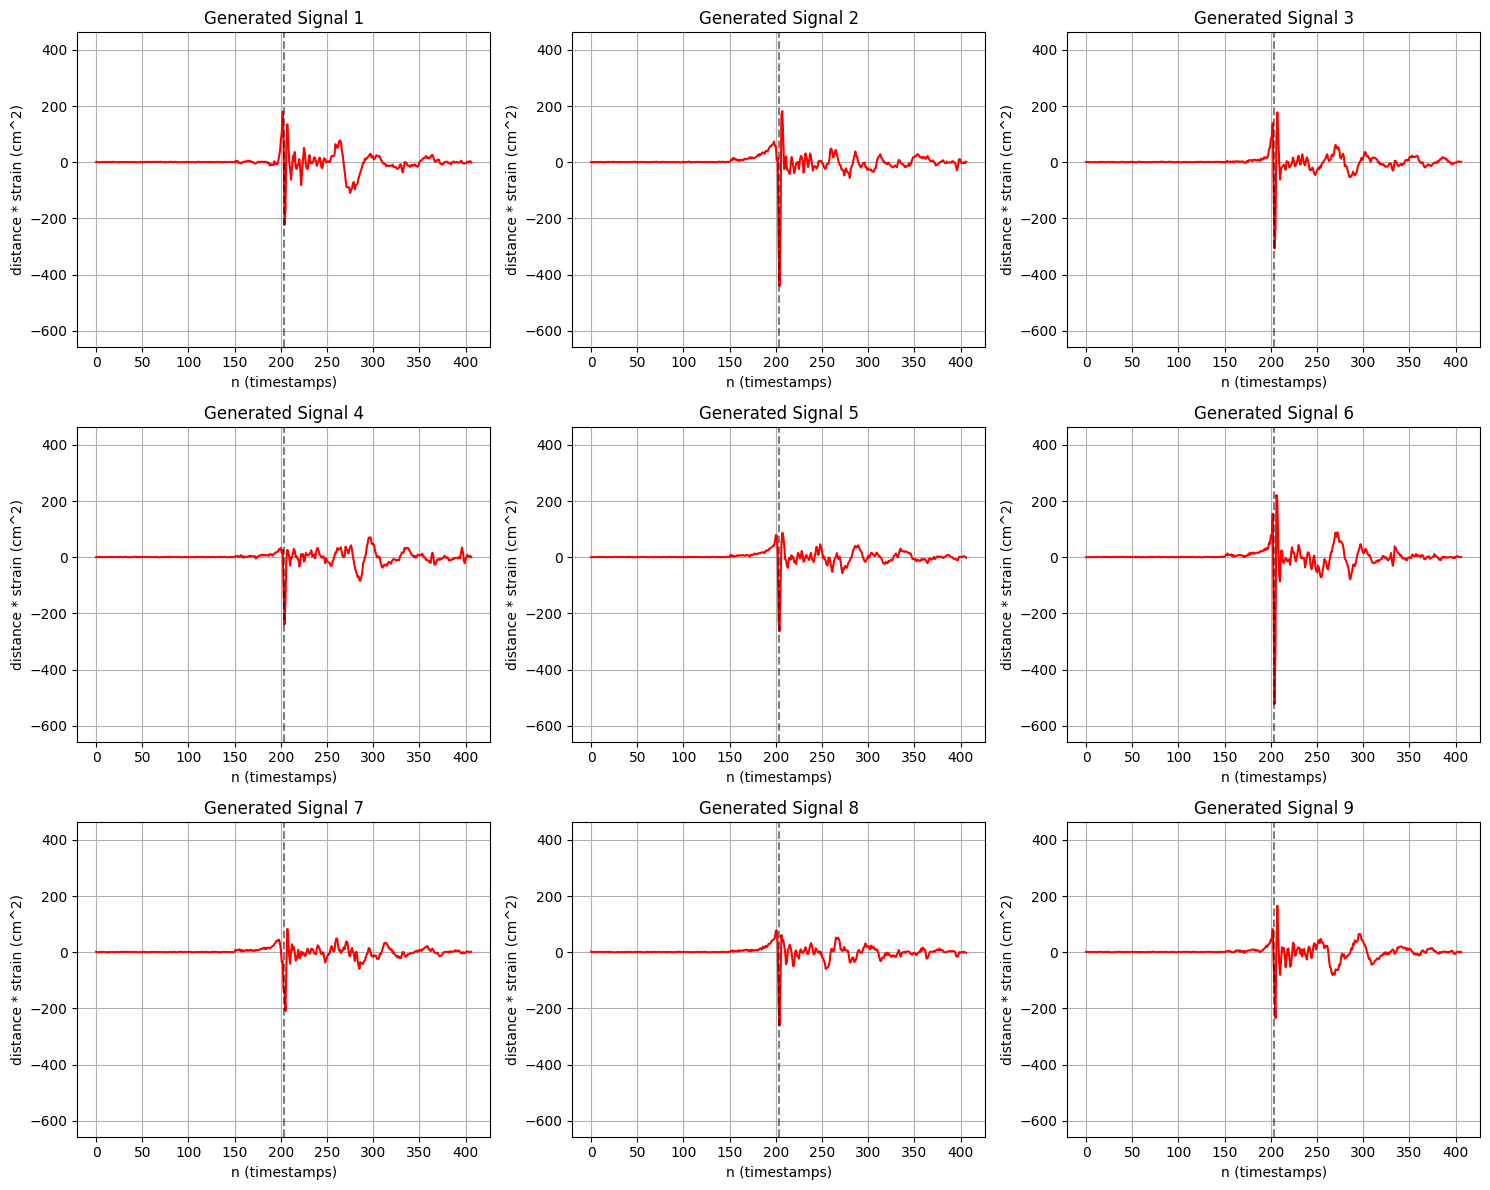

[20/32][0/188]	Loss_D: 0.4983	Loss_G: 2.5400	D(x): 0.9571	D(G(z)): 0.1298 / 0.1210
[20/32][50/188]	Loss_D: 0.5956	Loss_G: 2.0969	D(x): 0.9298	D(G(z)): 0.1810 / 0.1951
[20/32][100/188]	Loss_D: 0.5633	Loss_G: 2.2765	D(x): 0.9026	D(G(z)): 0.1716 / 0.1559
[20/32][150/188]	Loss_D: 0.4746	Loss_G: 2.0719	D(x): 0.9802	D(G(z)): 0.2112 / 0.1501
Epoch 20: SGD Discriminator lr 0.0000137 -> 0.0000134
Epoch 20: SGD Generator lr 0.0000137 -> 0.0000134


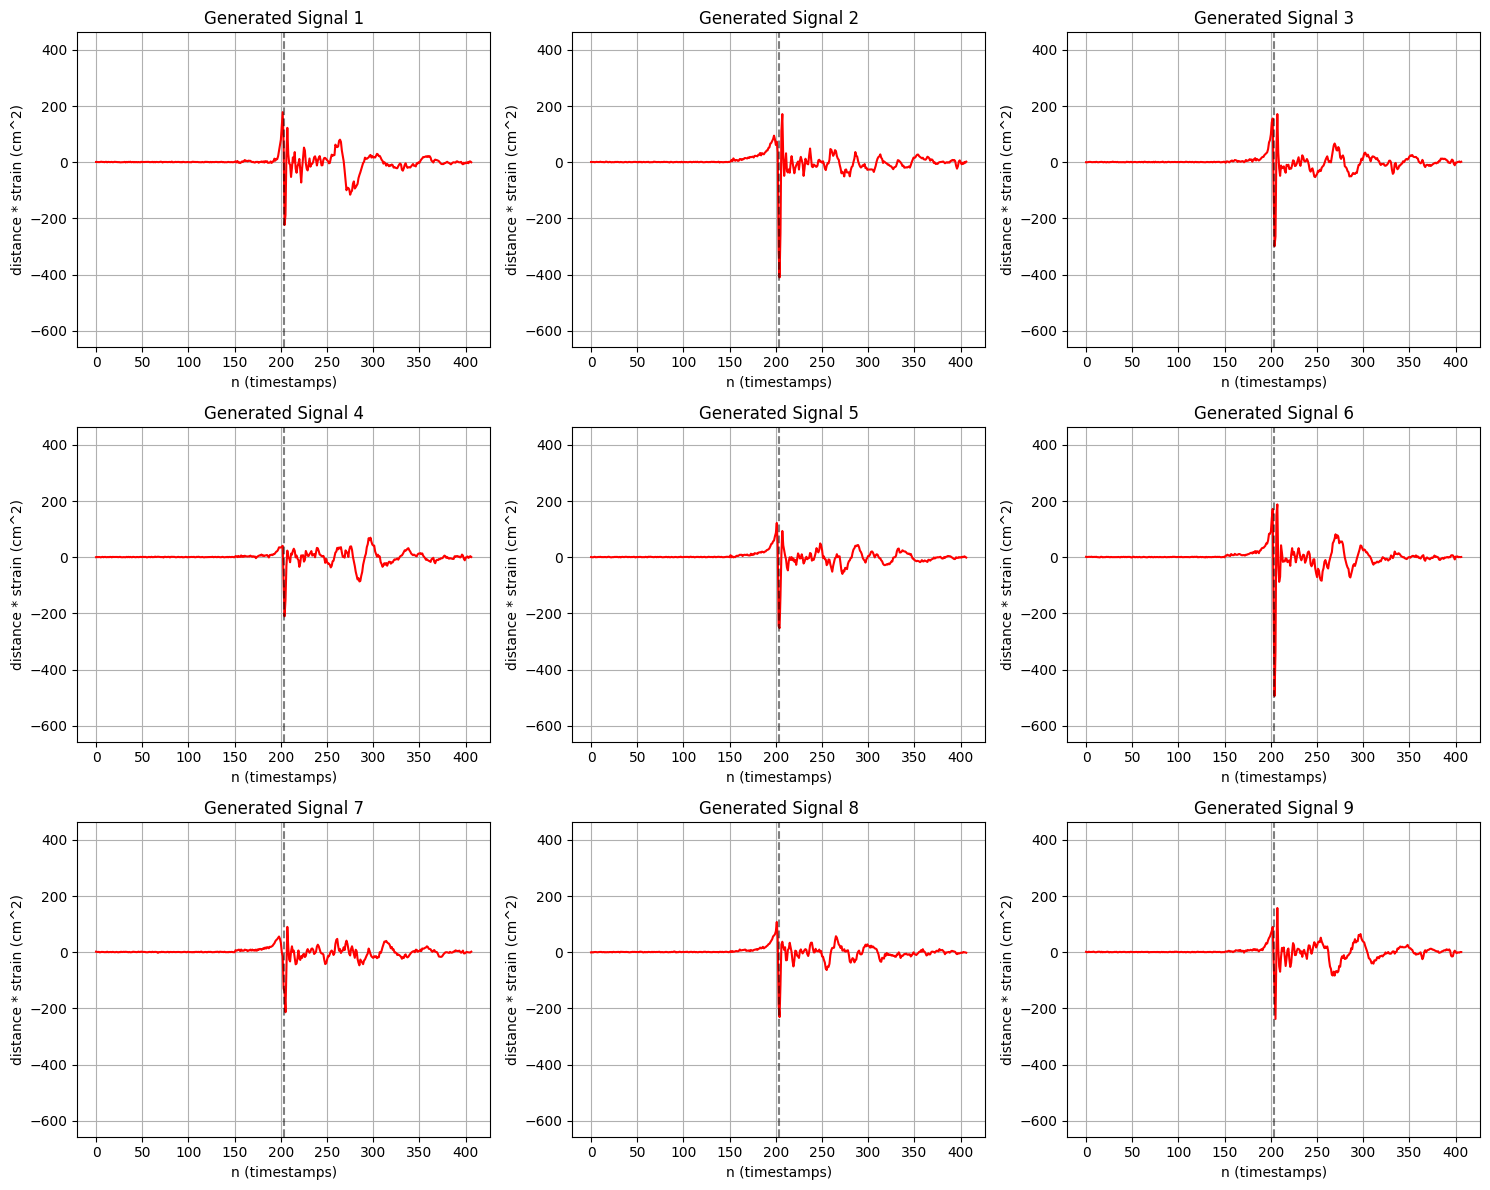

[21/32][0/188]	Loss_D: 0.4627	Loss_G: 2.4334	D(x): 0.9599	D(G(z)): 0.1417 / 0.1363
[21/32][50/188]	Loss_D: 0.5560	Loss_G: 2.3575	D(x): 0.9226	D(G(z)): 0.1596 / 0.1523
[21/32][100/188]	Loss_D: 0.4686	Loss_G: 2.2578	D(x): 0.9585	D(G(z)): 0.1529 / 0.1384
[21/32][150/188]	Loss_D: 0.5383	Loss_G: 1.7827	D(x): 0.9527	D(G(z)): 0.2003 / 0.2379
Epoch 21: SGD Discriminator lr 0.0000134 -> 0.0000131
Epoch 21: SGD Generator lr 0.0000134 -> 0.0000131


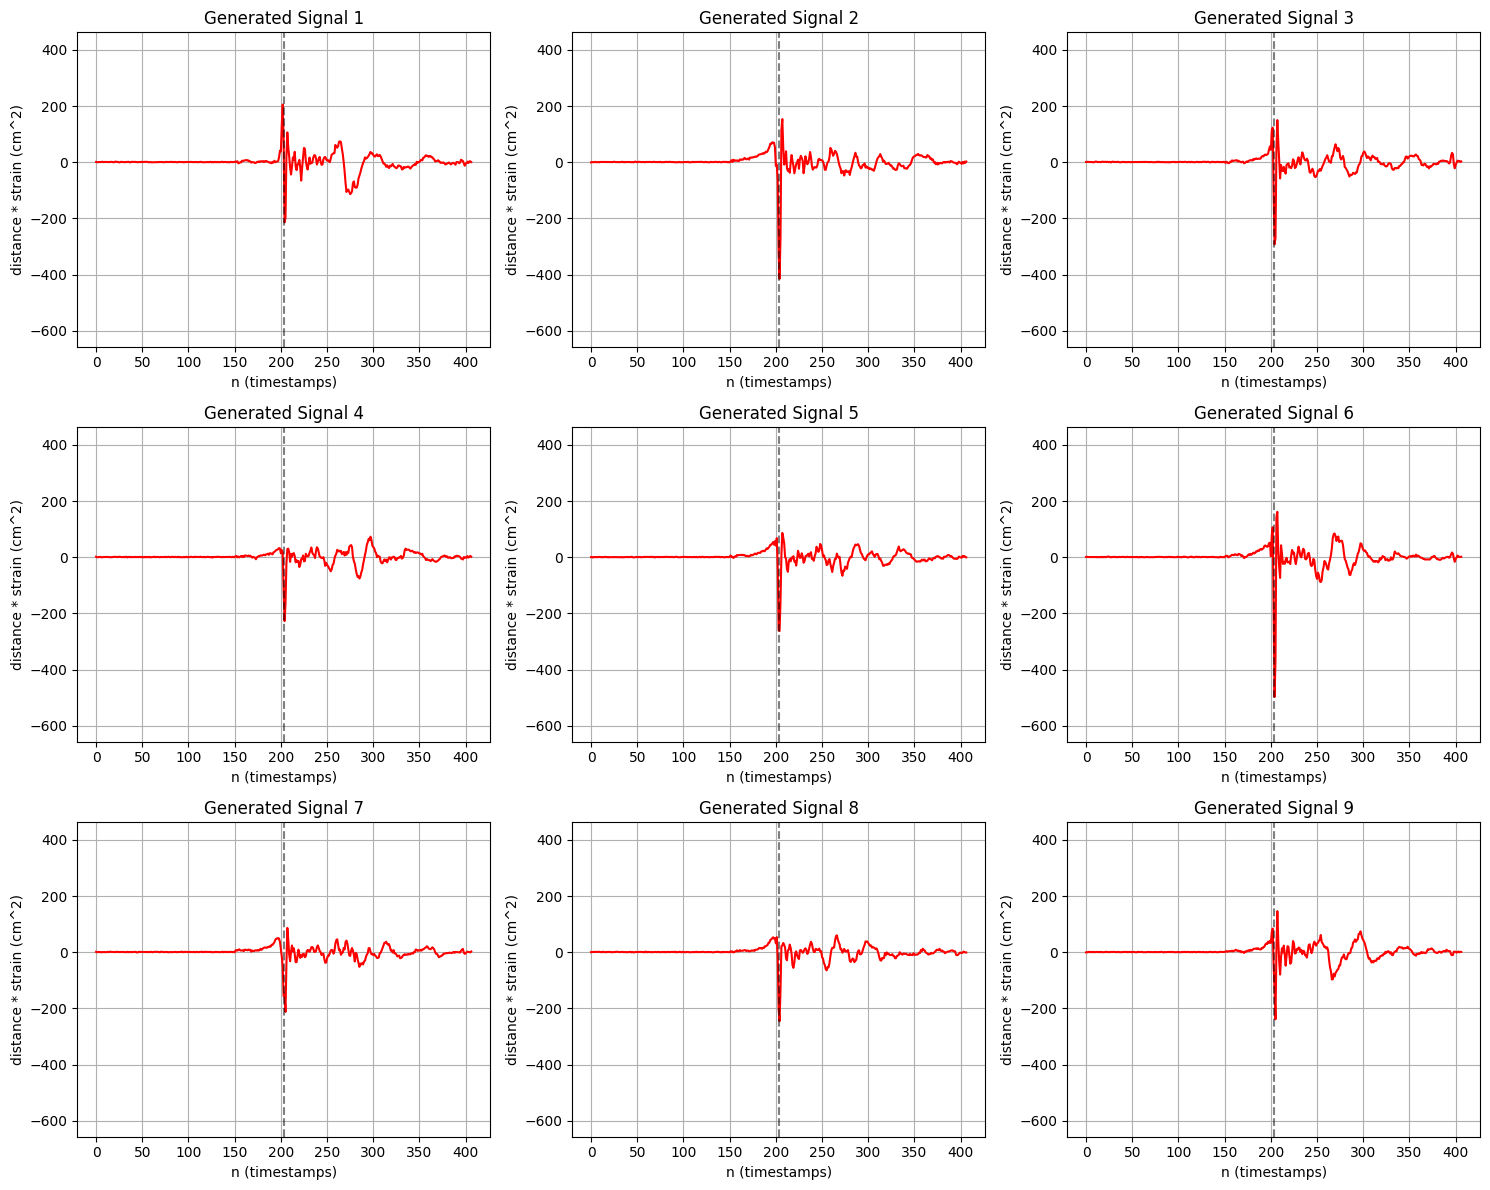

[22/32][0/188]	Loss_D: 0.4726	Loss_G: 1.9202	D(x): 0.9334	D(G(z)): 0.1689 / 0.1933
[22/32][50/188]	Loss_D: 0.6324	Loss_G: 2.7250	D(x): 0.9011	D(G(z)): 0.0878 / 0.0962
[22/32][100/188]	Loss_D: 0.4790	Loss_G: 2.2407	D(x): 0.9517	D(G(z)): 0.1730 / 0.1510
[22/32][150/188]	Loss_D: 0.5056	Loss_G: 2.4023	D(x): 0.9675	D(G(z)): 0.1495 / 0.1543
Epoch 22: SGD Discriminator lr 0.0000131 -> 0.0000128
Epoch 22: SGD Generator lr 0.0000131 -> 0.0000128


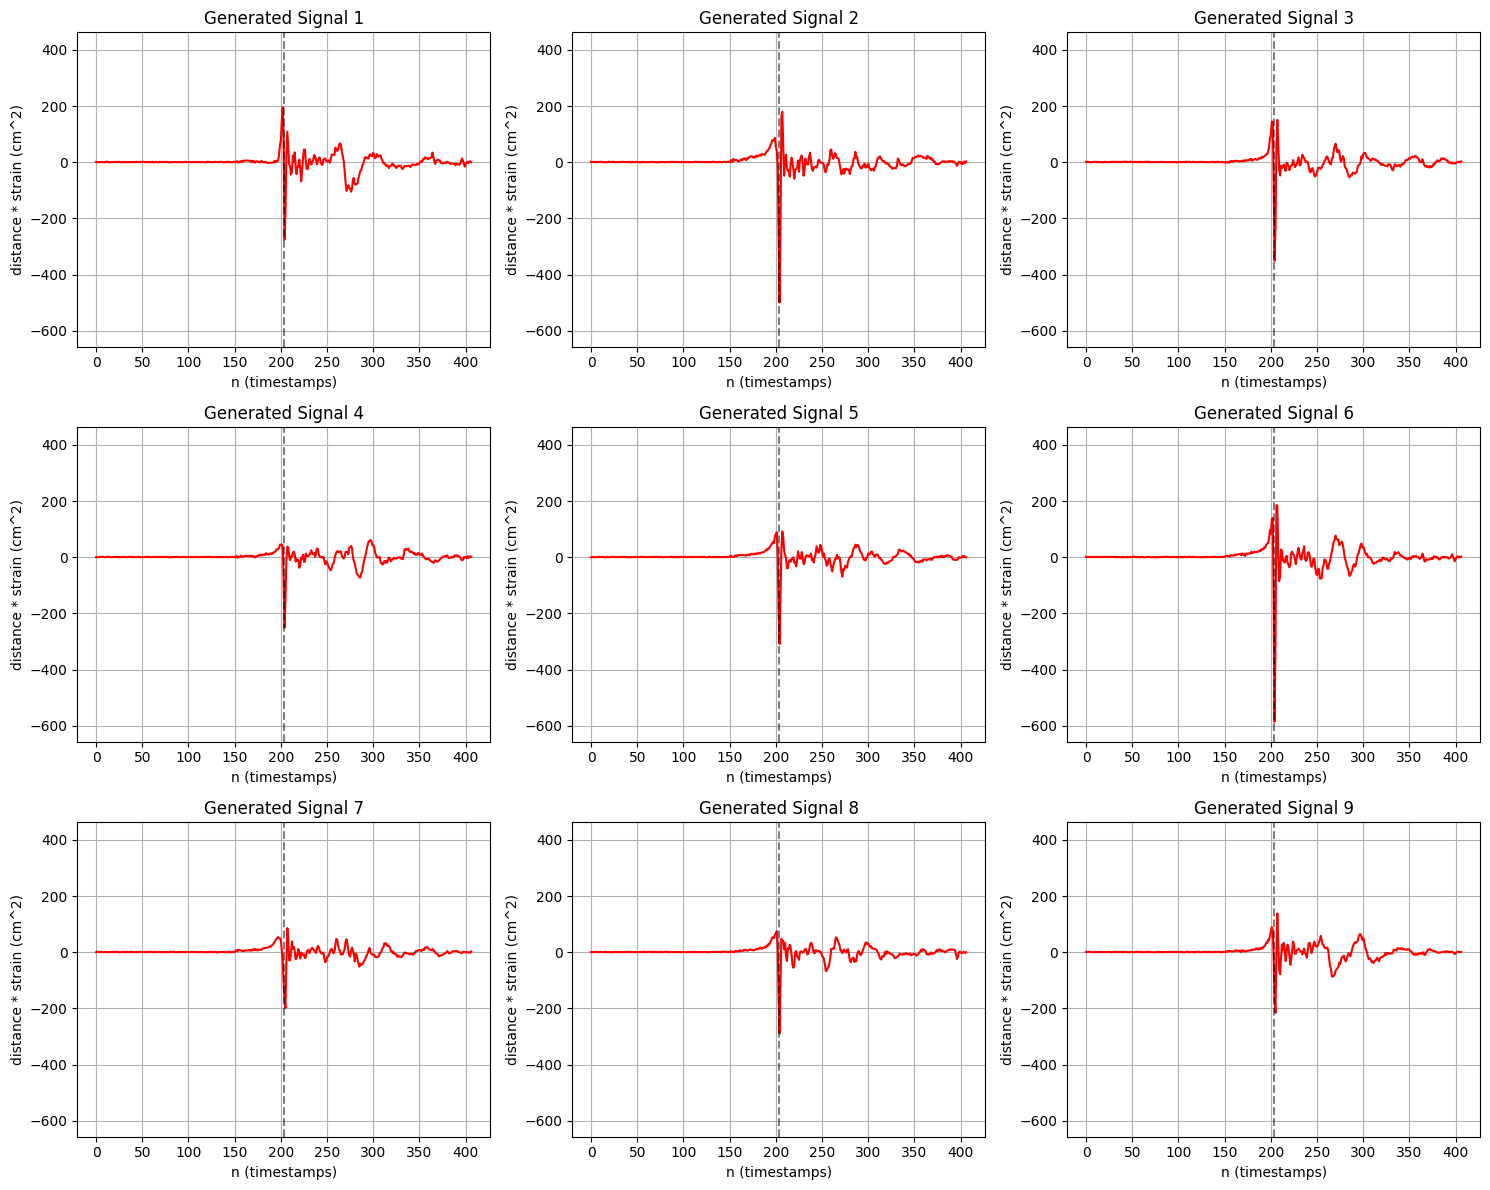

[23/32][0/188]	Loss_D: 0.5308	Loss_G: 2.1412	D(x): 0.9530	D(G(z)): 0.2587 / 0.1647
[23/32][50/188]	Loss_D: 0.4645	Loss_G: 1.9011	D(x): 0.9575	D(G(z)): 0.1765 / 0.2003
[23/32][100/188]	Loss_D: 0.6127	Loss_G: 1.5504	D(x): 0.9085	D(G(z)): 0.3016 / 0.2698
[23/32][150/188]	Loss_D: 0.5426	Loss_G: 1.9451	D(x): 0.9451	D(G(z)): 0.1953 / 0.2019
Epoch 23: SGD Discriminator lr 0.0000128 -> 0.0000125
Epoch 23: SGD Generator lr 0.0000128 -> 0.0000125


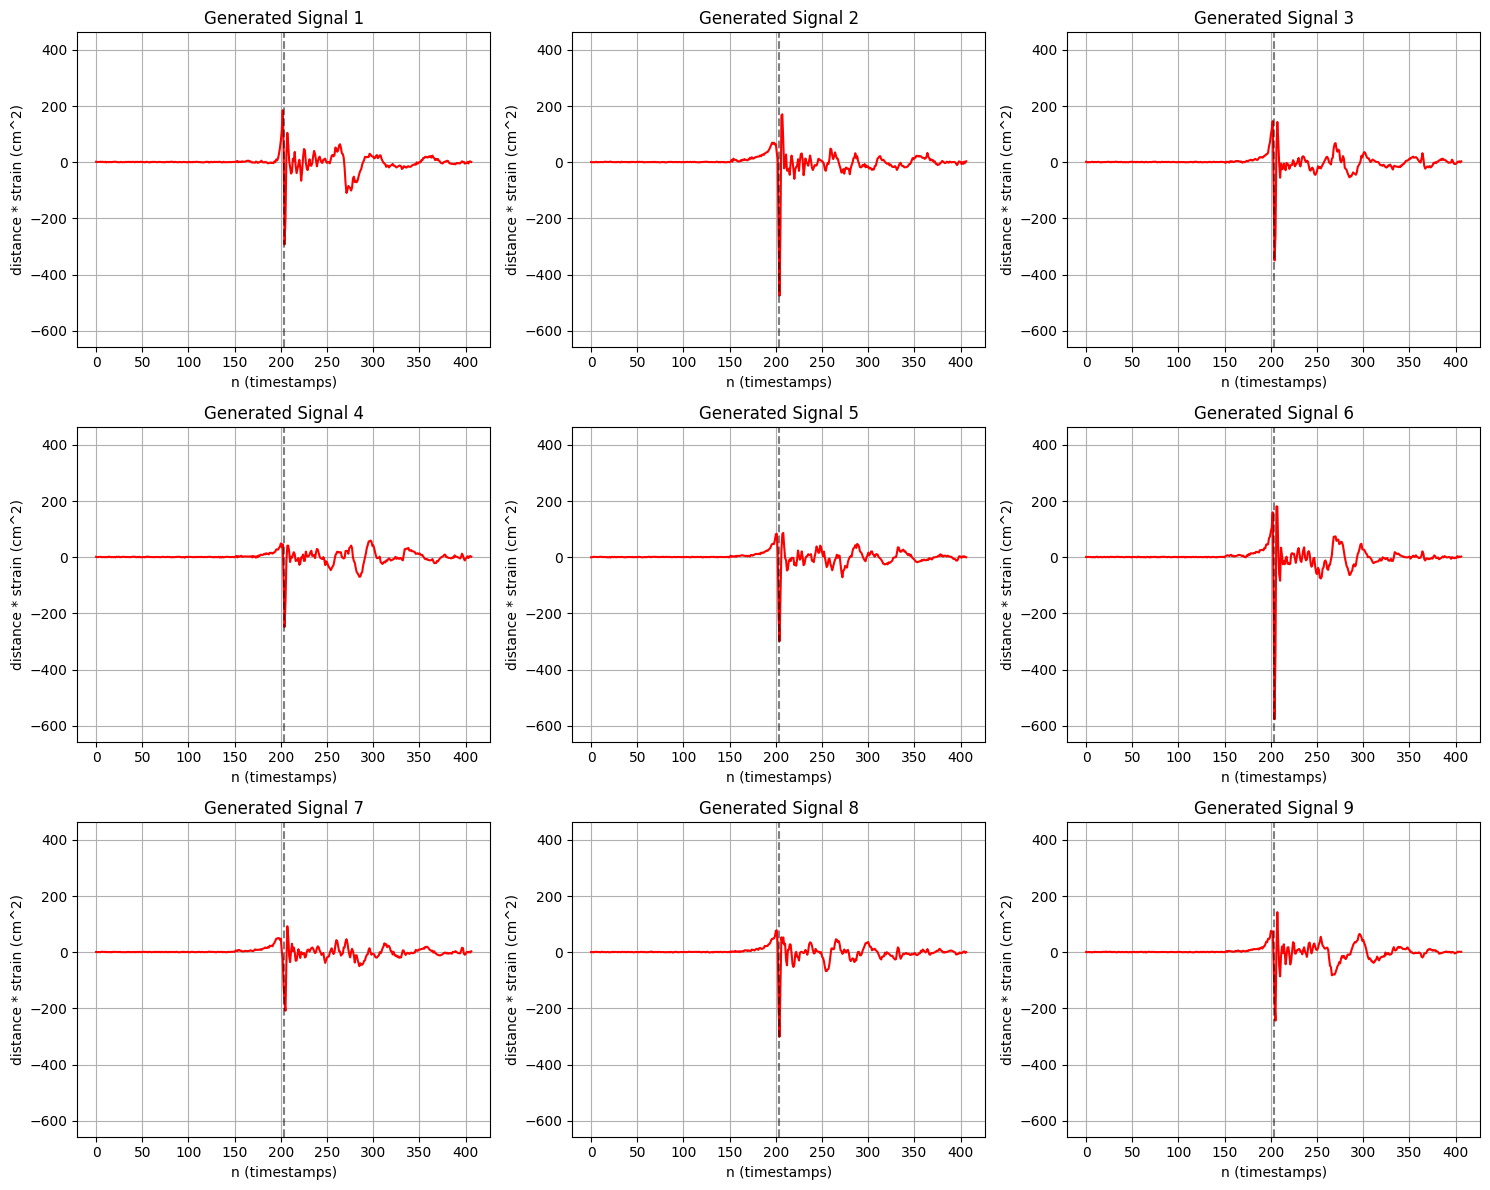

[24/32][0/188]	Loss_D: 0.4700	Loss_G: 2.4766	D(x): 0.9474	D(G(z)): 0.0870 / 0.1069
[24/32][50/188]	Loss_D: 0.5484	Loss_G: 2.5220	D(x): 0.9126	D(G(z)): 0.1353 / 0.1205
[24/32][100/188]	Loss_D: 0.4653	Loss_G: 2.1187	D(x): 0.9522	D(G(z)): 0.1423 / 0.1691
[24/32][150/188]	Loss_D: 0.5677	Loss_G: 1.7481	D(x): 0.9517	D(G(z)): 0.2866 / 0.2365
Epoch 24: SGD Discriminator lr 0.0000125 -> 0.0000122
Epoch 24: SGD Generator lr 0.0000125 -> 0.0000122


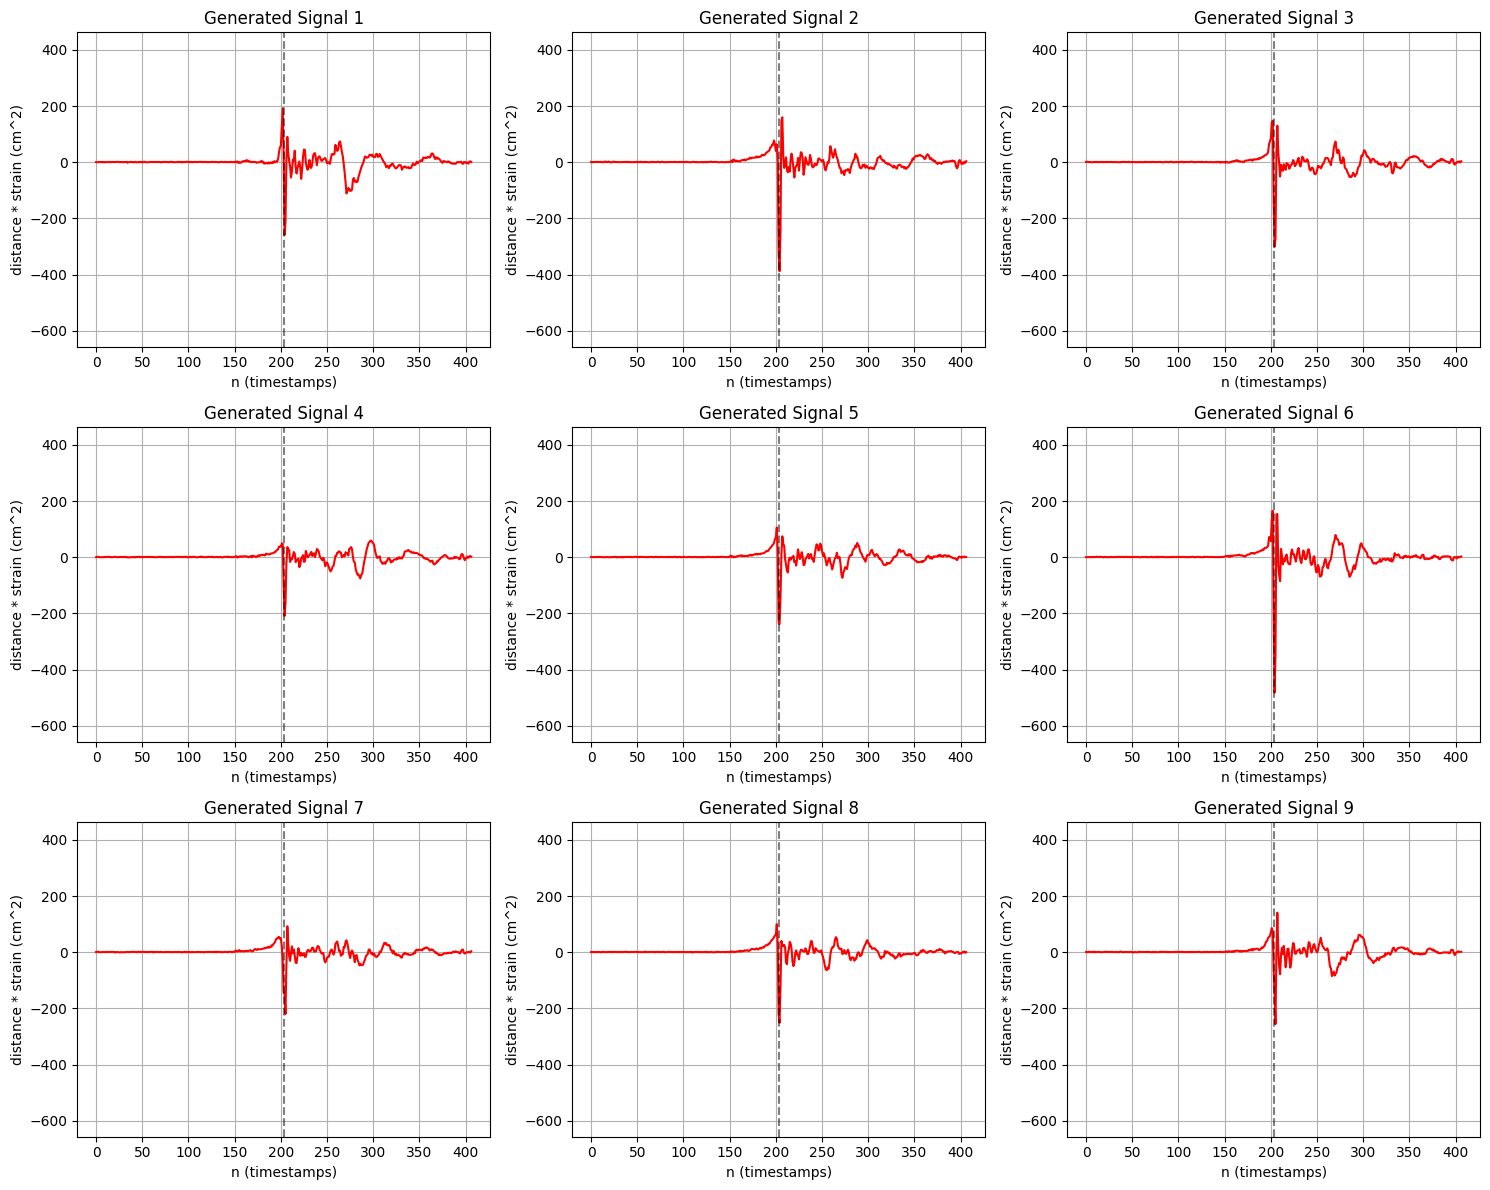

[25/32][0/188]	Loss_D: 0.5530	Loss_G: 2.0261	D(x): 0.9489	D(G(z)): 0.2090 / 0.1902
[25/32][50/188]	Loss_D: 0.5981	Loss_G: 2.1656	D(x): 0.9467	D(G(z)): 0.2435 / 0.1859
[25/32][100/188]	Loss_D: 0.5293	Loss_G: 2.4385	D(x): 0.9371	D(G(z)): 0.1004 / 0.1231
[25/32][150/188]	Loss_D: 0.5239	Loss_G: 2.0329	D(x): 0.9641	D(G(z)): 0.1532 / 0.1739
Epoch 25: SGD Discriminator lr 0.0000122 -> 0.0000119
Epoch 25: SGD Generator lr 0.0000122 -> 0.0000119


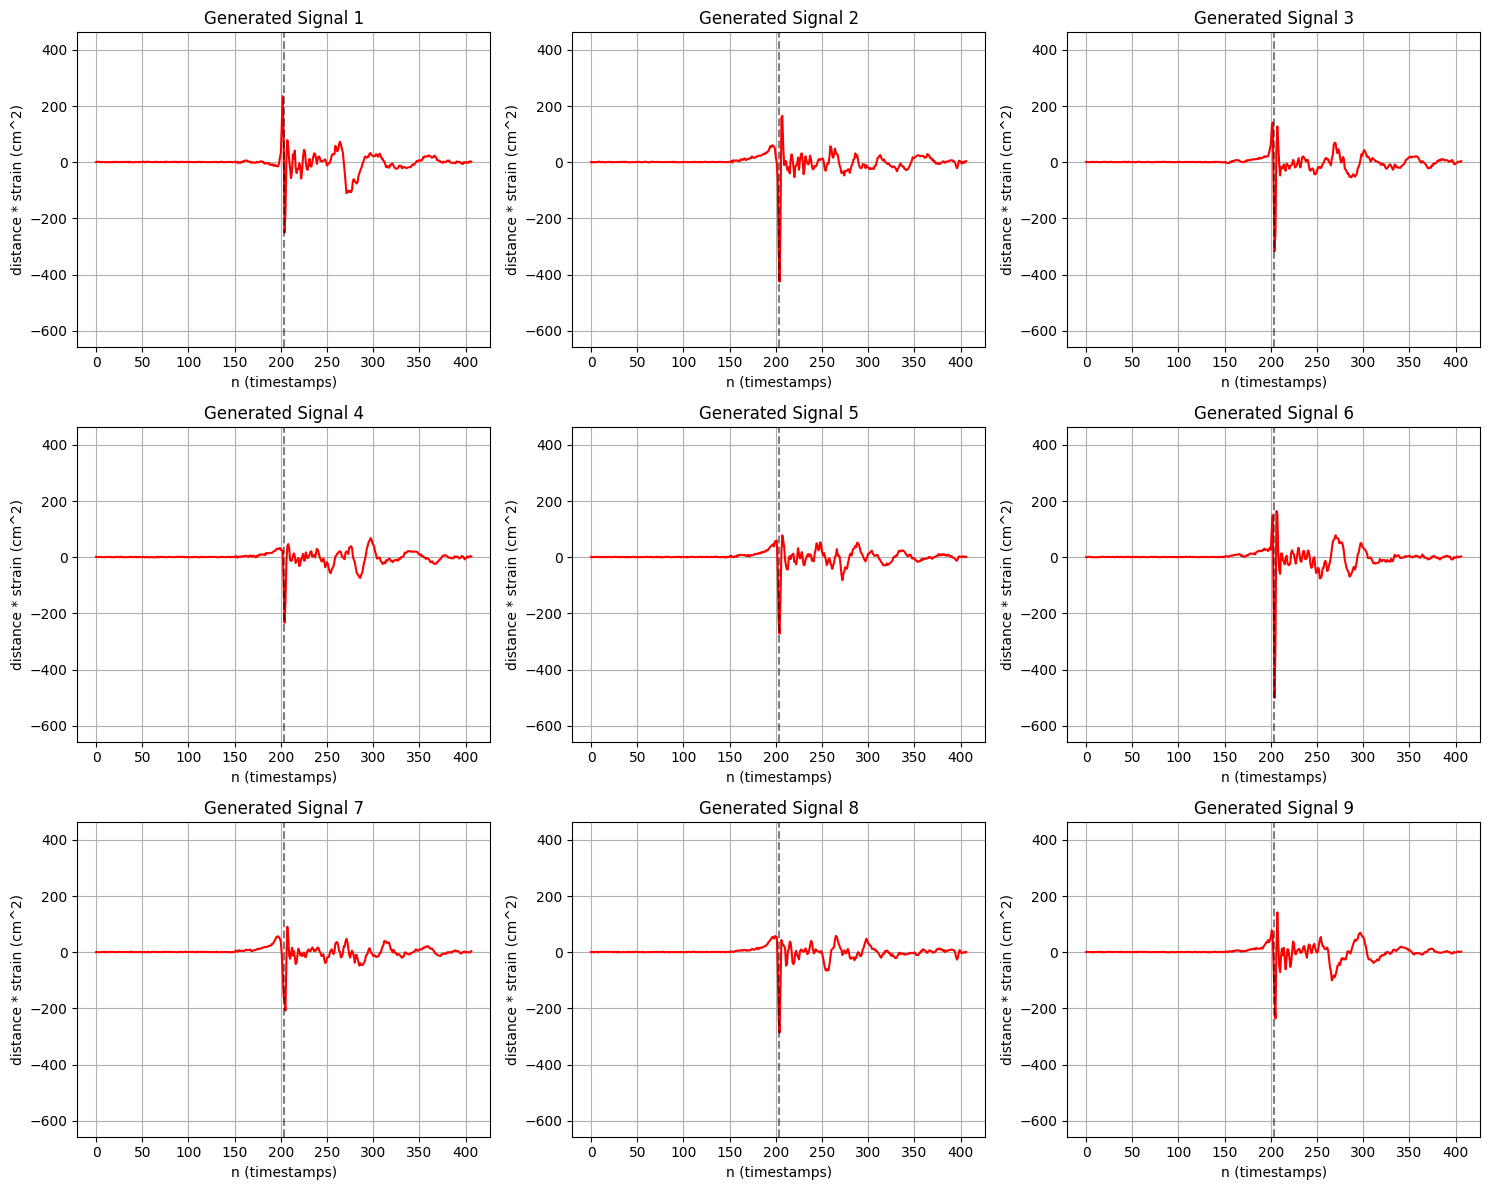

[26/32][0/188]	Loss_D: 0.5059	Loss_G: 2.3543	D(x): 0.9311	D(G(z)): 0.1691 / 0.1443
[26/32][50/188]	Loss_D: 0.4879	Loss_G: 2.1625	D(x): 0.9520	D(G(z)): 0.2071 / 0.1555
[26/32][100/188]	Loss_D: 0.5799	Loss_G: 2.8644	D(x): 0.8757	D(G(z)): 0.0716 / 0.0826
[26/32][150/188]	Loss_D: 0.4919	Loss_G: 2.1174	D(x): 0.9563	D(G(z)): 0.1960 / 0.1973
Epoch 26: SGD Discriminator lr 0.0000119 -> 0.0000116
Epoch 26: SGD Generator lr 0.0000119 -> 0.0000116


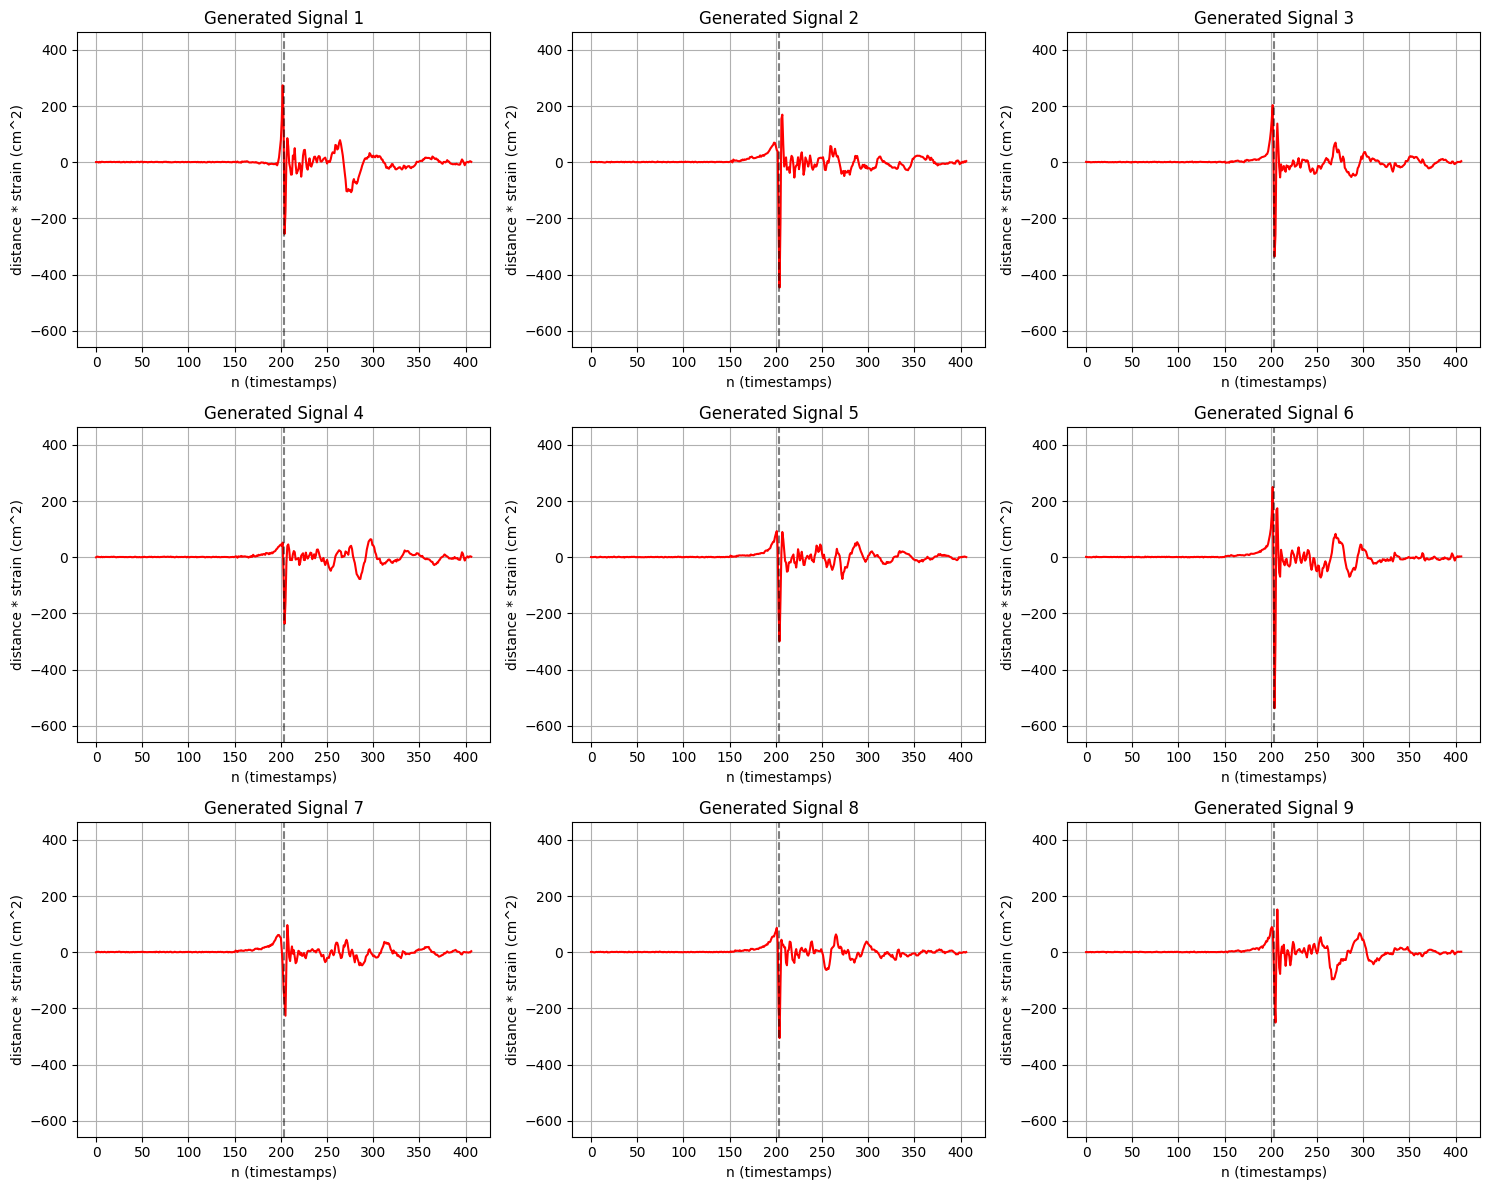

[27/32][0/188]	Loss_D: 0.4913	Loss_G: 2.0096	D(x): 0.9593	D(G(z)): 0.1735 / 0.1778
[27/32][50/188]	Loss_D: 0.4980	Loss_G: 2.3507	D(x): 0.9603	D(G(z)): 0.1509 / 0.1385
[27/32][100/188]	Loss_D: 0.5316	Loss_G: 2.3101	D(x): 0.9411	D(G(z)): 0.1431 / 0.1413
[27/32][150/188]	Loss_D: 0.5317	Loss_G: 2.2508	D(x): 0.9559	D(G(z)): 0.1553 / 0.1434
Epoch 27: SGD Discriminator lr 0.0000116 -> 0.0000112
Epoch 27: SGD Generator lr 0.0000116 -> 0.0000112


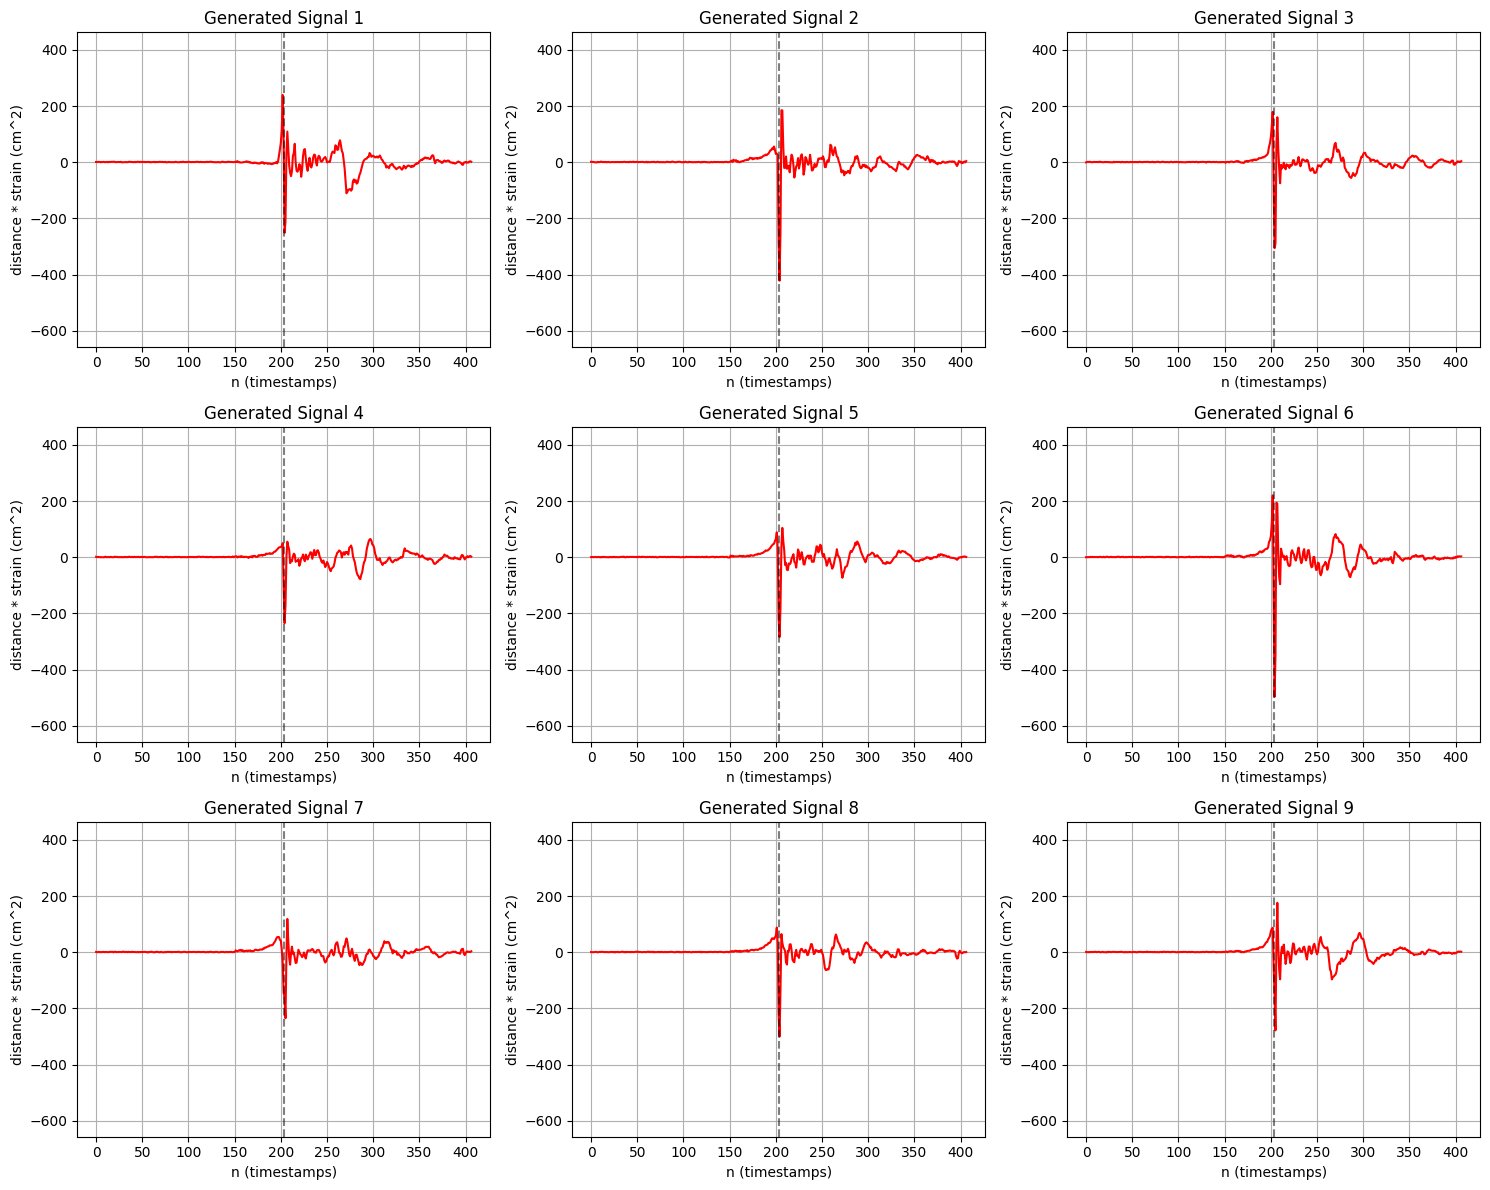

[28/32][0/188]	Loss_D: 0.4415	Loss_G: 2.1732	D(x): 0.9586	D(G(z)): 0.1225 / 0.1428
[28/32][50/188]	Loss_D: 0.5567	Loss_G: 1.7622	D(x): 0.9684	D(G(z)): 0.2992 / 0.2270
[28/32][100/188]	Loss_D: 0.4505	Loss_G: 2.2793	D(x): 0.9230	D(G(z)): 0.1531 / 0.1581
[28/32][150/188]	Loss_D: 0.5802	Loss_G: 1.9285	D(x): 0.9240	D(G(z)): 0.2209 / 0.2069
Epoch 28: SGD Discriminator lr 0.0000112 -> 0.0000109
Epoch 28: SGD Generator lr 0.0000112 -> 0.0000109


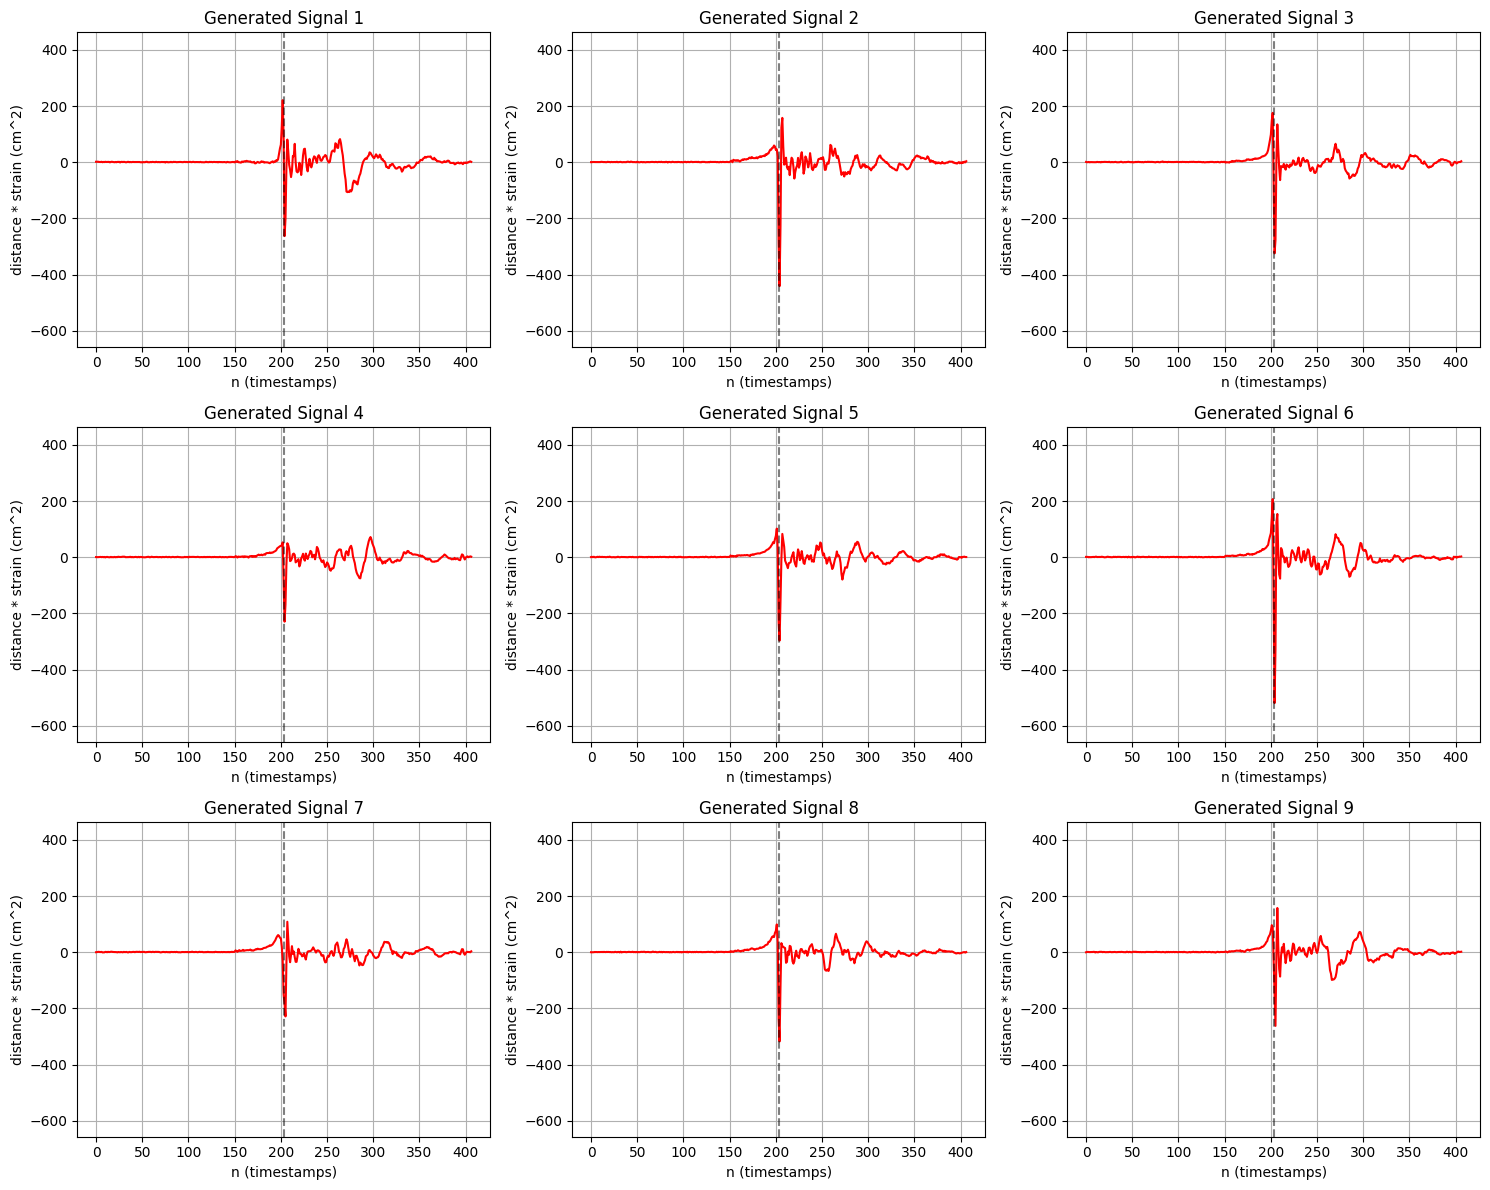

[29/32][0/188]	Loss_D: 0.4203	Loss_G: 2.4112	D(x): 0.9521	D(G(z)): 0.1214 / 0.1355
[29/32][50/188]	Loss_D: 0.5191	Loss_G: 2.5134	D(x): 0.9223	D(G(z)): 0.1454 / 0.1246
[29/32][100/188]	Loss_D: 0.5114	Loss_G: 1.6929	D(x): 0.9185	D(G(z)): 0.1955 / 0.2440
[29/32][150/188]	Loss_D: 0.5257	Loss_G: 1.9872	D(x): 0.9602	D(G(z)): 0.2313 / 0.1704
Epoch 29: SGD Discriminator lr 0.0000109 -> 0.0000106
Epoch 29: SGD Generator lr 0.0000109 -> 0.0000106


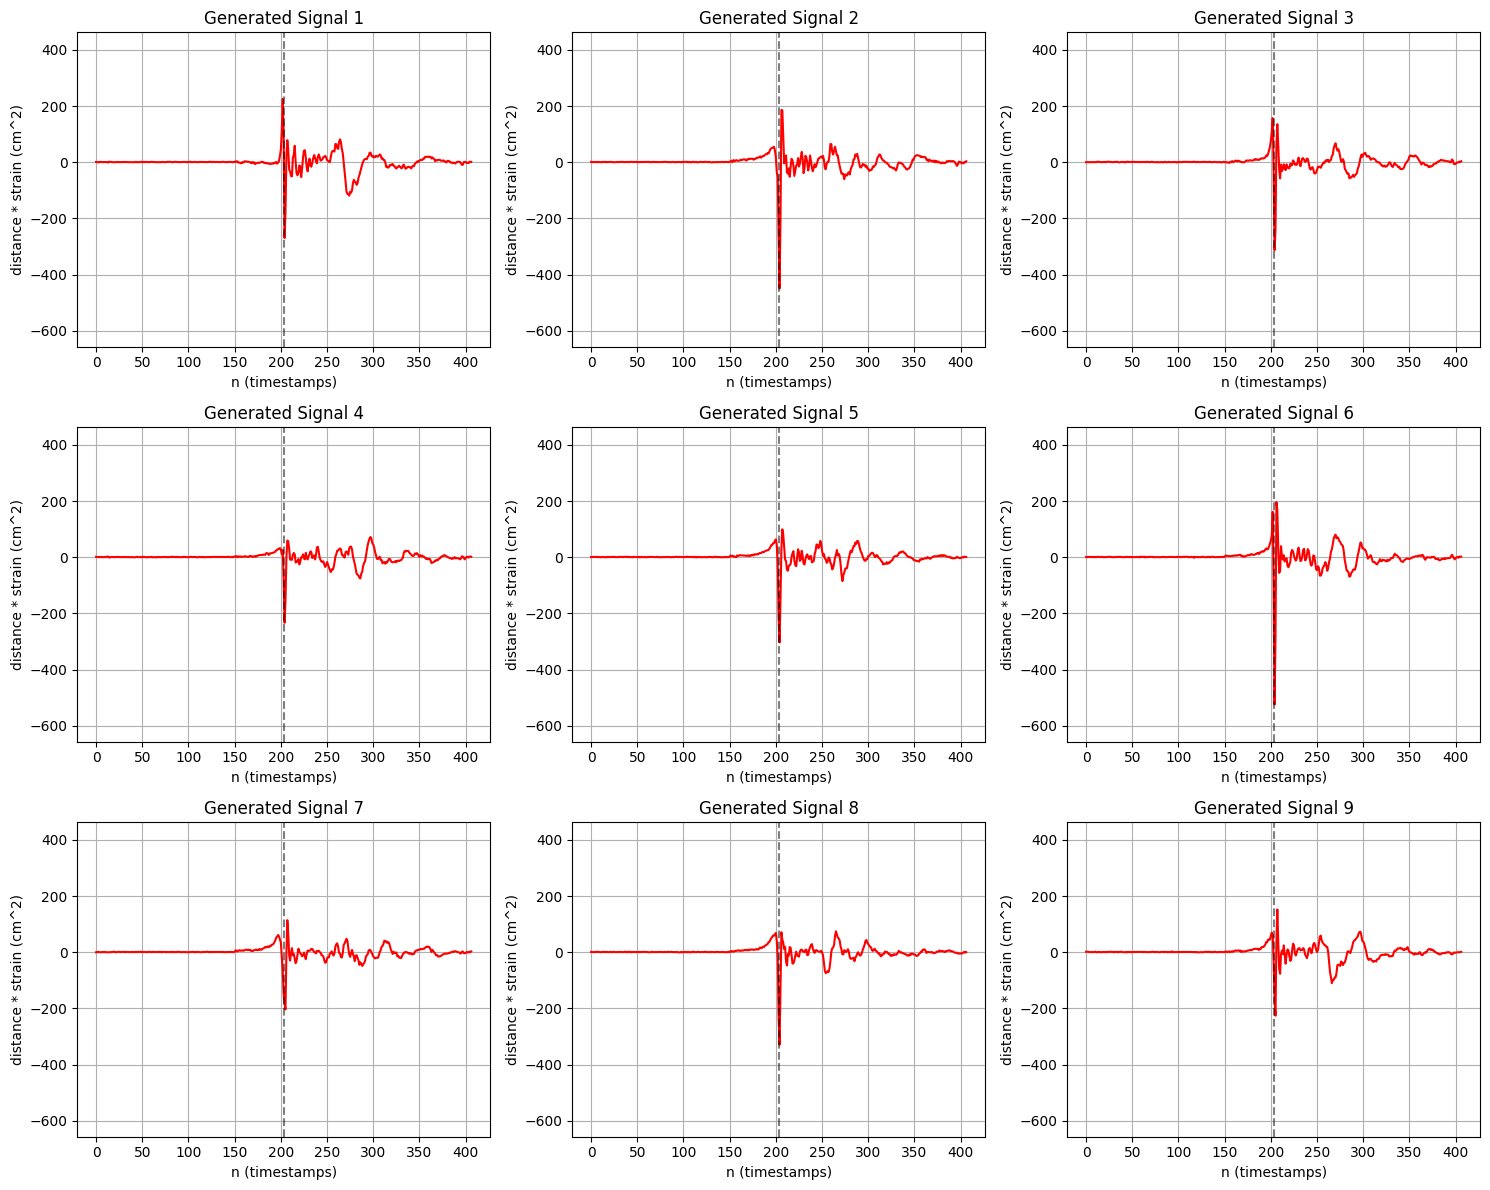

[30/32][0/188]	Loss_D: 0.5256	Loss_G: 1.9494	D(x): 0.9400	D(G(z)): 0.1799 / 0.2006
[30/32][50/188]	Loss_D: 0.4886	Loss_G: 2.2375	D(x): 0.9651	D(G(z)): 0.1257 / 0.1514
[30/32][100/188]	Loss_D: 0.4877	Loss_G: 2.0492	D(x): 0.9322	D(G(z)): 0.2191 / 0.2079
[30/32][150/188]	Loss_D: 0.4931	Loss_G: 2.1207	D(x): 0.9527	D(G(z)): 0.2200 / 0.1781
Epoch 30: SGD Discriminator lr 0.0000106 -> 0.0000103
Epoch 30: SGD Generator lr 0.0000106 -> 0.0000103


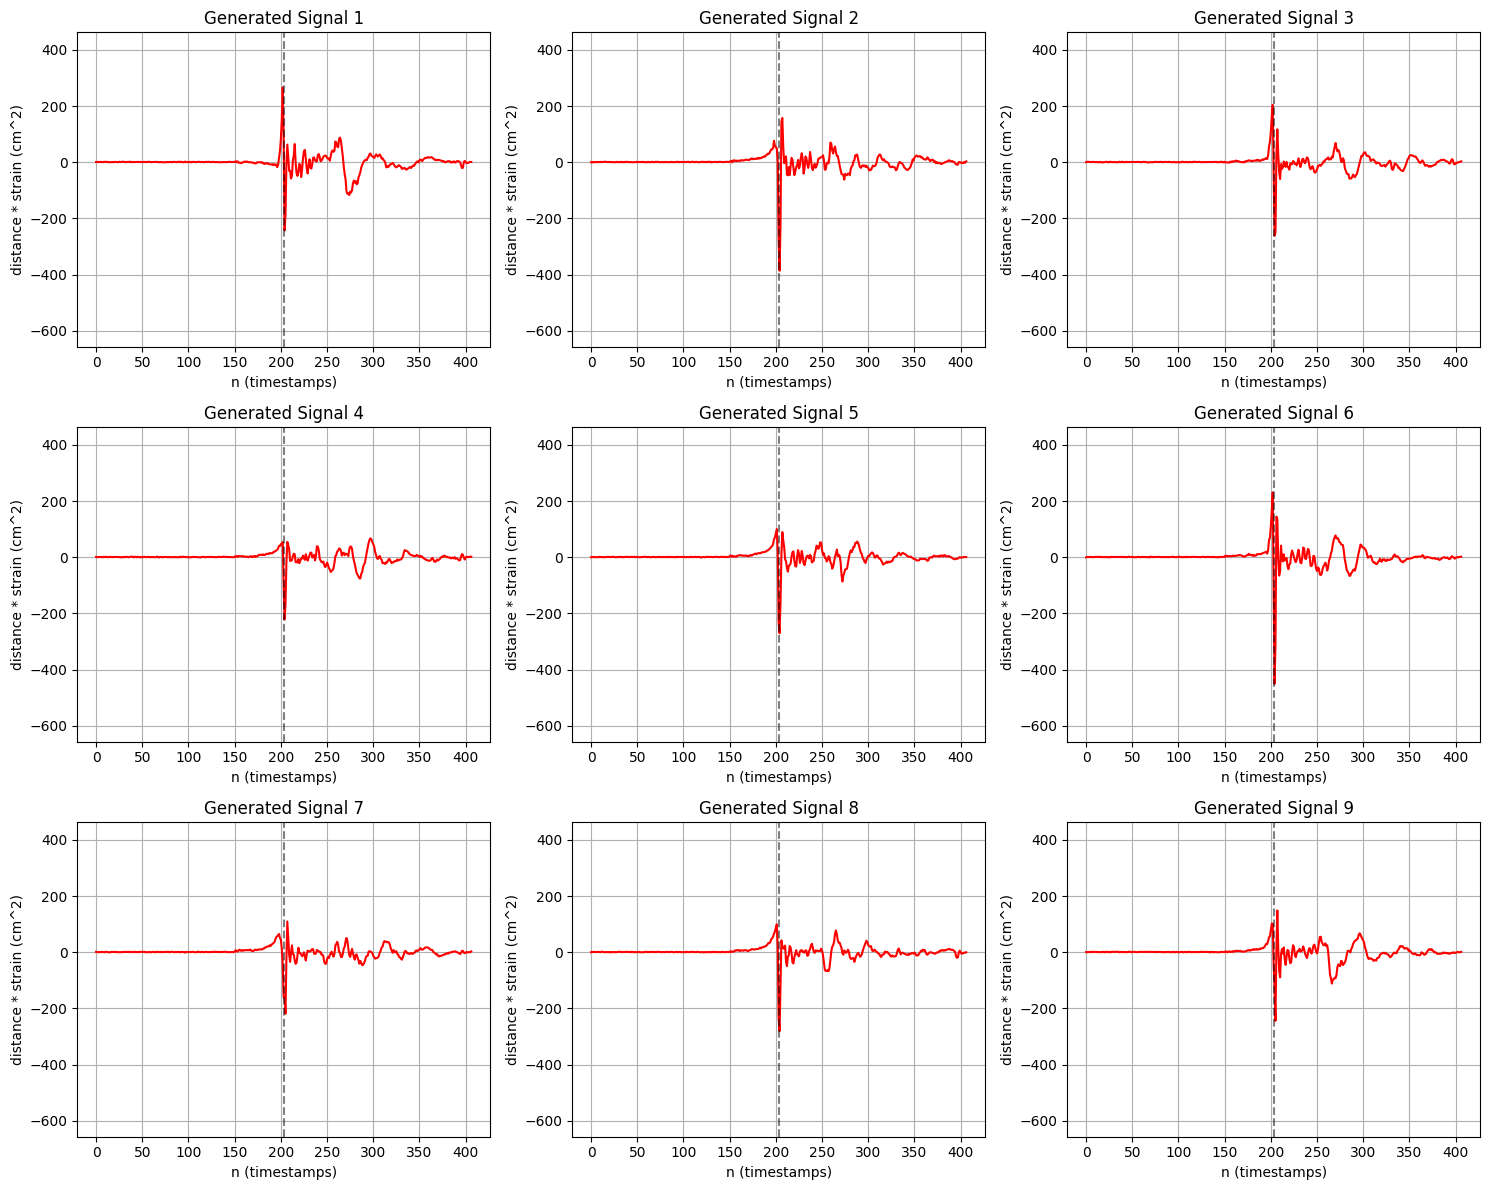

[31/32][0/188]	Loss_D: 0.5691	Loss_G: 1.6100	D(x): 0.9607	D(G(z)): 0.2491 / 0.2509
[31/32][50/188]	Loss_D: 0.4804	Loss_G: 2.2260	D(x): 0.9601	D(G(z)): 0.1992 / 0.1508
[31/32][100/188]	Loss_D: 0.3746	Loss_G: 2.6853	D(x): 0.9512	D(G(z)): 0.1061 / 0.1032
[31/32][150/188]	Loss_D: 0.4905	Loss_G: 1.7757	D(x): 0.9658	D(G(z)): 0.1655 / 0.2353
Epoch 31: SGD Discriminator lr 0.0000103 -> 0.0000100
Epoch 31: SGD Generator lr 0.0000103 -> 0.0000100


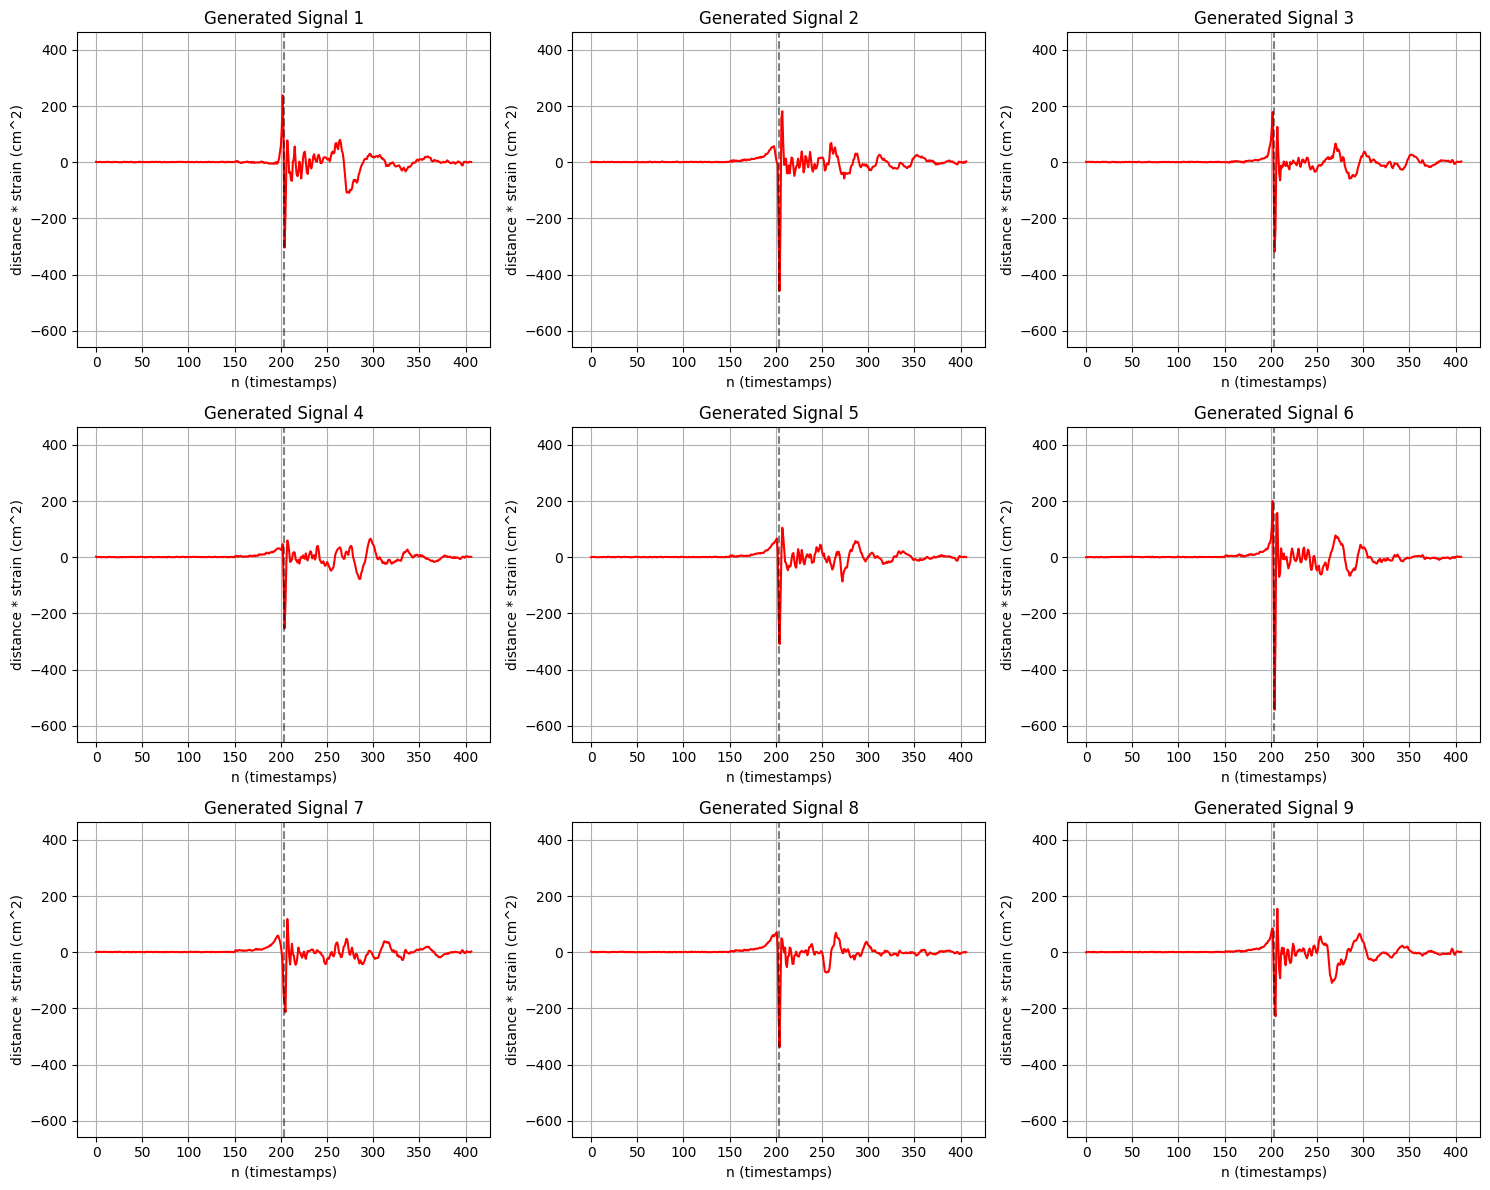

In [260]:
# Training Loop

# Lists to keep track of progress
signal_list = []
G_losses = []
D_losses = []
D_gradients = []
G_gradients = []
iters = 0

if (gans_type == 'dcgans' or gans_type == 'gans'):
    print("Starting Training Loop...")
    # For each epoch
    for epoch in range(num_epochs):
        # For each batch in the dataloader
        for i, data in enumerate(dataloader, 0):

            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            netD.zero_grad()
            # Format batch
            real_gpu = data[0].to(device)
            real_parameters_gpu = data[1].to(device)
            b_size = real_gpu.size(0)
            label_real = torch.FloatTensor(b_size).uniform_(1.0, 1.0).to(device)
            # Forward pass real batch through D
            output = netD(real_gpu).view(-1)
            # Calculate loss on all-real batch
            errD_real = criterion(output, label_real)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, nz, 1, device=device)
            # Generate fake signal batch with G
            fake = netG(noise)
            label_fake = torch.FloatTensor(b_size).uniform_(0.0, 0.25).to(device)
            # label_fake = torch.FloatTensor(b_size).uniform_(0.0, 0.0).to(device)
            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label_fake)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()
            # Calculate gradients of discriminator parameters
            D_gradients.append([param.grad.norm().item() for param in netD.parameters()])

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            label_real = torch.FloatTensor(b_size).uniform_(1.0, 1.0).to(device)
            # label_real = 1.0 - label_fake
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label_real)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()
            # Calculate gradients of generator parameters
            G_gradients.append([param.grad.norm().item() for param in netG.parameters()])

            # Output training stats
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                    % (epoch, num_epochs, i, len(dataloader),
                        errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

            iters += 1 
        
        # learning-rate decay
        before_lr = optimizerD.param_groups[0]["lr"]
        schedulerD.step()
        after_lr = optimizerD.param_groups[0]["lr"]
        print("Epoch %d: SGD Discriminator lr %.7f -> %.7f" % (epoch, before_lr, after_lr))

        before_lr = optimizerG.param_groups[0]["lr"]
        schedulerG.step()
        after_lr = optimizerG.param_groups[0]["lr"]
        print("Epoch %d: SGD Generator lr %.7f -> %.7f" % (epoch, before_lr, after_lr))
        
        with torch.no_grad():
            fake_signals = netG(fixed_noise).detach().cpu()
            fig, axes = plt.subplots(3, 3, figsize=(15, 12))

            axes = axes.flatten()

            # plot each signal on a separate subplot
            for i, ax in enumerate(axes):
                x = np.arange(407)
                y = fake_signals[i, :, :].flatten()
                y = y * dataset.scaling_factor
                y = y * dataset.std + dataset.mean
                background_noise_generated = np.random.normal(dataset.background_noise_mean, dataset.background_noise_std, int(407-256))
                # background_noise_generated_1st_half = np.random.normal(dataset.background_noise_mean, dataset.background_noise_std, int((407-256)/2))
                # background_noise_generated_2nd_half = np.random.normal(dataset.background_noise_mean, dataset.background_noise_std, int((407-256)/2 + 1))
                y = np.concatenate((background_noise_generated, y))
                
                ax.plot(x, y, color = 'red')

                ax.axvline(x=203, color='black', linestyle='--', alpha=0.5)
                ax.set_title(f'Generated Signal {i + 1}')
                ax.grid(True)
                ax.set_ylim(ylim_signal)
                ax.set_ylabel('distance * strain (cm^2)')
                ax.set_xlabel('n (timestamps)')

            for i in range(407, 8*4):
                fig.delaxes(axes[i])

            plt.tight_layout()
            # plt.savefig('../data/gw-dcgans-images/gw-dcgans_epoch_non_augment_%d.png' % (epoch + 1))
            plt.show()
        
        signal_list.append(fake_signals)

### Gradients

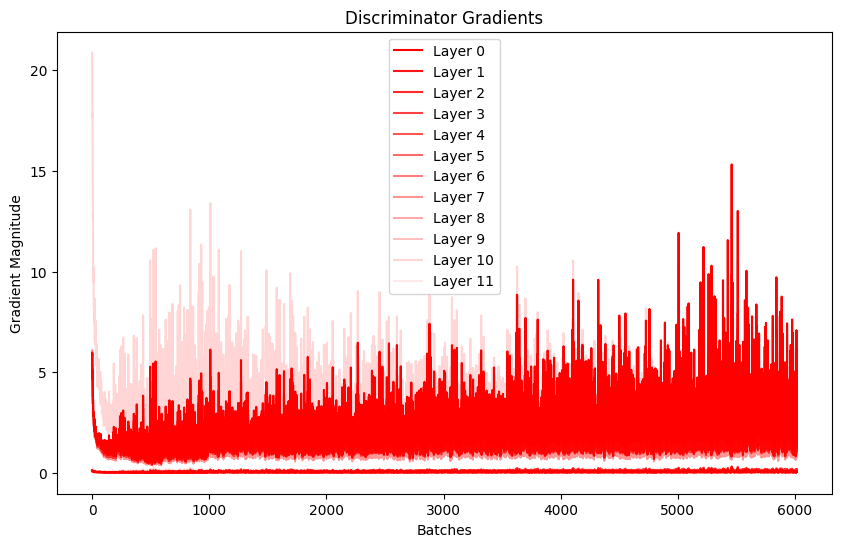

In [261]:
# Get the total number of layers in the discriminator
D_gradients = np.array(D_gradients)
num_layers = D_gradients.shape[1]

# Plot the gradients over training epochs
plt.figure(figsize=(10, 6))
for i in range(num_layers):
    # Calculate alpha value based on layer index
    alpha = 1 - (i / num_layers)  # Higher layers are more transparent
    plt.plot(D_gradients[:, i], label=f'Layer {i}', alpha=alpha, color=(1, 0, 0, alpha))

plt.xlabel('Batches')
plt.ylabel('Gradient Magnitude')
plt.title('Discriminator Gradients')
plt.legend()
# plt.savefig("../plots/architecture/gw_d_gradients_status_quo_32e.png")
plt.show()

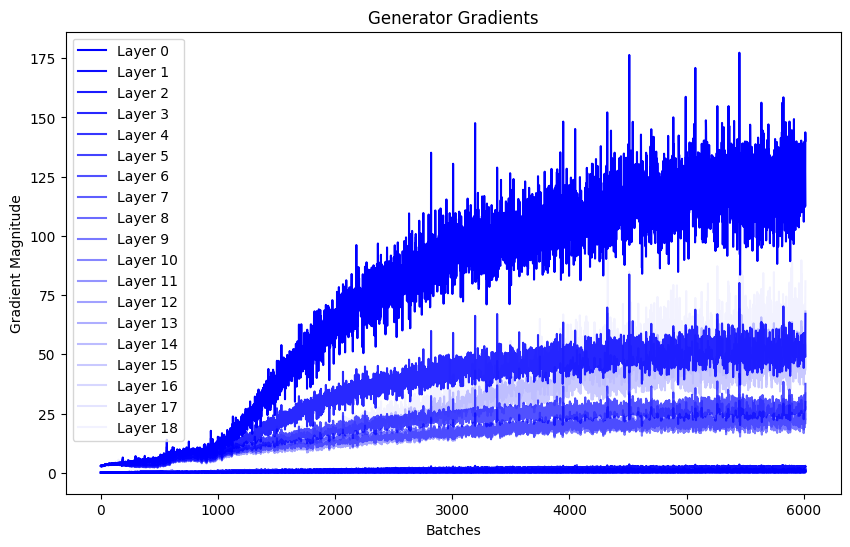

In [262]:
# Get the total number of layers in the discriminator
G_gradients = np.array(G_gradients)
num_layers = G_gradients.shape[1]

# Plot the gradients over training epochs
plt.figure(figsize=(10, 6))
for i in range(num_layers):
    # Calculate alpha value based on layer index
    alpha = 1 - (i / num_layers)  # Higher layers are more transparent
    plt.plot(G_gradients[:, i], label=f'Layer {i}', alpha=alpha, color=(0, 0, 1, alpha))

plt.xlabel('Batches')
plt.ylabel('Gradient Magnitude')
plt.title('Generator Gradients')
plt.legend()
# plt.savefig("../plots/architecture/gw_g_gradients_status_quo_32e.png")
plt.show()

### Loss

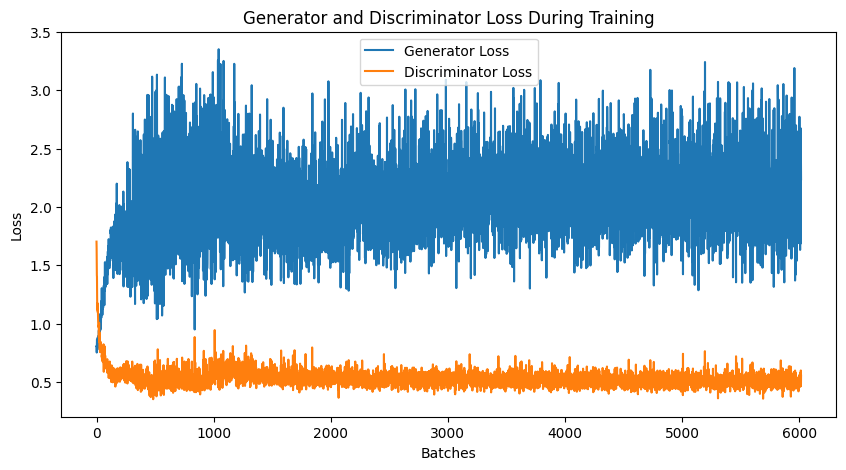

In [263]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="Generator Loss")
plt.plot(D_losses,label="Discriminator Loss")
plt.xlabel("Batches")
plt.ylabel("Loss")
plt.legend()
# plt.savefig("../plots/architecture/gw_train_losses_no_smooth_labels_32e.png")
plt.show()

### Generated Signals

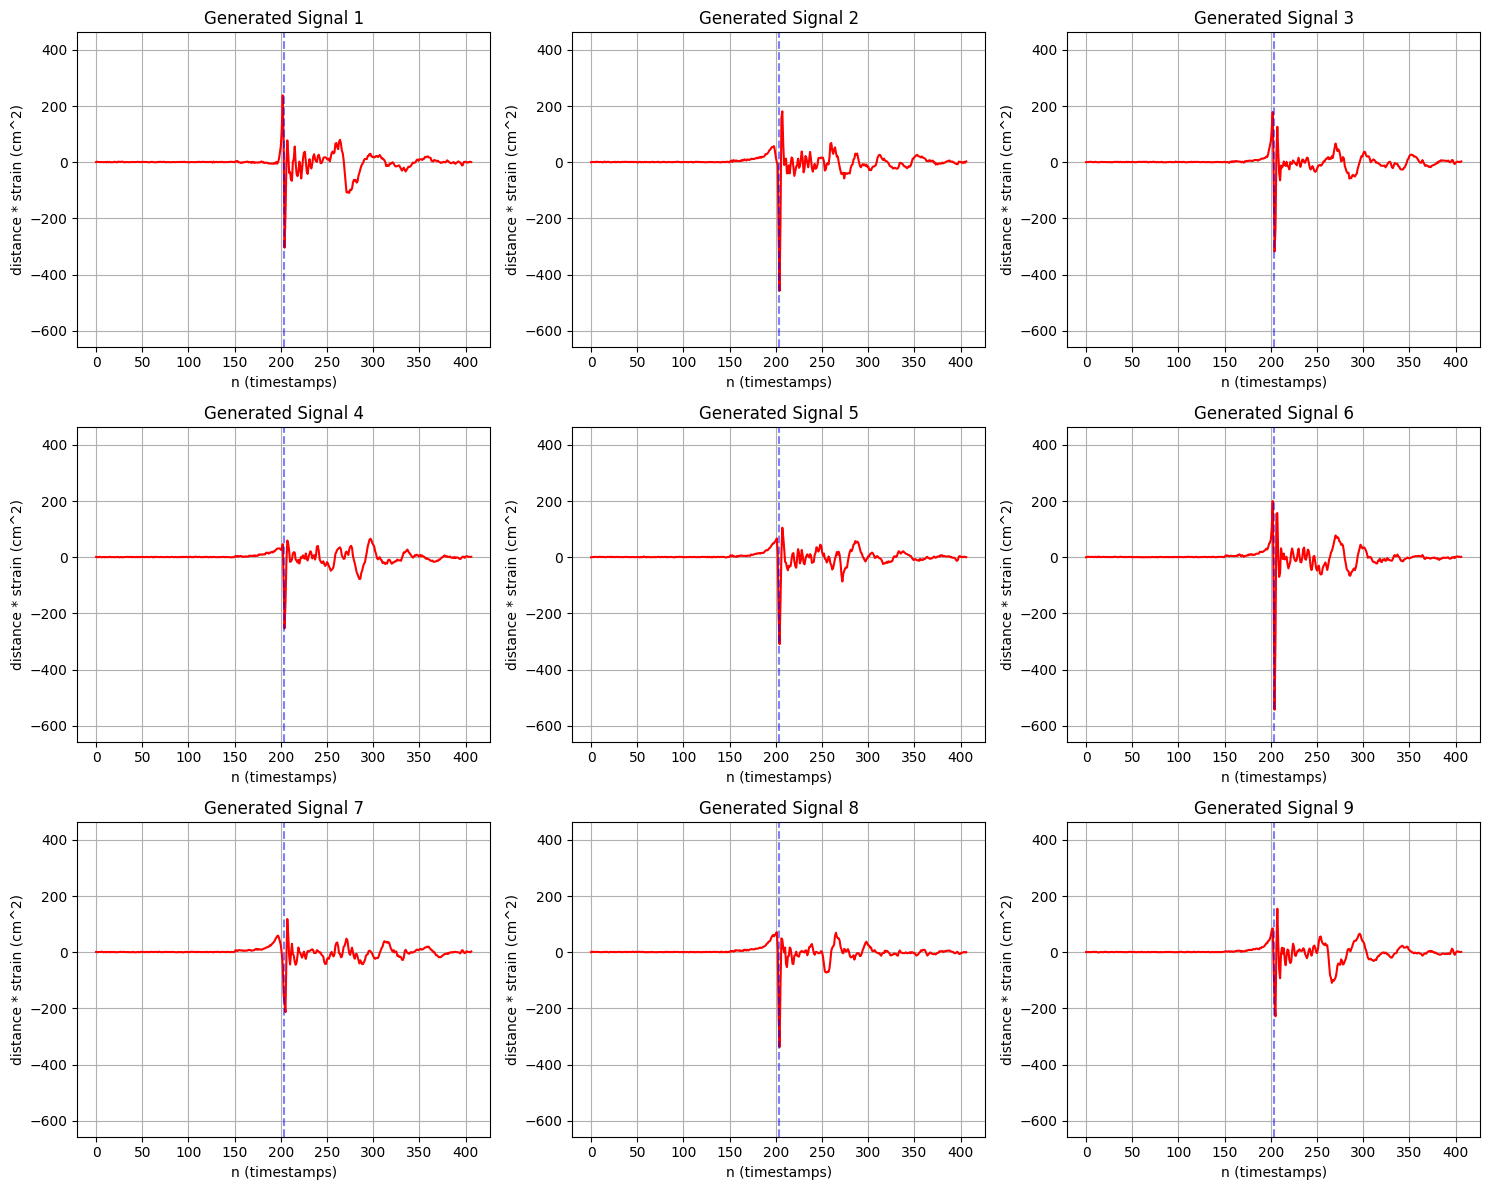

In [264]:
batch = signal_list[31]

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

# plot each signal on a separate subplot
for i, ax in enumerate(axes):
    x = np.arange(407)
    y = batch[i, :, :].flatten()
    y = y * dataset.scaling_factor
    y = y * dataset.std + dataset.mean
    background_noise_generated = np.random.normal(dataset.background_noise_mean, dataset.background_noise_std, int(407-256))
    # background_noise_generated_1st_half = np.random.normal(dataset.background_noise_mean, dataset.background_noise_std, int((407-256)/2))
    # background_noise_generated_2nd_half = np.random.normal(dataset.background_noise_mean, dataset.background_noise_std, int((407-256)/2 + 1))
    # y = np.concatenate((background_noise_generated_1st_half, y, background_noise_generated_2nd_half))
    y = np.concatenate((background_noise_generated, y))
    ax.plot(x, y, color = 'red')

    ax.axvline(x=203, color='blue', linestyle='--', alpha=0.5)
    ax.set_title(f'Generated Signal {i + 1}')
    ax.grid(True)
    ax.set_ylim(ylim_signal)
    
    # Add axis titles
    ax.set_ylabel('distance * strain (cm^2)')
    ax.set_xlabel('n (timestamps)')

for i in range(407, 8*4):
    fig.delaxes(axes[i])

plt.tight_layout()
# plt.savefig('../plots/architecture/gw_generated_signals_no_smooth_labels_32e.png')
plt.show()